In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import trigger_algs_numba as trg_numba
import utils as util

cc='orangered'; cl = 'steelblue'

#TAMaker parameters settings based on backgrounds - central config is default, lateral APAs require higher auto accept window threshold + cluster req. due to higher proportion of externals 
lat_params = { "accept_threshold": 130e3, "cluster_cut": 30e3 }

# Backgrounds 

### Loading data

In [2]:
#Loading bgd TAs 
TAcen = pd.read_pickle("./trigger_data/central_bgd_TAs_994680_events.pkl")
TAlat = pd.read_pickle("./trigger_data/lateral_bgd_TAs_977220_events.pkl")
display(TAcen)
TAcen.drop_duplicates(inplace=True)
TAlat.drop_duplicates(inplace=True)


# loading event summary trees for backgrounds - useful for extracting total livetime 
lateral_ev_sum = pd.read_pickle("./lateral_apa/lateral_bgd_eventsum.pkl")
util.get_unique_event_ids(lateral_ev_sum)

central_ev_sum = pd.read_pickle("./central_apa/central_bgd_eventsum.pkl")
util.get_unique_event_ids(central_ev_sum)

event  tpc  window_start  flag  TA_id  total_window_energy  TP_count  \
0        15813   19          3000     0    379                18699         8   
1        15817    2          3000     0    820                15521         8   
2        15817   10             0     0    860                31246        13   
3        15811    3             0     0     14                15993         9   
4        15815   14          3000     0    624                15495        11   
...        ...  ...           ...   ...    ...                  ...       ...   
4003186  95118   18          3000     0  22408                15265         6   
4003187  95118   19          5000     0  22416                18002         8   
4003188  95119   13          4000     0  22509                15078         4   
4003189  95120   18          1000     0  22671                18341         6   
4003190  95120   16          4000     0  22663                18709         7   

         n_clusters  mean_cluster_energy total_cluster_energy  \
0                 0                  0.0                    0   
1                 1               6193.0                 6193   
2                 2               8132.0                16264   
3                 1               5182.0                 5182   
4                 0                  0.0                    0   
...             ...                  ...                  ...   
4003186           2               6370.0                12740   
4003187           2               5910.5                11821   
4003188           0                  0.0                    0   
4003189           1              11778.0                11778   
4003190           2               7674.5                15349   

        max_cluster_energy   run          TAid_u  
0                        0  8190  35175807008197  
1                     6193  8190  35175835909577  
2                    10927  8190  35175838531017  
3                     5182  8190  35175783087555  
4                        0  8190  35175823064519  
...                    ...   ...             ...  
4003186               7458  8190  35177250780046  
4003187               7446  8190  35177251304334  
4003188                  0  8190  35177257333647  
4003189              11778  8190  35177267950480  
4003190               9444  8190  35177267426192  

[4003191 rows x 13 columns]

### Rate estimation 

In [3]:
#translate number of simulated events to livetime for each 0.5 kt detector volume 
events_in_1s_central = 696
events_in_1s_lateral = 1392

# Central APA
central_events =  central_ev_sum.event_uid.nunique()
central_livetime = central_events / events_in_1s_central
central_fakes = TAcen[TAcen.flag==2].TA_id.nunique()
central_fake_rate = central_fakes / central_livetime

print("\n--- CENTRAL APA BACKGROUNDS ---")
print(f"1 second of data in the central FD volume corresponds to {events_in_1s_central} central APA background events.")
print(f"{central_events} events → {central_livetime:.1f} s livetime ({int(central_livetime/60)} minutes) ")
print(f"{central_fakes} fake triggers → {central_fake_rate:.2g} Hz fake rate")



# Lateral APA

lateral_events =  lateral_ev_sum.event_uid.nunique()
lateral_livetime = lateral_events / events_in_1s_lateral
lateral_fakes = TAlat[TAlat.flag ==2].event.nunique()
lateral_fake_rate = lateral_fakes / lateral_livetime

print("\n--- LATERAL APA BACKGROUNDS ---")
print(f"1 second of data in the central FD volume corresponds to {events_in_1s_lateral} lateral APA background events.")
print(f"{lateral_events} events → {lateral_livetime:.1f} s livetime  ({int(lateral_livetime/60)} minutes) ")
print(f"{lateral_fakes} fake triggers → {lateral_fake_rate:.3g} Hz fake rate")

# Total
total_fake_rate = central_fake_rate + lateral_fake_rate
print(f"\nTotal fake rate: {total_fake_rate:.2g} Hz")



--- CENTRAL APA BACKGROUNDS ---
1 second of data in the central FD volume corresponds to 696 central APA background events.
500340 events → 718.9 s livetime (11 minutes) 
513 fake triggers → 0.71 Hz fake rate

--- LATERAL APA BACKGROUNDS ---
1 second of data in the central FD volume corresponds to 1392 lateral APA background events.
490360 events → 352.3 s livetime  (5 minutes) 
145 fake triggers → 0.412 Hz fake rate

Total fake rate: 1.1 Hz


1 window = 0.5ms 

Rate at which windows are generated per collection plane (or TPC) = 1/0.5e-3 =  2000 Hz. 

200 TPCs in full FD --> TA window generation rate = 2000 * 200 = 400kHz \10kT

Only about 5% of windows are inspected: 400kHz * 0.05 = 20 kHz rate /10kT

Inspect rate per plane : 100 Hz/plane



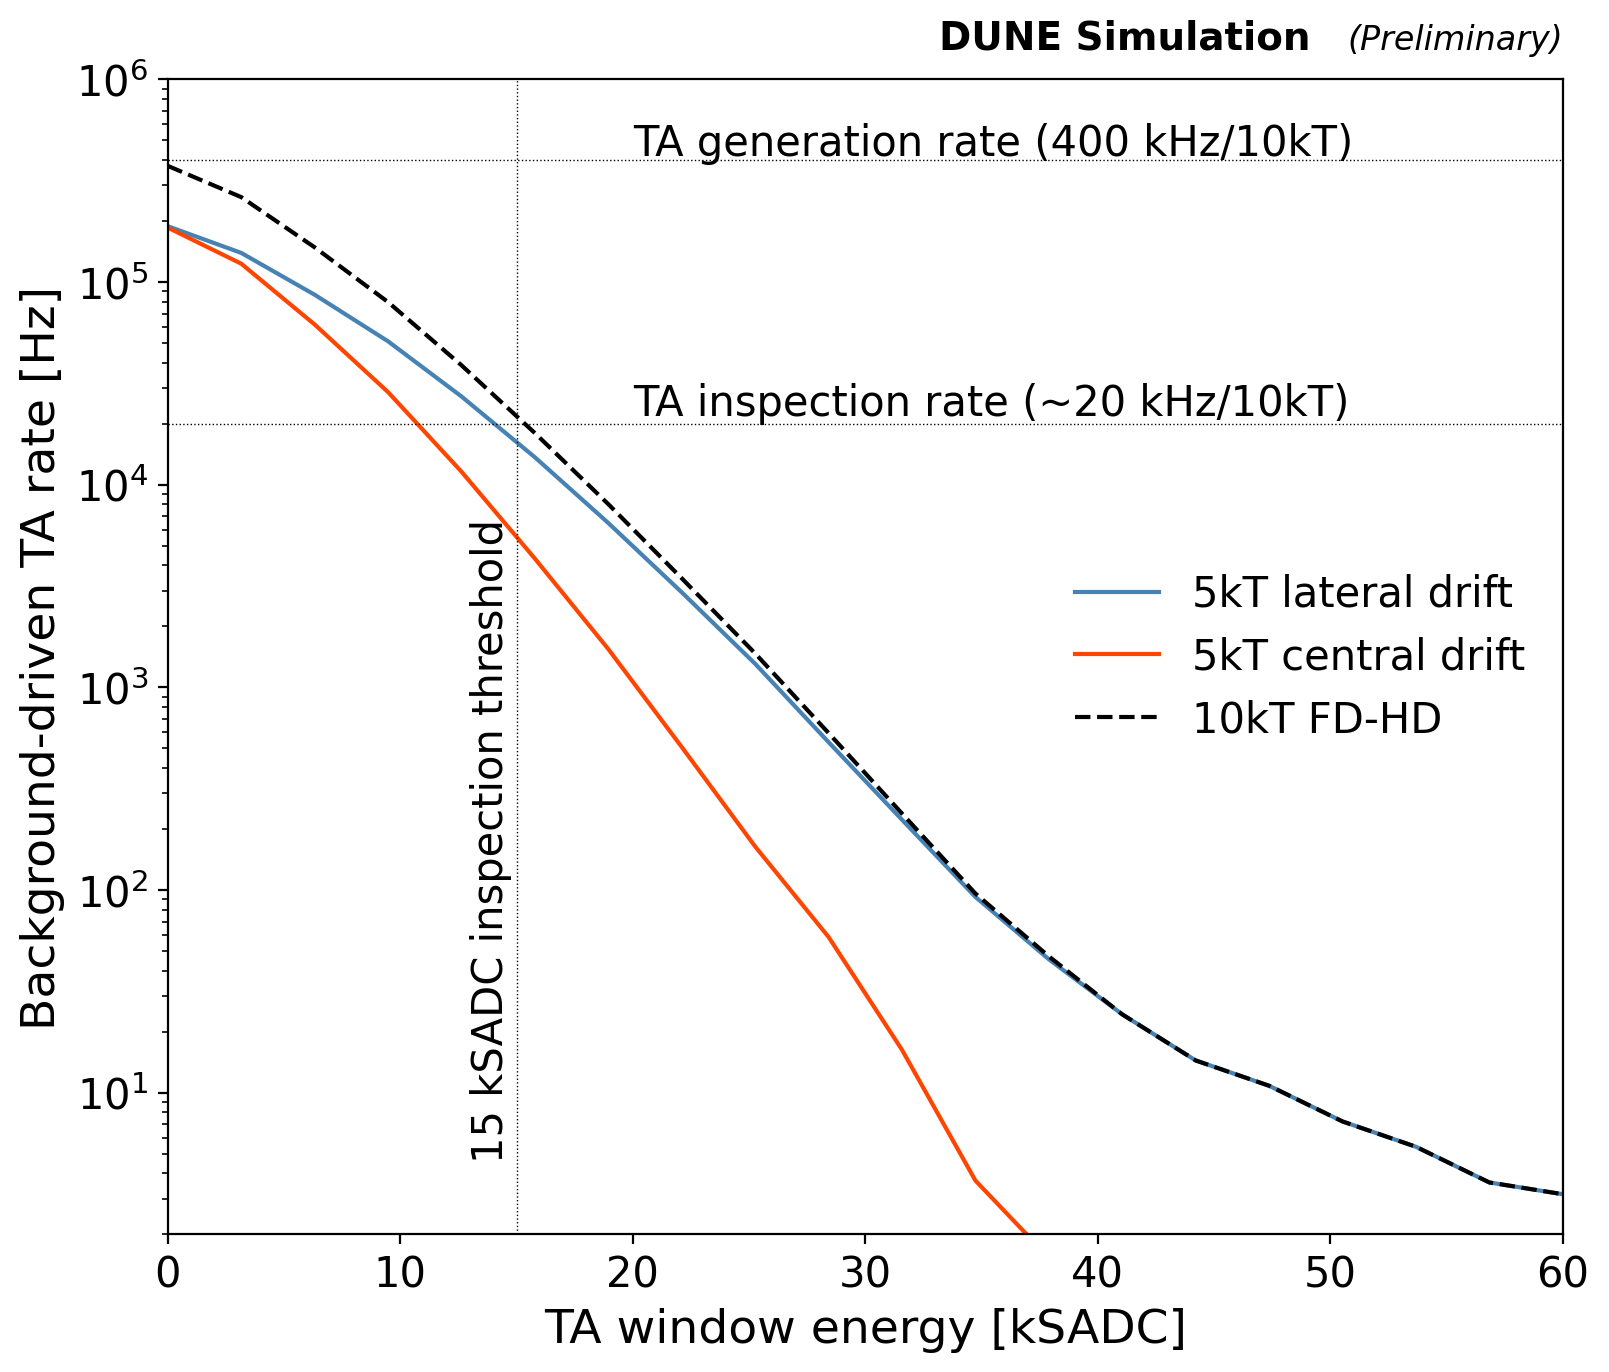

In [4]:
from scipy.signal import savgol_filter


#some older TA windows where the reject cases were kept 
lat_ta_windows = pd.read_pickle("./trigger_data/lat_ta_windows.pkl")
cent_ta_windows = pd.read_pickle("./trigger_data/cen_ta_windows.pkl")

old_livetime_l = lat_ta_windows.Event.nunique()/events_in_1s_lateral
old_livetime_c = cent_ta_windows.Event.nunique()/events_in_1s_central


cuts = np.linspace(0,60e3, 20)
lat_rates= np.zeros(len(cuts))
cent_rates = np.zeros(len(cuts))
for i, cut in enumerate(cuts):
    lat_rates[i] = (lat_ta_windows.window_energy_sum > cut).sum()
    cent_rates[i] = (cent_ta_windows.window_energy_sum > cut).sum()


ylim = [2,1e6]
rate_to_khz = 1e-3; fs=15


l =2 * lat_rates/old_livetime_l 
c =2 * cent_rates/old_livetime_c
t = 2  * (lat_rates/old_livetime_l + cent_rates/old_livetime_c ) 

fig, ax = plt.subplots(figsize=(9, 7.5), dpi=200)
plt.plot(cuts/1e3, l, c=cl, label ='5kT lateral drift')
plt.plot(cuts/1e3, c, c=cc, label = '5kT central drift')
plt.plot(cuts/1e3,  t, c='k', linestyle='dashed', label = '10kT FD-HD')
plt.yscale('log')
plt.ylim(ylim[0],ylim[1])
plt.xlim(0,60)
plt.xlabel("TA window energy [kSADC]",fontsize= fs+2)
plt.ylabel("Background-driven TA rate [Hz]", fontsize=fs+2)
plt.legend(frameon =False, fontsize =fs, loc = 'center right')

#inspect threshold
plt.vlines(15,ylim[0], ylim[1], linestyle='dotted', color='k',alpha =1, linewidth =0.5)
plt.text(13, 0.005e3, '15 kSADC inspection threshold', rotation =90, color='k', fontsize= fs)

#inspect rate
plt.hlines(20e3,0, 60, linestyle='dotted', color='k',alpha =1, linewidth =0.5)#rate at which inspect TAs are generate
plt.text(20, 22e3, 'TA inspection rate (~20 kHz/10kT)',  color='k', fontsize= fs)


#TA gen. rate
plt.hlines(400e3, 0,60, linestyle='dotted', color='k',alpha =1, linewidth =0.5) #rate at which tas are supposedly generated
plt.text(20, 420e3, 'TA generation rate (400 kHz/10kT)',  color='k', fontsize= fs)



fig.text(0.76, 0.9, 'DUNE Simulation', ha='right',fontsize=14, fontweight='bold')
fig.text(0.9, 0.9, '(Preliminary)', ha='right',fontsize=12, style='italic')
ax.tick_params(axis='both', labelsize=fs)
plt.savefig("./figures/ta_rates_vs_window_energy.png")

plt.show()



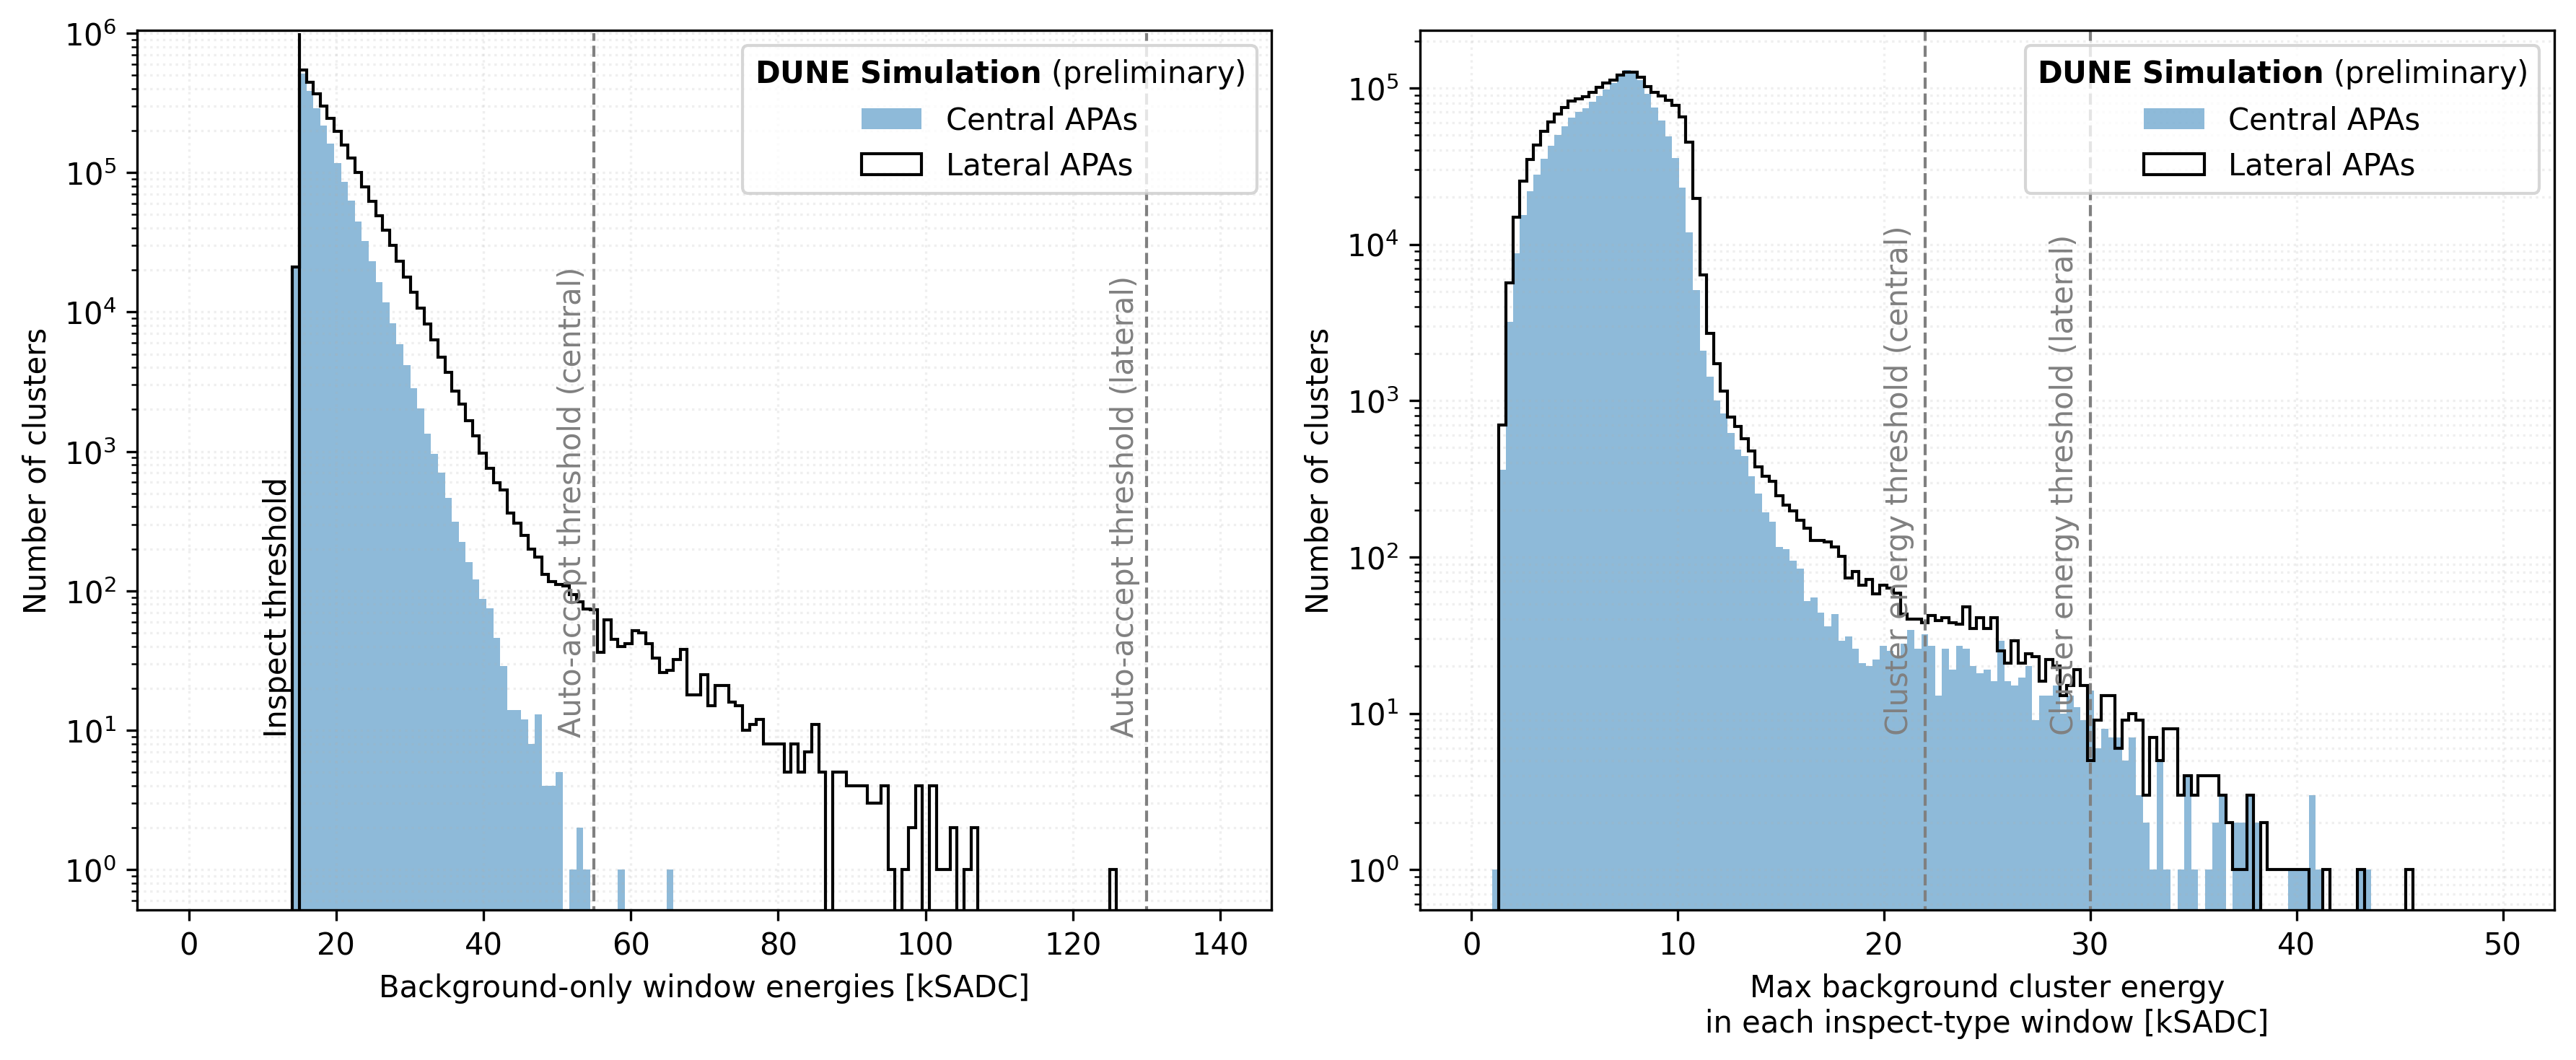

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

bins1 = np.linspace(0, 140, 150)
axs[0].hist(TAcen.total_window_energy / 1e3, histtype='stepfilled', alpha=0.5, bins=bins1, label='Central APAs')
axs[0].hist(TAlat.total_window_energy / 1e3, histtype='step', color='k', bins=bins1, label='Lateral APAs')
axs[0].set_yscale("log")
axs[0].set_xlabel("Background-only window energies [kSADC]")
axs[0].set_ylabel("Number of clusters")
axs[0].legend(title=r'$\bf{DUNE\ Simulation}$ (preliminary)', frameon=True, ncols=1, loc='upper right')
axs[0].grid(which='both', linestyle='dotted', alpha=0.2)
axs[0].vlines(15,0,10e5, color='k', linewidth =1)
axs[0].text(10, 10, s="Inspect threshold", rotation = 90, color='k')

axs[0].vlines(55,0,10e5, color='grey', linestyle='dashed', linewidth=1)
axs[0].text(50, 10, s="Auto-accept threshold (central)", rotation = 90, color='grey')

axs[0].vlines(130,0,10e5, color='grey', linestyle='dashed', linewidth=1)
axs[0].text(125, 10, s="Auto-accept threshold (lateral)", rotation = 90, color='grey')

bins2 = np.linspace(0, 50, 150)
axs[1].hist(TAcen[TAcen.n_clusters != 0].max_cluster_energy / 1e3, histtype='stepfilled', alpha=0.5, bins=bins2, label='Central APAs')
axs[1].hist(TAlat[TAlat.n_clusters != 0].max_cluster_energy / 1e3, histtype='step', color='k', bins=bins2, label='Lateral APAs')
axs[1].set_yscale("log")
axs[1].set_xlabel("Max background cluster energy\nin each inspect-type window [kSADC]")
axs[1].set_ylabel("Number of clusters")
axs[1].legend(title=r'$\bf{DUNE\ Simulation}$ (preliminary)', frameon=True, ncols=1, loc='upper right')
axs[1].grid(which='both', linestyle='dotted', alpha=0.2)

axs[1].vlines(22,0,10e5, color='grey', linestyle='dashed', linewidth=1)
axs[1].text(20, 8, s="Cluster energy threshold (central)", rotation = 90, color='grey')

axs[1].vlines(30,0,10e5, color='grey', linestyle='dashed', linewidth=1,)
axs[1].text(28, 8, s="Cluster energy threshold (lateral)", rotation = 90, color='grey')

plt.tight_layout()
plt.show()


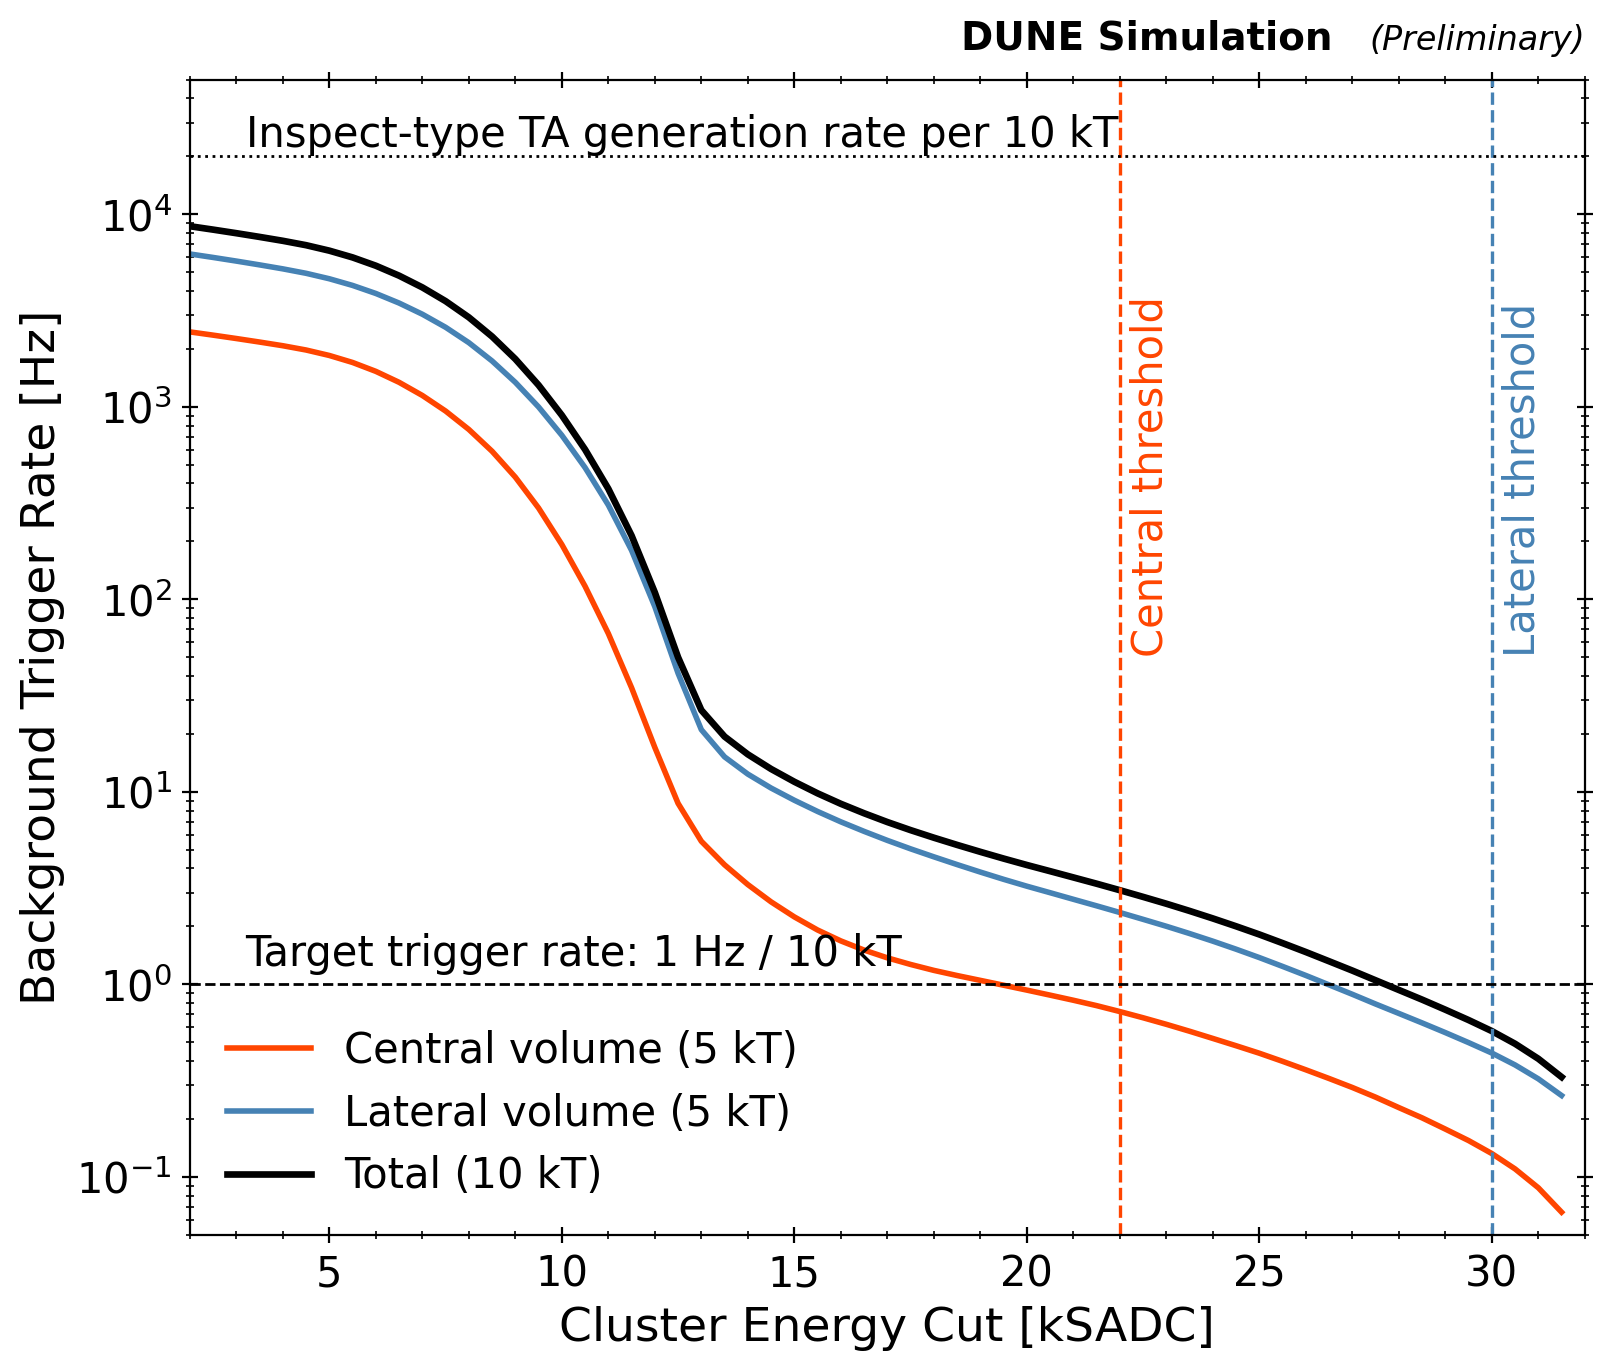

In [6]:
def GetFakeRatevsClustCut(df, volume='central', cluster_cut = 15e3 ):
    livetime =1
    if (volume =='central'):    livetime = central_livetime
    elif (volume=='lateral'):   livetime = lateral_livetime
    else :
        return 0
    fakes = df[df.max_cluster_energy > cluster_cut].TAid_u.nunique()
    fake_rate = fakes/livetime

    return fake_rate #in Hz


cuts = np.arange(2e3, 32e3, 0.5e3)
TAcen_fakes = [GetFakeRatevsClustCut(TAcen, cluster_cut=cut) for cut in cuts]
TAlat_fakes = [GetFakeRatevsClustCut(TAlat, volume='lateral', cluster_cut=cut) for cut in cuts]


TAcen_s = savgol_filter(TAcen_fakes, 9, 1)
TAlat_s = savgol_filter(TAlat_fakes, 9, 1)
TAtot_s = np.array(TAcen_s) + np.array(TAlat_s)

fig, ax = plt.subplots(figsize=(9, 7.5), dpi=200)

c_central ='orangered'
c_lateral = 'steelblue'
fs =15

ax.plot(cuts/1e3, TAcen_s, lw=2.0, color=c_central, label='Central volume (5 kT)')
ax.plot(cuts/1e3, TAlat_s, lw=2.0, color=c_lateral, label='Lateral volume (5 kT)')
ax.plot(cuts/1e3, TAtot_s, lw=2.4, color='k', label='Total (10 kT)')

ax.axvline(22, ls='--', lw=1.2, color=c_central)
ax.axvline(30, ls='--', lw=1.2, color=c_lateral)

ax.text(22.2, 0.5e2, 'Central threshold', rotation=90, color=c_central, fontsize=fs, va='bottom')
ax.text(30.2, 0.5e2, 'Lateral threshold', rotation=90,color=c_lateral, fontsize=fs, va='bottom')

ax.axhline(1, color='k', ls='--', lw=1)
ax.text(3.2, 1.25, 'Target trigger rate: 1 Hz / 10 kT', fontsize=fs)

ax.axhline(2e4, color='k', ls=':', lw=1)
ax.text(3.2, 2.25e4, 'Inspect-type TA generation rate per 10 kT', fontsize=fs)

ax.set_xlabel('Cluster Energy Cut [kSADC]', fontsize =fs+2)
ax.set_ylabel('Background Trigger Rate [Hz]', fontsize = fs+2)
ax.set_yscale('log')
ax.set_xlim(2, 32)
ax.set_ylim(0.05, 5e4)
ax.tick_params(axis='both', labelsize=fs)

ax.minorticks_on()
ax.tick_params(axis='both', which='both', direction='inout', top=True, right=True, length =3)
ax.tick_params(axis='both', which='major', direction='inout', top=True, right=True, length =6)
ax.legend(frameon=False, loc='lower left', fontsize =fs)

fig.text(0.76, 0.9, 'DUNE Simulation', ha='right',fontsize=14, fontweight='bold')
fig.text(0.9, 0.9, '(Preliminary)', ha='right',fontsize=12, style='italic')
plt.savefig("./figures/ta_rates_vs_cluster_energy.png")

plt.show()


# Single Particle Efficiencies

/var/folders/1s/mfxsnwp9275ft3r75z4zs6c80000gn/T/ipykernel_2842/4005490262.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


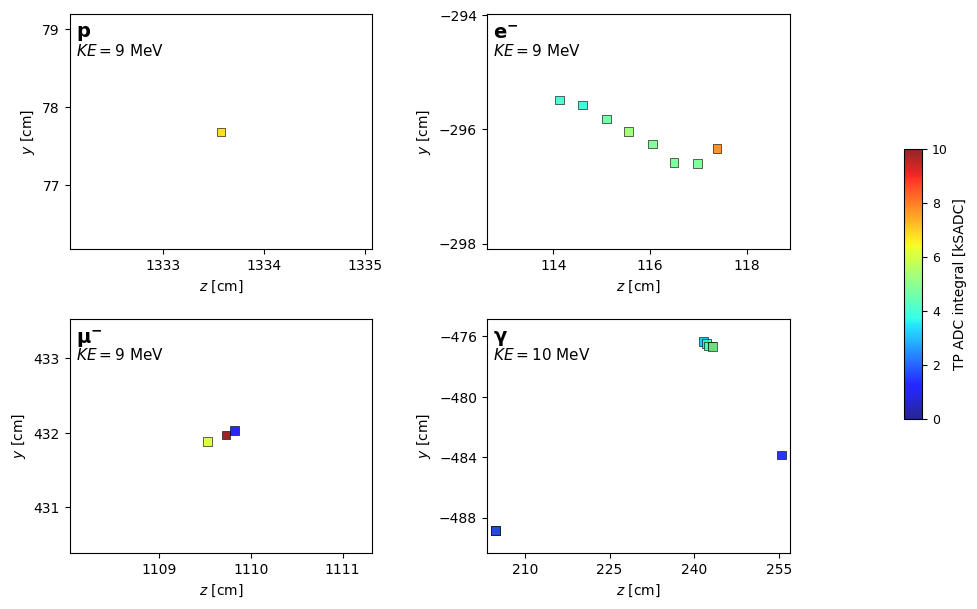

In [7]:

from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec

PARTICLE_LATEX = {"gamma": r"\gamma", "e": r"e^{-}", "mu": r"\mu^{-}", "p": r"p"}

def plot_particle_event(ax, particle, ke_min=9, ke_max=11, cmap="jet"):
    mc = pd.read_pickle(f"./singles/single_{particle}_mc.pkl")
    tps = pd.read_pickle(f"./singles/single_{particle}_tps.pkl")
    util.get_unique_event_ids(mc)
    util.get_unique_event_ids(tps)
    evt = mc.loc[(mc.kinetic_energy * 1000 > ke_min) & (mc.kinetic_energy * 1000 < ke_max) & (np.abs(mc.pz / mc.p) > 0.8), "event_uid"].iloc[1]
    x = tps[tps.event_uid == evt]
    ke_mev = mc.loc[mc.event_uid == evt, "kinetic_energy"].iloc[0] * 1000
    sc = ax.scatter(x.bt_z, x.bt_y, s=40, c=x.adc_integral/1e3 if "adc_integral" in x else None, cmap=cmap, alpha=0.85, linewidths=0.5, vmin=0, vmax=10, edgecolor='k',  marker="s")
    ax.set_xlabel(r"$z\ \mathrm{[cm]}$")
    ax.set_ylabel(r"$y\ \mathrm{[cm]}$")
    ax.set_aspect("auto")
    ax.set_xlim(x.bt_z.min() - 1.5, x.bt_z.max() + 1.5)
    ax.set_ylim(x.bt_y.min() - 1.5, x.bt_y.max() + 1.5)
    ax.text(0.02, 0.96, rf"$\mathbf{{{PARTICLE_LATEX[particle]}}}$", transform=ax.transAxes, ha="left", va="top", fontsize=14)
    ax.text(0.02, 0.88, rf"$KE = {ke_mev:.0f}\ \mathrm{{MeV}}$", transform=ax.transAxes, ha="left", va="top", fontsize=11)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4, integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4, integer=True))
    return sc

fig = plt.figure(figsize=(11, 7), dpi =100)
gs = GridSpec(2, 3, width_ratios=[1, 1, 0.06], wspace=0.55, hspace=0.3)

axs = np.array([[fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])],
                [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]])

cax = fig.add_subplot(gs[:, 2])

particles = ["p", "e", "mu", "gamma"]
sc = None
for ax, p in zip(axs.ravel(), particles):
    sc = plot_particle_event(ax, p)

cbar = fig.colorbar(sc, cax=cax)
pos = cax.get_position()
new_height = pos.height * 0.5
new_y0 = pos.y0 + (pos.height - new_height) / 2
cax.set_position([pos.x0, new_y0, pos.width, new_height])

cbar.set_label(r"TP ADC integral [kSADC]")
cbar.ax.tick_params(labelsize=9)
plt.tight_layout()
plt.show()


In [8]:
#load the single particle pkl data. e.g. for a given particle saved only mctruth and collection tp info (after filtering) : p_mc and p_tps (total visible energy saved in eventsum pkls)

for data_type in ["mc", "tps", "eventsum"]:
    for part in ["p", "e", "gamma", "mu"]:
        globals()[f"{part}_{data_type}"] = pd.read_pickle(f"./singles/single_{part}_{data_type}.pkl")

        #get unique event IDs
        util.get_unique_event_ids(globals()[f"{part}_{data_type}"])
        #make sure all the dfs are sorted by the unique event IDs --> important when merging multiple dfs. later on 
        globals()[f"{part}_{data_type}"] = globals()[f"{part}_{data_type}"].sort_values(by="event_uid")
        
generate_tas = False
if generate_tas:

    #visible energy from both ROP planes 
    for part in ["p", "e", "gamma", "mu"]:
        globals()[f"{part}_eventsum"]['visible_energy'] =  globals()[f"{part}_eventsum"]['tot_visible_energy_rop2']  +  globals()[f"{part}_eventsum"]['tot_visible_energy_rop3']

    for part in ["p", "e", "gamma", "mu"]:
        print("\n" + f"generating central APA efficiencies for single {part}")
        globals()[f"cTPs_{part}"] , globals()[f"cTAs_{part}"]  = util.GenerateTAs(globals()[f"{part}_tps"])
        print("\n" + f"generating lateral APA efficiencies for single {part}")
        globals()[f"lTPs_{part}"] , globals()[f"lTAs_{part}"]  = util.GenerateTAs(globals()[f"{part}_tps"], **lat_params, )

    #generate dfs which will easily allow to plot trigger efficiency based on TA info and visible energy for the event.
    for part in ["p", "e", "gamma", "mu"]:
        cTAs_part = globals().get(f"cTAs_{part}")
        lTAs_part = globals().get(f"lTAs_{part}")

        eventsum_part = globals().get(f"{part}_eventsum")
        
        if cTAs_part is not None and eventsum_part is not None and {'event', 'run'}.issubset(cTAs_part.columns) and {'event', 'run'}.issubset(eventsum_part.columns):
            globals()[f"trig_{part}_cent"] = pd.merge(cTAs_part, eventsum_part[['event', 'run', 'visible_energy', 'event_uid']], on=['event', 'run'], how='right').fillna(-1)

        if lTAs_part is not None and eventsum_part is not None and {'event', 'run'}.issubset(lTAs_part.columns) and {'event', 'run'}.issubset(eventsum_part.columns):
            globals()[f"trig_{part}_lat"] = pd.merge(lTAs_part, eventsum_part[['event', 'run', 'visible_energy', 'event_uid']], on=['event', 'run'],  how='right').fillna(-1)

    for part in ["p", "e", "gamma", "mu"]:
        globals()[f"trig_{part}_cent"].to_pickle(f"./trigger_data/{part}_TAs_cbgd.pkl")
        globals()[f"trig_{part}_lat"].to_pickle(f"./trigger_data/{part}_TAs_lbgd.pkl")

        globals()[f"lTPs_{part}"].to_pickle(f"./trigger_data/{part}_TPs_lbgd.pkl")
        globals()[f"cTPs_{part}"].to_pickle(f"./trigger_data/{part}_TPs_cbgd.pkl")
        
else:
    #load  previously generated TA data 
    for part in ["p", "e", "gamma", "mu"]:
        globals()[f"trig_{part}_cent"]=pd.read_pickle(f"./trigger_data/{part}_TAs_cbgd.pkl")
        globals()[f"trig_{part}_lat"]=pd.read_pickle(f"./trigger_data/{part}_TAs_lbgd.pkl")

        globals()[f"lTPs_{part}"]= pd.read_pickle(f"./trigger_data/{part}_TPs_lbgd.pkl")
        globals()[f"cTPs_{part}"]= pd.read_pickle(f"./trigger_data/{part}_TPs_cbgd.pkl")



Proton
                  50%        75%        90%
-------------------------------------------
Lateral         23.5      24.4      25.4
Central         19.4      20.3      21.2
Mean            21.3      23.5      24.7

Electron
                  50%        75%        90%
-------------------------------------------
Lateral          8.1       8.9       9.6
Central          6.0       6.8       7.5
Mean             7.0       8.2       9.1

Muon
                  50%        75%        90%
-------------------------------------------
Lateral         17.8      24.8      32.2
Central         14.6      20.4      26.7
Mean            16.1      22.6      29.7


/var/folders/1s/mfxsnwp9275ft3r75z4zs6c80000gn/T/ipykernel_2842/31844324.py:27: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0))) + b



Gamma
                  50%        75%        90%
-------------------------------------------
Lateral          9.6      11.2      12.9
Central          7.4       8.8      10.2
Mean             8.4      10.2      11.9


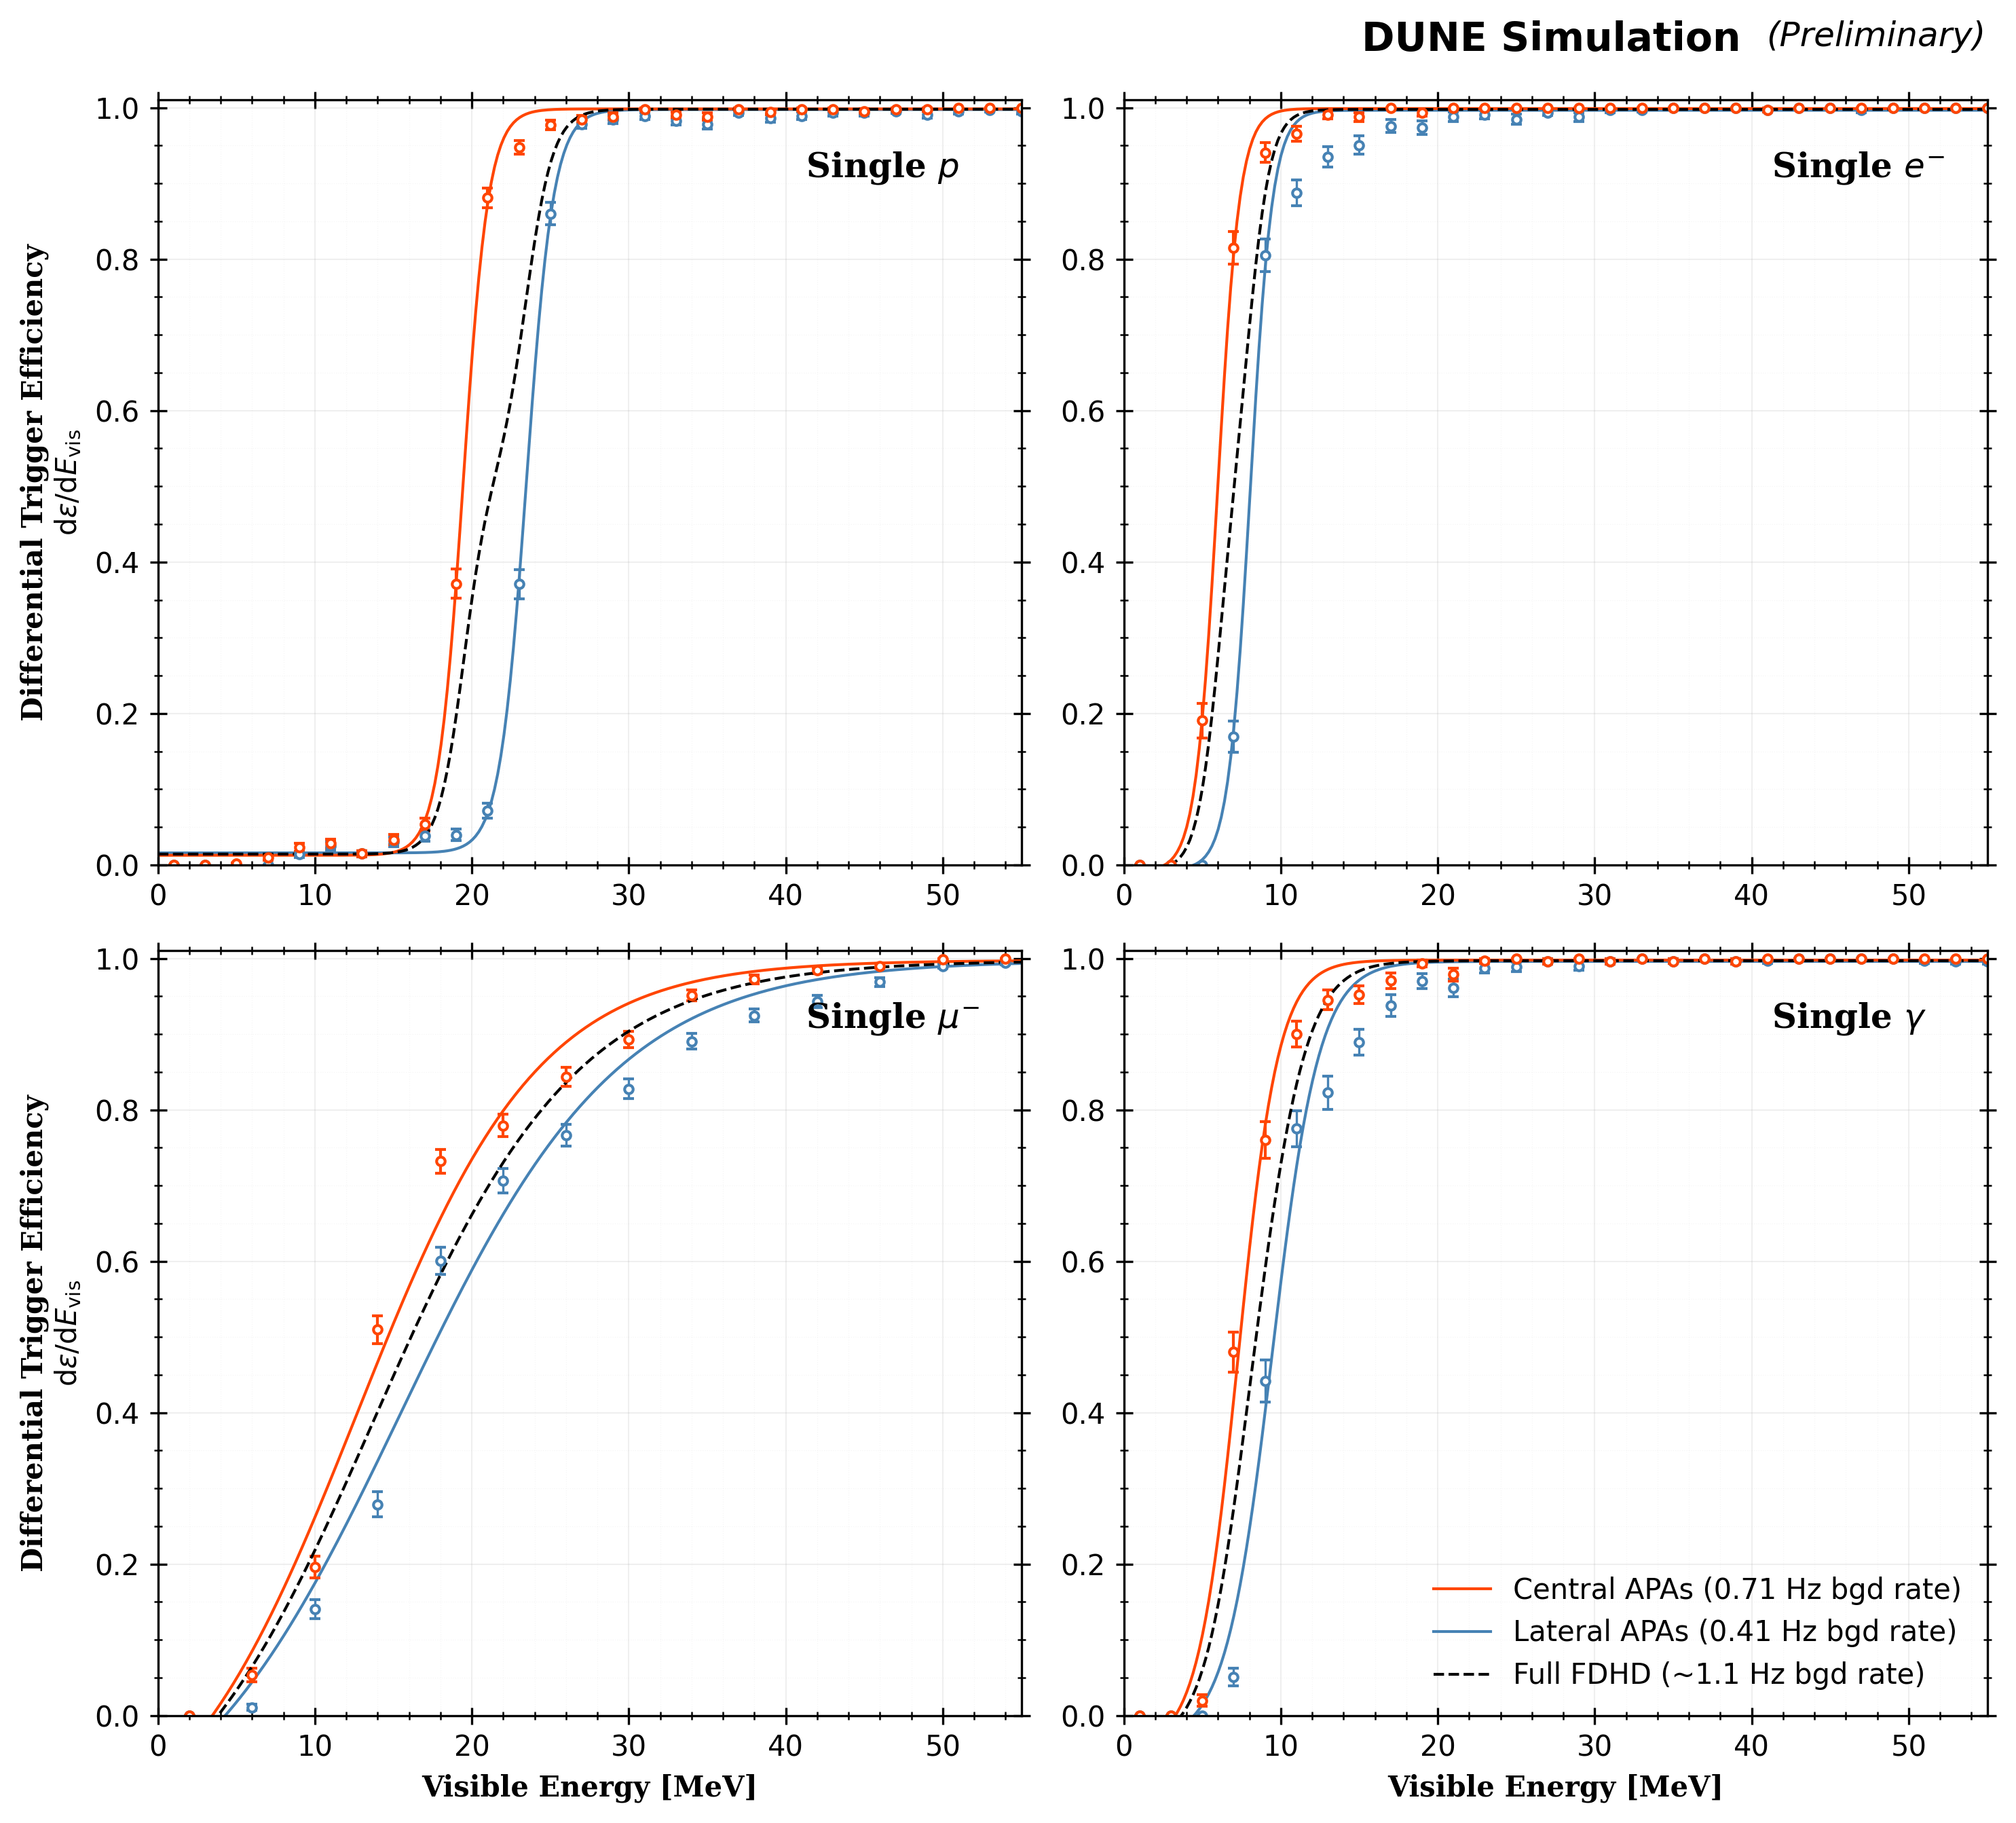

In [9]:
def energies_at_efficiency(x, y, levels=(0.5, 0.75, 0.9)):
    y_max = np.nanmax(y)
    return {int(lvl * 100): (np.interp(lvl, y, x) if y_max >= lvl else np.nan)for lvl in levels}

def print_efficiency_table(title, results, units="MeV", precision=1):
    efficiencies = sorted(next(iter(results.values())).keys())

    header = " " * 10 + "".join(f"{e:>10}%" for e in efficiencies)
    print(f"\n{title}")
    print(header)
    print("-" * len(header))

    # Rows
    for label, values in results.items():
        row = f"{label:<10}"
        for e in efficiencies:
            val = values[e]
            cell = f"{val:.{precision}f}" if np.isfinite(val) else "NaN"
            row += f"{cell:>10}"
        print(row)


    
from scipy.optimize import curve_fit

def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

data_lat = [trig_p_lat, trig_e_lat, trig_mu_lat, trig_gamma_lat]
data_cent = [trig_p_cent, trig_e_cent, trig_mu_cent, trig_gamma_cent]
labels = ['proton', 'electron', 'muon', 'gamma']
symbol_map = {
    'proton': r'p',
    'electron': r'e^{-}',
    'muon': r'\mu^{-}',
    'gamma': r'\gamma'
}


fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=300, sharex=False, sharey=False)
axs = axs.flatten()

lines_for_legend = []

for idx, ax in enumerate(axs):
    dx_lat = 2
    dx_cent = 2

    if idx==2:
        dx_lat = 4
        dx_cent =4


    max_eng = 200

    energies_lat = np.arange(0, max_eng, dx_lat)
    bin_centers_lat = energies_lat[:-1] + dx_lat / 2

    energies_cent = np.arange(0, max_eng, dx_cent)
    bin_centers_cent = energies_cent[:-1] + dx_cent / 2

    sensitivity_lat = []
    errors_lat = []
    df_lat = data_lat[idx]
    for energy_start in energies_lat[:-1]:
        upper = energy_start + dx_lat
        events_in_bin = df_lat[(df_lat.visible_energy >= energy_start) & (df_lat.visible_energy < upper)]
        accepted_events_in_bin = events_in_bin[events_in_bin.flag == 2]

        n = events_in_bin.event_uid.nunique()
        k = accepted_events_in_bin.event_uid.nunique()

        if n > 0:
            sens = k / n
            err = np.sqrt(sens * (1 - sens) / n)
        else:
            sens = np.nan
            err = 0

        sensitivity_lat.append(sens)
        errors_lat.append(err)

    sensitivity_cent = []
    errors_cent = []
    df_cent = data_cent[idx]
    for energy_start in energies_cent[:-1]:
        upper = energy_start + dx_cent
        events_in_bin = df_cent[(df_cent.visible_energy >= energy_start) & (df_cent.visible_energy < upper)]
        accepted_events_in_bin = events_in_bin[events_in_bin.flag == 2]

        n = events_in_bin.event_uid.nunique()
        k = accepted_events_in_bin.event_uid.nunique()

        if n > 0:
            sens = k / n
            err = np.sqrt(sens * (1 - sens) / n)
        else:
            sens = np.nan
            err = 0

        sensitivity_cent.append(sens)
        errors_cent.append(err)

    try:
        popt_lat, _ = curve_fit(sigmoid, bin_centers_lat, sensitivity_lat, p0=[1, 10, 1, 0], maxfev=100000)
    except:
        popt_lat = [1, 10, 1, 0]
    try:
        popt_cent, _ = curve_fit(sigmoid, bin_centers_cent, sensitivity_cent, p0=[1, 10, 1, 0], maxfev=100000)
    except:
        popt_cent = [1, 10, 1, 0]

    x_fit = np.linspace(0, 100, 500)
    y_fit_lat = sigmoid(x_fit, *popt_lat)
    y_fit_cent = sigmoid(x_fit, *popt_cent)

    y_fit_mean = (y_fit_lat + y_fit_cent) / 2

    ax.errorbar(bin_centers_lat, sensitivity_lat, yerr=errors_lat, fmt='o', capsize=2, markersize=3, markerfacecolor='white', elinewidth=0.8, color=cl)
    line_lat, = ax.plot(x_fit, y_fit_lat, color=cl, linewidth=1)

    ax.errorbar(bin_centers_cent, sensitivity_cent, yerr=errors_cent, fmt='o', capsize=2, markersize=3, markerfacecolor='white', elinewidth=1, color=cc)
    line_cent, = ax.plot(x_fit, y_fit_cent, color=cc, linewidth=1)

    line_mean, = ax.plot(x_fit, y_fit_mean, color='black', linewidth=1, linestyle='--')

    eff_lat = energies_at_efficiency(x_fit, y_fit_lat)
    eff_cent = energies_at_efficiency(x_fit, y_fit_cent)
    eff_mean = energies_at_efficiency(x_fit, y_fit_mean)


    levels = (0.5, 0.75, 0.9)
    results = {
        "Lateral": energies_at_efficiency(x_fit, y_fit_lat, levels),
        "Central": energies_at_efficiency(x_fit, y_fit_cent, levels),
        "Mean":    energies_at_efficiency(x_fit, y_fit_mean, levels), }
    print_efficiency_table(labels[idx].capitalize(), results)



    if idx == 0:
        lines_for_legend = [line_cent, line_lat, line_mean]


    ax.set_xlim(0, 55)
    ax.set_ylim(0, 1.01)
    ax.minorticks_on()

    ax.tick_params(axis='both', which='both', direction='inout', top=True, right=True, length =3)
    ax.tick_params(axis='both', which='major', direction='inout', top=True, right=True, length =6)

    ax.grid(True, which='major', linestyle='-', linewidth=0.5, alpha=0.2)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.3, alpha=0.1 )
    ax.text(0.75, 0.90, r"Single $" + symbol_map[labels[idx]] + r"$", transform=ax.transAxes, fontsize=12, fontweight='bold', family='serif')


for ax in axs[-2:]:
    ax.set_xlabel("Visible Energy [MeV]", fontweight='bold', family='serif')

for ax in axs[::2]:
    ax.set_ylabel(r"Differential Trigger Efficiency" + "\n" + r"$\mathrm{d}\varepsilon / \mathrm{d}E_\mathrm{vis}$",  fontweight='bold',  family='serif')

#fig.suptitle("FDHD Single Particle Trigger Efficiencies", fontweight='bold', family='serif', y=0.89)



axs[3].legend(lines_for_legend,
           [f'Central APAs ({central_fake_rate:.2g} Hz bgd rate)', f'Lateral APAs ({lateral_fake_rate:.2g} Hz bgd rate)', f'Full FDHD (~{total_fake_rate:.2g} Hz bgd rate)'],
           ncol=1, fontsize=10, loc='lower right', frameon=False)#, title='DUNE Simulation (preliminary)', title_fontproperties={'weight': 'bold', 'family': 'serif'})
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
fig.text(
    0.86, 0.92,
    r"DUNE Simulation", ha='right', va='top',
    fontsize=14, fontweight='bold'
)

fig.text(
    0.98, 0.92,
    r"(Preliminary)", ha='right', va='top',
    fontsize=12, style='italic'
)
plt.savefig("./figures/singles_eff_vs_viseng1.png")

plt.show()



Proton
                  50%        75%        90%
-------------------------------------------
Lateral         23.6      24.4      25.3
Central         19.5      20.5      21.4
Mean            21.7      23.6      24.7

Electron
                  50%        75%        90%
-------------------------------------------
Lateral          8.1       9.0       9.8
Central          5.8       6.4       7.0
Mean             6.8       8.2       9.2

Muon
                  50%        75%        90%
-------------------------------------------
Lateral         11.2      12.3      13.2
Central          8.9      10.0      10.9
Mean             9.7      11.4      12.6

Gamma
                  50%        75%        90%
-------------------------------------------
Lateral          9.6      11.2      12.9
Central          7.4       8.7      10.2
Mean             8.4      10.2      11.9


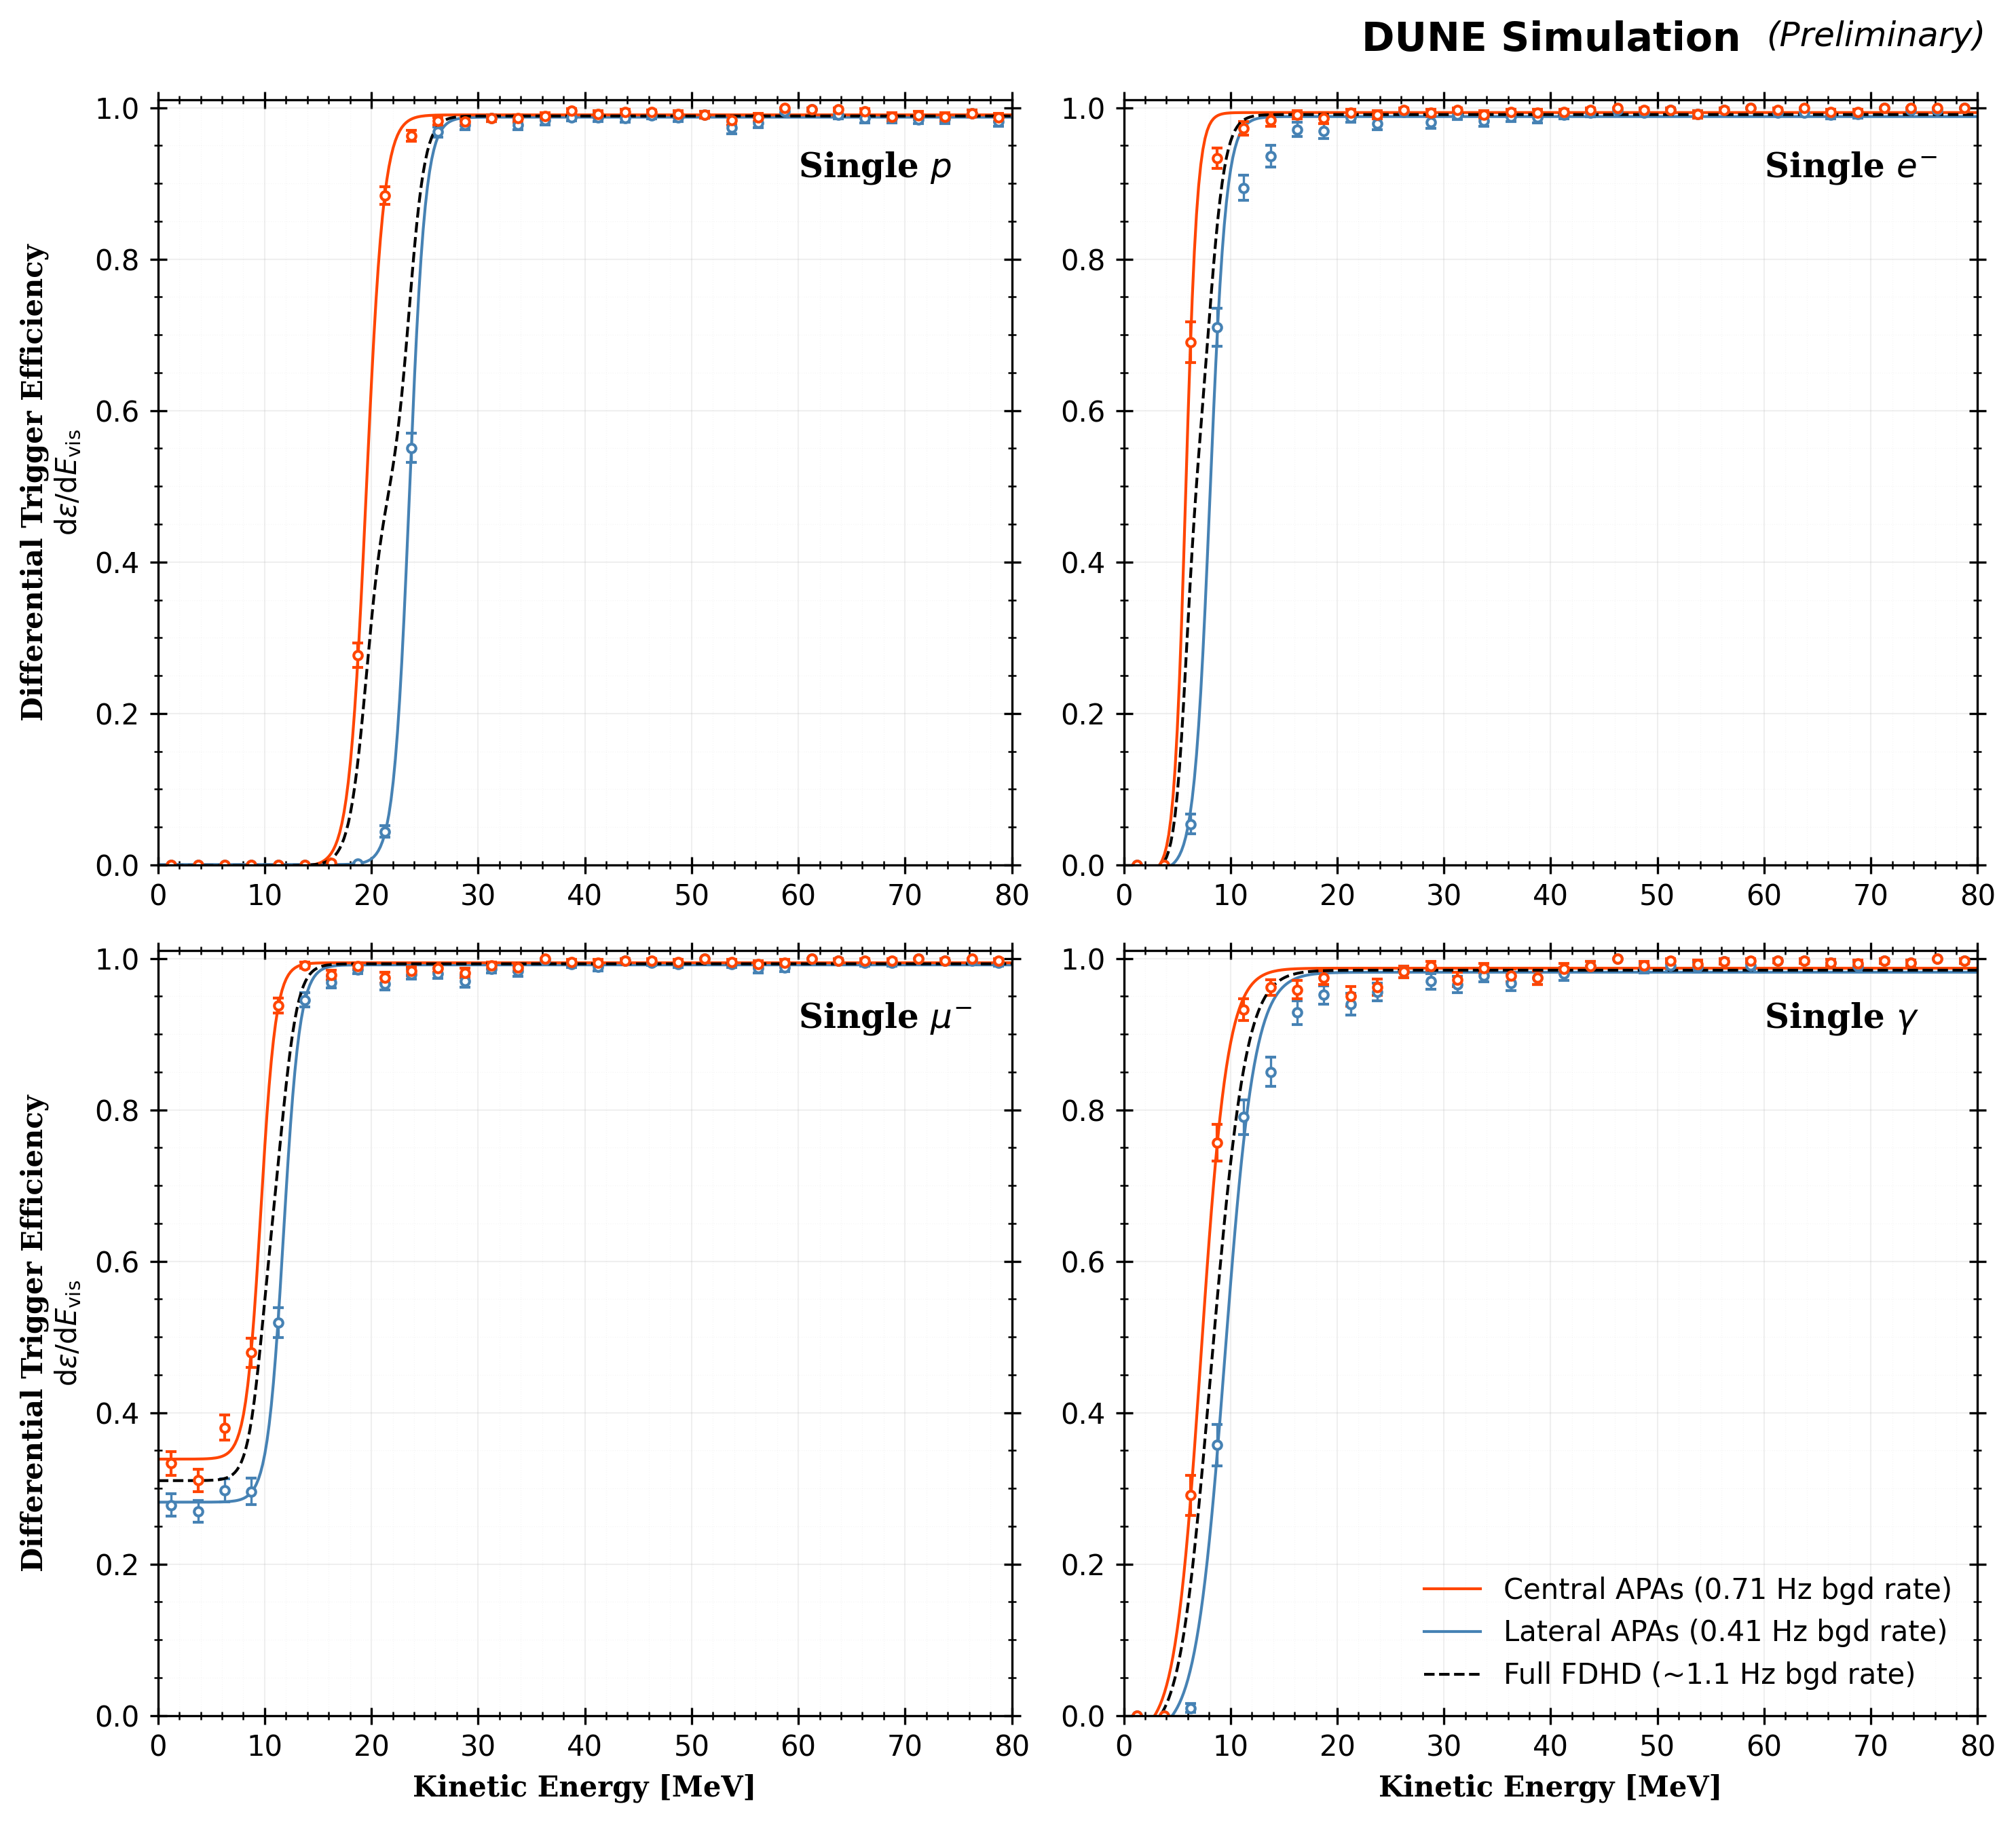

In [10]:
# Same plots but in terms of kinetic energy 

mc_cols = ['kinetic_energy', 'x', 'y', 'z', 'event_uid']
for part in ["p", "e", "gamma", "mu"]:
    mc = globals()[f"{part}_mc"]
    trig_lat = globals()[f"trig_{part}_lat"].drop(columns=[c for c in mc_cols if c in globals()[f"trig_{part}_lat"].columns])
    trig_cent = globals()[f"trig_{part}_cent"].drop(columns=[c for c in mc_cols if c in globals()[f"trig_{part}_cent"].columns])
    globals()[f"trig_{part}_cent_mc"] = pd.merge(trig_cent, mc[['event','run'] + mc_cols], on=['event','run'], how='right').fillna(-1)
    globals()[f"trig_{part}_lat_mc"] = pd.merge(trig_lat, mc[['event','run'] + mc_cols], on=['event','run'], how='right').fillna(-1)


#Plotting 

from scipy.optimize import curve_fit

def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

data_lat = [trig_p_lat_mc, trig_e_lat_mc, trig_mu_lat_mc, trig_gamma_lat_mc]
data_cent = [trig_p_cent_mc, trig_e_cent_mc, trig_mu_cent_mc, trig_gamma_cent_mc]

def GetEventsInActiveVol(df):
    return df[ (df.x.abs() < 360 ) & (df.y.abs() < 600-10 )  & ((df.z > 0) &  (df.z < 1380) ) & (df.visible_energy > 2)]

labels = ['proton', 'electron', 'muon', 'gamma']
symbol_map = {
    'proton': r'p',
    'electron': r'e^{-}',
    'muon': r'\mu^{-}',
    'gamma': r'\gamma'
}


fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=300, sharex=False, sharey=False)
axs = axs.flatten()

lines_for_legend = []

for idx, ax in enumerate(axs):
    dx_lat = 2.5
    dx_cent = 2.5


    max_eng = 100

    energies_lat = np.arange(0, max_eng, dx_lat)
    bin_centers_lat = energies_lat[:-1] + dx_lat / 2

    energies_cent = np.arange(0, max_eng, dx_cent)
    bin_centers_cent = energies_cent[:-1] + dx_cent / 2

    sensitivity_lat = []
    errors_lat = []
    df_lat = data_lat[idx]
    #use only particles with vertices in the active volume for the trigger curves
    df_lat = GetEventsInActiveVol(df_lat)

    for energy_start in energies_lat[:-1]:
        upper = energy_start + dx_lat
        events_in_bin = df_lat[(df_lat.kinetic_energy * 1000 >= energy_start) & (df_lat.kinetic_energy * 1000 < upper)]
        accepted_events_in_bin = events_in_bin[events_in_bin.flag == 2]

        n = events_in_bin.event_uid.nunique()
        k = accepted_events_in_bin.event_uid.nunique()

        if n > 0:
            sens = k / n
            err = np.sqrt(sens * (1 - sens) / n)
        else:
            sens = np.nan
            err = 0

        sensitivity_lat.append(sens)
        errors_lat.append(err)

    sensitivity_cent = []
    errors_cent = []
    df_cent = data_cent[idx]
    #use only particles with vertices in the active volume for the trigger curves
    df_cent = GetEventsInActiveVol(df_cent)

    for energy_start in energies_cent[:-1]:
        upper = energy_start + dx_cent
        events_in_bin = df_cent[(df_cent.kinetic_energy * 1000 >= energy_start) & (df_cent.kinetic_energy *1000 < upper)]
        accepted_events_in_bin = events_in_bin[events_in_bin.flag == 2]

        n = events_in_bin.event_uid.nunique()
        k = accepted_events_in_bin.event_uid.nunique()

        if n > 0:
            sens = k / n
            err = np.sqrt(sens * (1 - sens) / n)
        else:
            sens = np.nan
            err = 0

        sensitivity_cent.append(sens)
        errors_cent.append(err)

    try:
        popt_lat, _ = curve_fit(sigmoid, bin_centers_lat, sensitivity_lat, p0=[1, 10, 1, 0], maxfev=100000)
    except:
        popt_lat = [1, 10, 1, 0]
    try:
        popt_cent, _ = curve_fit(sigmoid, bin_centers_cent, sensitivity_cent, p0=[1, 10, 1, 0], maxfev=100000)
    except:
        popt_cent = [1, 10, 1, 0]

    x_fit = np.linspace(0, 100, 500)
    y_fit_lat = sigmoid(x_fit, *popt_lat)
    y_fit_cent = sigmoid(x_fit, *popt_cent)

    y_fit_mean = (y_fit_lat + y_fit_cent) / 2

    levels = (0.5, 0.75, 0.9)
    results = {
        "Lateral": energies_at_efficiency(x_fit, y_fit_lat, levels),
        "Central": energies_at_efficiency(x_fit, y_fit_cent, levels),
        "Mean":    energies_at_efficiency(x_fit, y_fit_mean, levels), }
    print_efficiency_table(labels[idx].capitalize(), results)


    ax.errorbar(bin_centers_lat, sensitivity_lat, yerr=errors_lat, fmt='o', capsize=2, markersize=3, markerfacecolor='white', elinewidth=0.8, color=cl)
    line_lat, = ax.plot(x_fit, y_fit_lat, color=cl, linewidth=1)

    ax.errorbar(bin_centers_cent, sensitivity_cent, yerr=errors_cent, fmt='o', capsize=2, markersize=3, markerfacecolor='white', elinewidth=1, color=cc)
    line_cent, = ax.plot(x_fit, y_fit_cent, color=cc, linewidth=1)

    line_mean, = ax.plot(x_fit, y_fit_mean, color='black', linewidth=1, linestyle='--')

    if idx == 0:
        lines_for_legend = [line_cent, line_lat, line_mean]


    ax.set_xlim(0, 80)
    ax.set_ylim(0, 1.01)
    ax.minorticks_on()

    ax.tick_params(axis='both', which='both', direction='inout', top=True, right=True, length =3)
    ax.tick_params(axis='both', which='major', direction='inout', top=True, right=True, length =6)

    ax.grid(True, which='major', linestyle='-', linewidth=0.5, alpha=0.2)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.3, alpha=0.1 )
    ax.text(0.75, 0.90, r"Single $" + symbol_map[labels[idx]] + r"$", transform=ax.transAxes, fontsize=12, fontweight='bold', family='serif')


for ax in axs[-2:]:
    ax.set_xlabel("Kinetic Energy [MeV]", fontweight='bold', family='serif')

for ax in axs[::2]:
    ax.set_ylabel(r"Differential Trigger Efficiency" + "\n" + r"$\mathrm{d}\varepsilon / \mathrm{d}E_\mathrm{vis}$",  fontweight='bold',  family='serif')



axs[3].legend(lines_for_legend,
           [f'Central APAs ({central_fake_rate:.2g} Hz bgd rate)', f'Lateral APAs ({lateral_fake_rate:.2g} Hz bgd rate)', f'Full FDHD (~{total_fake_rate:.2g} Hz bgd rate)'],
           ncol=1, fontsize=10, loc='lower right', frameon=False)#, title='DUNE Simulation (preliminary)', title_fontproperties={'weight': 'bold', 'family': 'serif'})
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
fig.text(
    0.86, 0.92,
    r"DUNE Simulation", ha='right', va='top',
    fontsize=14, fontweight='bold'
)

fig.text(
    0.98, 0.92,
    r"(Preliminary)", ha='right', va='top',
    fontsize=12, style='italic'
)
plt.savefig("./figures/singles_eff_vs_ekin.png")

plt.show()


# Beam Neutrinos

In [11]:
#Concat beam TAs - only needs to be done once 
'''
from pathlib import Path

folder = Path( "./trigger_data/beam_chunks")

for part in ['nue', 'numu']:
    for bgd in ['lbgd','cbgd']:
        files = folder.glob(f"{part}_TAs_{bgd}*.pkl")

        dfs = []

        for f in files:
            df = pd.read_pickle(f)
            dfs.append(df)

        trig_df = pd.concat(dfs, ignore_index = True)
        trig_df.to_pickle(f"./trigger_data/beamTAs_{part}_{bgd}.pkl")


for data_type in ['sum', 'nu', 'mc']:
    folder = Path(f"./beam/chunks/{data_type}")

    for part in ['nue', 'numu']:
        files = folder.glob(f"genie_{part}*")
        dfs = []

        for f in files:
            df = pd.read_pickle(f)
            util.util.get_unique_event_ids(df)
            dfs.append(df)
        trig_df = pd.concat(dfs, ignore_index = True)
        trig_df.to_pickle(f"./beam/genie_{part}_{data_type}.pkl")
 '''


'\nfrom pathlib import Path\n\nfolder = Path( "./trigger_data/beam_chunks")\n\nfor part in [\'nue\', \'numu\']:\n    for bgd in [\'lbgd\',\'cbgd\']:\n        files = folder.glob(f"{part}_TAs_{bgd}*.pkl")\n\n        dfs = []\n\n        for f in files:\n            df = pd.read_pickle(f)\n            dfs.append(df)\n\n        trig_df = pd.concat(dfs, ignore_index = True)\n        trig_df.to_pickle(f"./trigger_data/beamTAs_{part}_{bgd}.pkl")\n\n\nfor data_type in [\'sum\', \'nu\', \'mc\']:\n    folder = Path(f"./beam/chunks/{data_type}")\n\n    for part in [\'nue\', \'numu\']:\n        files = folder.glob(f"genie_{part}*")\n        dfs = []\n\n        for f in files:\n            df = pd.read_pickle(f)\n            util.util.get_unique_event_ids(df)\n            dfs.append(df)\n        trig_df = pd.concat(dfs, ignore_index = True)\n        trig_df.to_pickle(f"./beam/genie_{part}_{data_type}.pkl")\n '

In [12]:
#Load MC beam info 
for data_type in ["mc", "nu", "sum"]:
    for part in ["nue", "numu"]:
        globals()[f"{part}_{data_type}"] = pd.read_pickle(f"./beam/genie_{part}_{data_type}.pkl")
        #get_unique_event_ids(globals()[f"{part}_{data_type}"])
        globals()[f"{part}_{data_type}"] = globals()[f"{part}_{data_type}"].sort_values(by="event_uid")

#Load TAs
for part in ["nue", "numu"]:
    globals()[f"trig_{part}_cent"] = pd.read_pickle(f"./trigger_data/beamTAs_{part}_cbgd.pkl")
    globals()[f"trig_{part}_lat"] = pd.read_pickle(f"./trigger_data/beamTAs_{part}_lbgd.pkl")

    nu = globals()[f"{part}_nu"]
    mc = globals()[f"{part}_mc"]

    if part == "nue":
            mc = mc[(mc.pdg==12) & (mc.status_code==0)]
    else:
         mc =mc[(mc.pdg==14) & (mc.status_code==0)]

    globals()[f"trig_beam_{part}_lat"] = pd.merge(globals()[f"trig_{part}_lat"], nu[['event','run','mode','ccnc']], on=['event','run'], how='inner')
    globals()[f"trig_beam_{part}_cent"] = pd.merge(globals()[f"trig_{part}_cent"], nu[['event','run','mode','ccnc']], on=['event','run'], how='inner')

    globals()[f"trig_beam_{part}_lat"] = pd.merge(globals()[f"trig_beam_{part}_lat"], mc[['event','run','energy','x', 'y', 'z']], on=['event','run'], how='inner')
    globals()[f"trig_beam_{part}_cent"] = pd.merge(globals()[f"trig_beam_{part}_cent"], mc[['event','run','energy','x', 'y', 'z']], on=['event','run'], how='inner')


print("number of nu_e beam events: ", nue_sum.event_uid.nunique())
print("number of nu_mu beam events: ", numu_sum.event_uid.nunique())


    
display(trig_beam_nue_lat)

number of nu_e beam events:  94760
number of nu_mu beam events:  98620


event   tpc  window_start  flag    TA_id  total_window_energy  \
0       62661.0  20.0        2000.0   2.0      3.0         6.703620e+06   
1       62661.0  20.0        3000.0   2.0      4.0         1.163505e+06   
2       62661.0  22.0        2000.0   0.0      9.0         1.826968e+04   
3       62661.0  20.0        4000.0   0.0      5.0         2.340523e+04   
4       62661.0  20.0        1000.0   0.0      2.0         7.479735e+04   
...         ...   ...           ...   ...      ...                  ...   
418956  57619.0  20.0        2000.0   0.0  23845.0         1.913573e+04   
418957  57619.0  22.0        1000.0   0.0  23847.0         5.872816e+04   
418958  57619.0  22.0        3000.0   0.0  23848.0         1.698681e+04   
418959  57619.0  23.0        1000.0   2.0  23850.0         9.043168e+04   
418960  57620.0   2.0        2000.0   2.0  23851.0         2.141519e+06   

        TP_count  n_clusters  mean_cluster_energy total_cluster_energy  \
0          445.0        -1.0                 -1.0                   -1   
1          170.0        -1.0                 -1.0                   -1   
2            4.0         2.0               7169.0                14338   
3            6.0         1.0               6955.0                 6955   
4           13.0         5.0              12142.4                60712   
...          ...         ...                  ...                  ...   
418956       4.0         2.0               6634.5                13269   
418957      11.0         4.0              11647.5                46590   
418958       3.0         1.0               9580.0                 9580   
418959      16.0         3.0              18153.0                54459   
418960     178.0        -1.0                 -1.0                   -1   

       max_cluster_energy   run  visible_energy       event_uid  mode  ccnc  \
0                      -1  8528     2683.735514  36627481162949     1     0   
1                      -1  8528     2683.735514  36627481162949     1     0   
2                    9504  8528     2683.735514  36627481162949     1     0   
3                    6955  8528     2683.735514  36627481162949     1     0   
4                   21729  8528     2683.735514  36627481162949     1     0   
...                   ...   ...             ...             ...   ...   ...   
418956               7153  8528    11149.659565  36627481157907     2     0   
418957              14451  8528    11149.659565  36627481157907     2     0   
418958               9580  8528    11149.659565  36627481157907     2     0   
418959              34235  8528    11149.659565  36627481157907     2     0   
418960                 -1  8528      794.429412  36627481157908     1     0   

           energy           x           y            z  
0        4.310564 -201.113174  -65.517233  1234.464428  
1        4.310564 -201.113174  -65.517233  1234.464428  
2        4.310564 -201.113174  -65.517233  1234.464428  
3        4.310564 -201.113174  -65.517233  1234.464428  
4        4.310564 -201.113174  -65.517233  1234.464428  
...           ...         ...         ...          ...  
418956  15.449240   -4.918258   99.956578   951.307108  
418957  15.449240   -4.918258   99.956578   951.307108  
418958  15.449240   -4.918258   99.956578   951.307108  
418959  15.449240   -4.918258   99.956578   951.307108  
418960   1.394144 -222.265734  587.777591    95.698993  

[418961 rows x 20 columns]

In [13]:
from rich.console import Console
from rich.table import Table

type_map = {'cc': 0, 'nc':1}; mode_map = {'QE': 0, 'RES': 1, 'DIS': 2, 'Coh. Prod': 3, 'not sure': 5, 'MEC' : 10}

for part in ["nue", "numu"]:
    nu = globals()[f"{part}_nu"]
    trigl =  globals()[f"trig_beam_{part}_lat"] 
    trigc =  globals()[f"trig_beam_{part}_cent"] 


    console = Console()

    counts = nu['ccnc'].value_counts()

    table = Table(show_header=True, width =50, title=f'{part}')
    for name in counts.index:
        label = next(k for k, v in type_map.items() if v == name)
        table.add_column(label, justify="center")

    row = [f"{(count / counts.sum()) * 100:.2g} %" for count in counts.values]
    table.add_row(*row)

    console.print(table)


    counts = nu['mode'].value_counts()

    table = Table(show_header=True, width =100, title=f'{part}')
    for name in counts.index:
        label = next(k for k, v in mode_map.items() if v == name)
        table.add_column(label, justify="center")
    row = [ f"{(count / counts.sum()) * 100:.2g} %"  for count in counts.values]
    table.add_row(*row)

    console.print(table)


    print("Percentage of events triggered 'out of the box' ")
    for idx , type_label in enumerate(type_map):    

        print(f"Triggered {type_label} events (lateral): " , (trigl[(trigl.ccnc==idx) & (trigl.flag==2)].event_uid.nunique()/trigl[(trigl.ccnc==idx) ].event_uid.nunique() * 100))
        print(f"Triggered {type_label} events (central): " , (trigc[(trigc.ccnc==idx) & (trigc.flag==2)].event_uid.nunique()/trigc[(trigc.ccnc==idx) ].event_uid.nunique() * 100) )

    print("Total (L): ",  int(trigl[(trigl.flag==2)].event_uid.nunique()/trigl.event_uid.nunique() * 100), ', (C):',  int(trigc[(trigc.flag==2)].event_uid.nunique()/trigc.event_uid.nunique() * 100))

    print("\n" + "Percentage of events triggered on in the active volume ")

    trigl_ac = trigl[(trigl.x.abs() <360) & (trigl.y.abs() < 600) & (trigl.z>0) & (trigl.z < 1380) & (trigl.visible_energy> 0)]
    trigc_ac = trigc[(trigc.x.abs() <360) & (trigc.y.abs() < 600) & (trigc.z>0) & (trigc.z < 1380) & (trigc.visible_energy> 0)]

    for idx , type_label in enumerate(type_map):    

        print(f"Triggered {type_label} events (lateral): " , (trigl_ac[(trigl_ac.ccnc==idx) & (trigl_ac.flag==2)].event_uid.nunique()/trigl_ac[(trigl_ac.ccnc==idx) ].event_uid.nunique() * 100))
        print(f"Triggered {type_label} events (central): " , (trigc_ac[(trigc_ac.ccnc==idx) & (trigc_ac.flag==2)].event_uid.nunique()/trigc_ac[(trigc_ac.ccnc==idx) ].event_uid.nunique() * 100) )

    print("Total (L): ",  trigl_ac[(trigl_ac.flag==2)].event_uid.nunique()/trigl_ac.event_uid.nunique() * 100, ', (C):',  trigc_ac[(trigc_ac.flag==2)].event_uid.nunique()/trigc_ac.event_uid.nunique() * 100, 
          ", 10 kT", 0.5*(trigl_ac[(trigl_ac.flag==2)].event_uid.nunique()/trigl_ac.event_uid.nunique() +trigc_ac[(trigc_ac.flag==2)].event_uid.nunique()/trigc_ac.event_uid.nunique() ) * 100)


    print("~" * 150)  # 

# Fraction of events which produced less that 100 MeV of visible energy in the active volume 
# trig_beam_nue_lat[ (trig_beam_nue_lat.visible_energy < 100) &(trig_beam_nue_lat.event_uid.isin(fv_event) &(trig_beam_nue_lat.ccnc==1))].event_uid.nunique()/trig_beam_nue_lat[(trig_beam_nue_lat.event_uid.isin(fv_event)) ].event_uid.nunique() *100

                       nue                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃           cc           ┃          nc           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│          78 %          │         22 %          │
└────────────────────────┴───────────────────────┘

                                                nue                                                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃     DIS     ┃    RES     ┃     QE     ┃     MEC      ┃      Coh. Prod       ┃      not sure      ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│    46 %     │    29 %    │    22 %    │    2.4 %     │        0.16 %        │      0.016 %       │
└─────────────┴────────────┴────────────┴──────────────┴──────────────────────┴────────────────────┘

Percentage of events triggered 'out of the box' 
Triggered cc events (lateral):  97.57575757575758
Triggered cc events (central):  98.06060606060606
Triggered nc events (lateral):  86.45760090001406
Triggered nc events (central):  90.21234706792293
Total (L):  95 , (C): 96

Percentage of events triggered on in the active volume 
Triggered cc events (lateral):  99.99782684283728
Triggered cc events (central):  100.0
Triggered nc events (lateral):  91.11540318686625
Triggered nc events (central):  94.15741187831965
Total (L):  98.10923650799083 , (C): 98.75774271927723 , 10 kT 98.43348961363402
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


                       numu                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃           cc           ┃          nc           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│          76 %          │         24 %          │
└────────────────────────┴───────────────────────┘

                                                numu                                                
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃     DIS     ┃    RES     ┃     QE     ┃     MEC      ┃      Coh. Prod       ┃      not sure      ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│    37 %     │    36 %    │    22 %    │    4.6 %     │        0.57 %        │      0.013 %       │
└─────────────┴────────────┴────────────┴──────────────┴──────────────────────┴────────────────────┘

Percentage of events triggered 'out of the box' 
Triggered cc events (lateral):  97.80297361026786
Triggered cc events (central):  98.17149795970236
Triggered nc events (lateral):  88.92004965288952
Triggered nc events (central):  91.68773849478184
Total (L):  95 , (C): 96

Percentage of events triggered on in the active volume 
Triggered cc events (lateral):  99.9935277175496
Triggered cc events (central):  99.9967638587748
Triggered nc events (lateral):  93.4896669879002
Triggered nc events (central):  95.82931791412356
Total (L):  98.48409542743539 , (C): 99.02957256461232 , 10 kT 98.75683399602386
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


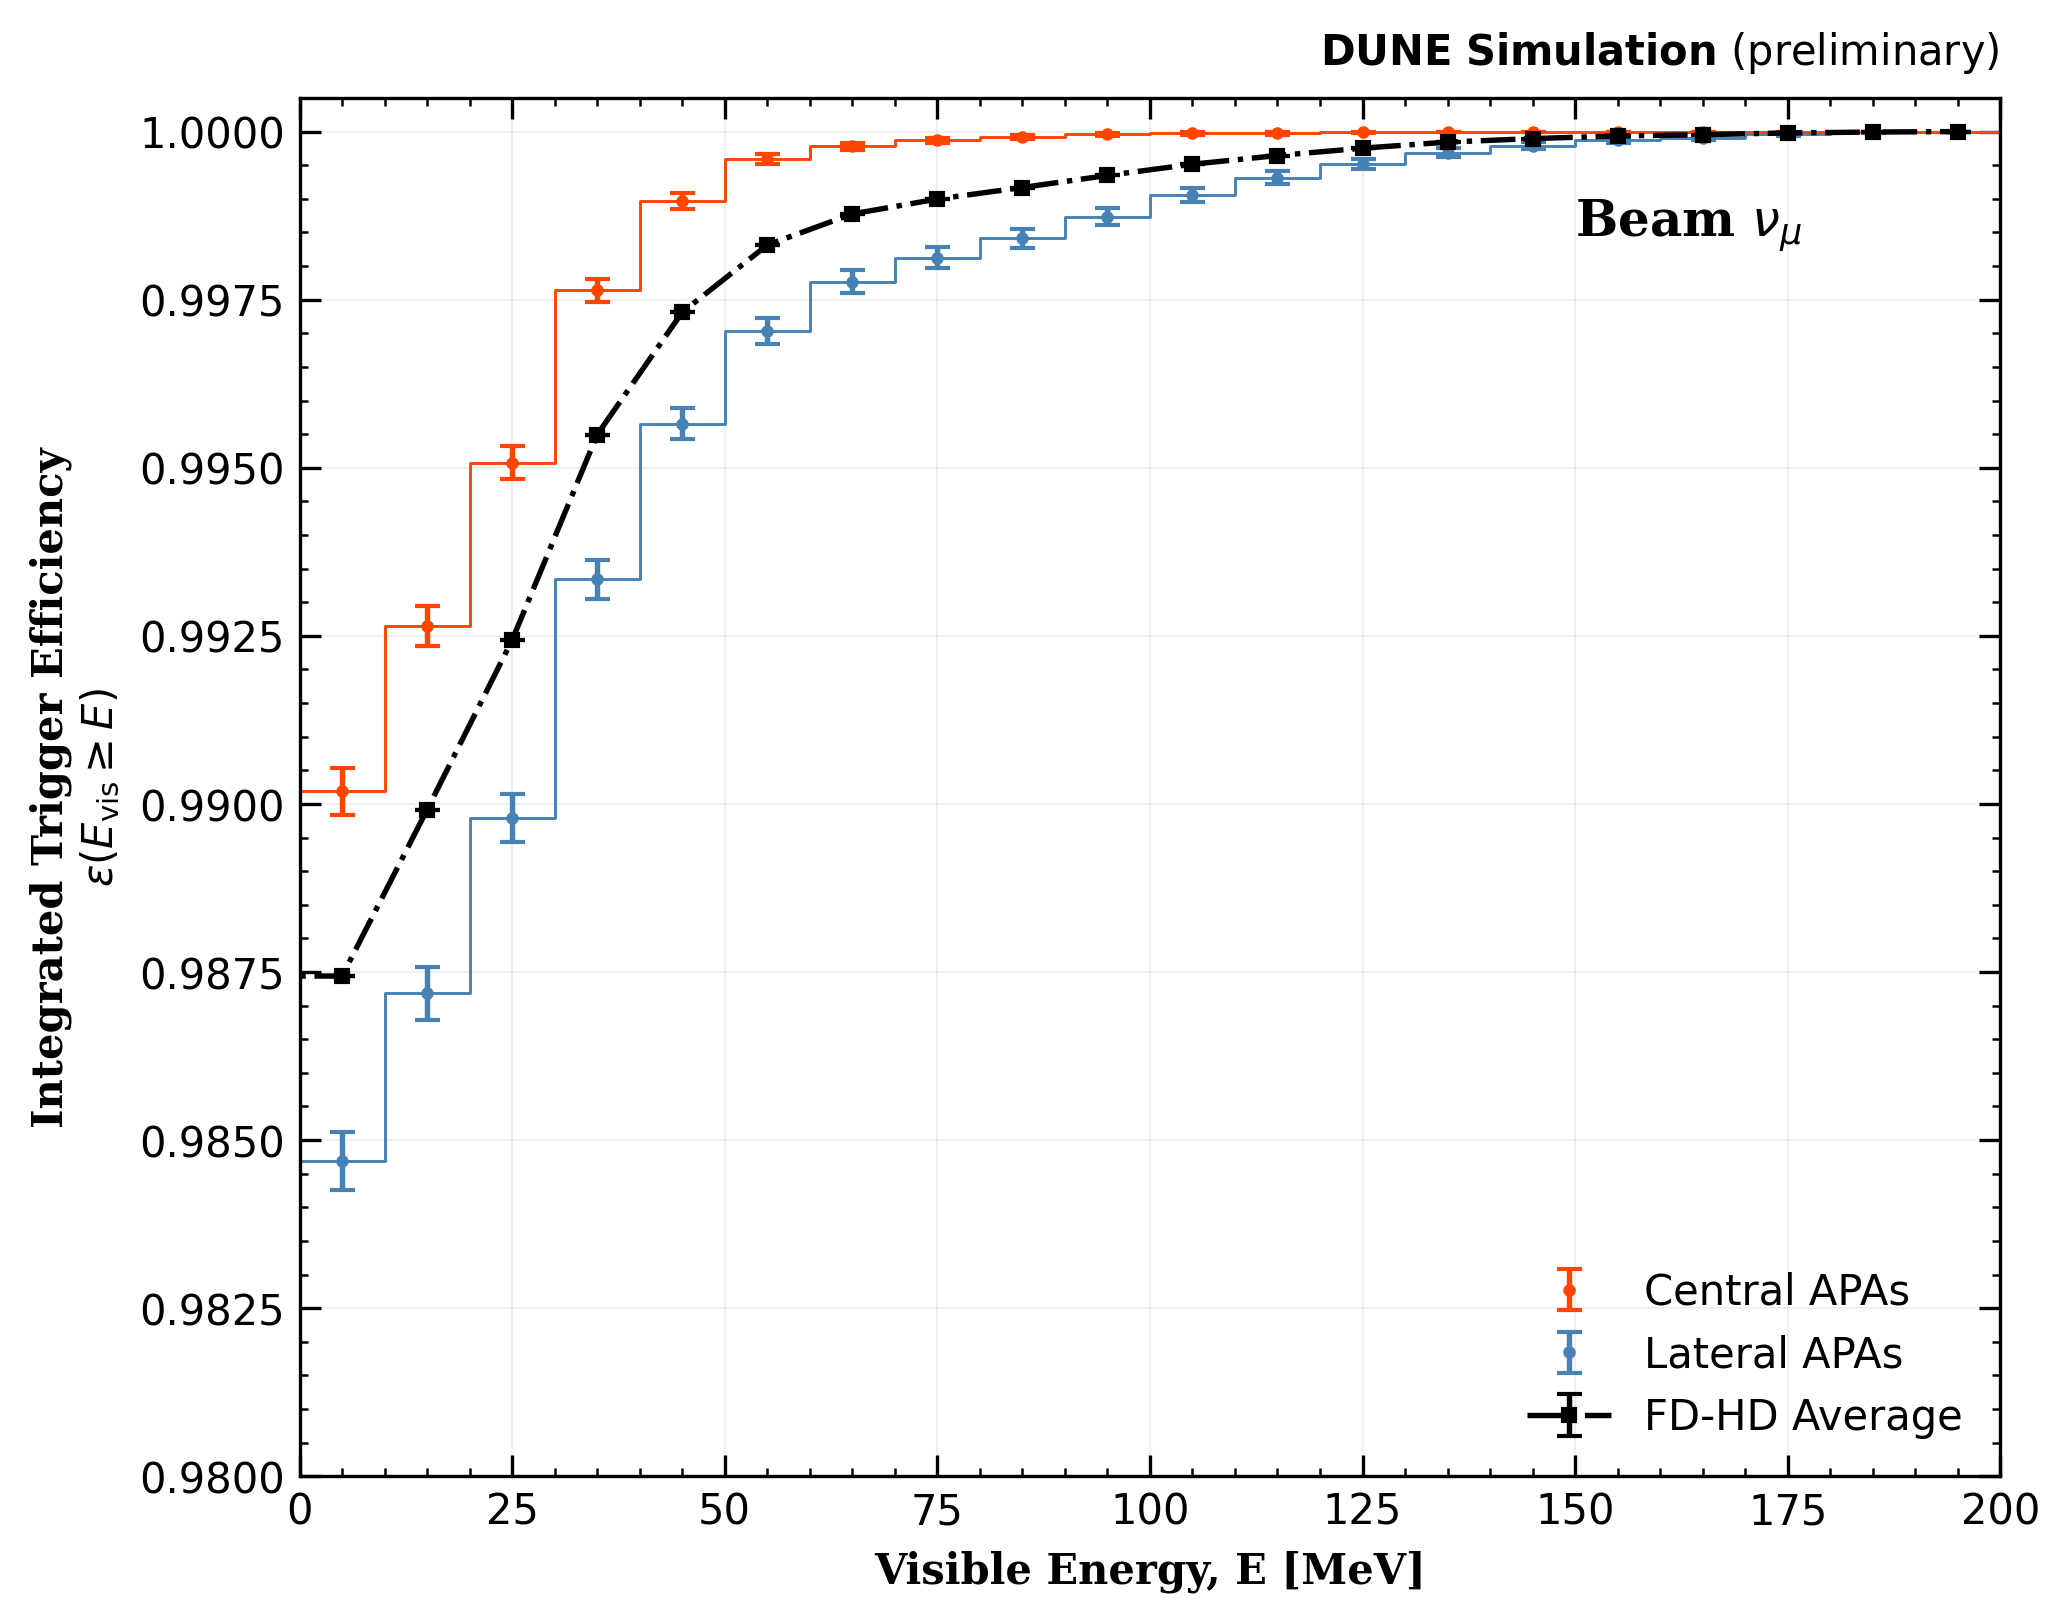

In [14]:
fv_event_numu = numu_mc[ (numu_mc.pdg==14) & (numu_mc.x.abs() <360) & (numu_mc.y.abs() <600) &(numu_mc.z > 0) & (numu_mc.z<1360) ].event_uid.unique()

dx = 10
energies = np.arange(-dx, 210, dx)
bin_centers = energies[:-1] + dx / 2

fig, ax = plt.subplots(figsize=(7,5.5), dpi=300)

lines_for_legend = []

data_lat = [trig_beam_numu_lat[trig_beam_numu_lat.event_uid.isin(fv_event_numu) & (trig_beam_numu_lat.visible_energy > 0)]]
data_cent = [trig_beam_numu_cent[trig_beam_numu_cent.event_uid.isin(fv_event_numu) & (trig_beam_numu_cent.visible_energy > 0)]]

for idx in range(len(data_lat)):
    df_lat = data_lat[idx]
    df_cent = data_cent[idx]

    sensitivity_lat = []
    errors_lat = []
    for i in energies[:-1]:
        events_above = df_lat[df_lat.visible_energy >= i]
        accepted = events_above[events_above.flag == 2]
        n = events_above.event_uid.nunique()
        k = accepted.event_uid.nunique()
        if n > 0:
            eff = k / n
            err = np.sqrt(eff * (1 - eff) / n)
        else:
            eff = np.nan
            err = 0
        sensitivity_lat.append(eff)
        errors_lat.append(err)

    sensitivity_cent = []
    errors_cent = []
    for i in energies[:-1]:
        events_above = df_cent[df_cent.visible_energy >= i]

        accepted = events_above[events_above.flag == 2]
        n = events_above.event_uid.nunique()
        k = accepted.event_uid.nunique()
        if n > 0:
            eff = k / n
            err = np.sqrt(eff * (1 - eff) / n)
        else:
            eff = np.nan
            err = 0
        sensitivity_cent.append(eff)
        errors_cent.append(err)

    sensitivity_lat = np.array(sensitivity_lat)
    errors_lat = np.array(errors_lat)
    sensitivity_cent = np.array(sensitivity_cent)
    errors_cent = np.array(errors_cent)

    line_cent = ax.errorbar(bin_centers, sensitivity_cent, yerr=errors_cent, fmt='o', capsize=3, markersize=2, linewidth=1.3, label='Central APAs', color=cc)
    #ax.bar(bin_centers, sensitivity_cent, width =dx, alpha =1,color=cc,)
    
    
    line_lat = ax.errorbar(bin_centers, sensitivity_lat, yerr=errors_lat, fmt='o', capsize=3, markersize=2, linewidth=1.3, label='Lateral APAs', color=cl)
    ax.step(energies[1:], sensitivity_lat,  alpha=1, color=cl, linewidth=0.7)
    ax.step(energies[1:], sensitivity_cent,  alpha=1, color=cc, linewidth = 0.7)
    #ax.step(energies[1:], 0.5*(sensitivity_lat + sensitivity_cent),  alpha=1, color='k', linewidth = 0.7)

    ax.errorbar(bin_centers, 0.5 * (sensitivity_lat + sensitivity_cent), yerr=0, fmt='s-.', capsize=3, markersize=3, linewidth=1.3, label='FD-HD Average', color='k')
    #ax.bar(bin_centers, sensitivity_lat, width =dx, alpha =1,color=cl,)

    lines_for_legend = [line_cent, line_lat]
ax.text(0.75, 0.90, r"Beam $\nu_{\mu}$", transform=ax.transAxes, fontsize=12, fontweight='bold', family='serif')

ax.set_xlabel("Visible Energy, E [MeV]", fontweight='bold', family='serif')
ax.set_ylabel("Integrated Trigger Efficiency\n" + r"$\varepsilon(E_\mathrm{vis} \geq E)$", fontweight='bold', family='serif')
ax.set_ylim(0.98, 1.0005)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth=0.5, alpha=0.2)
#ax.grid(True, which='minor', linestyle='-', linewidth=0.5, alpha=0.1)
#ax.hlines(0.999, 0, 200)
ax.legend( frameon=False, loc='lower right',  ncol=1)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.tick_params(axis='both', which='major', direction='in', top=True, right=True, length =5)
ax.text(120, 1.001, r'$\bf{DUNE\ Simulation}$ (preliminary)')
ax.minorticks_on()
#fig.suptitle(r"$\mathbf{FDHD\ Integrated\ Trigger\ Efficiency\ for\ Beam\ \nu_{e}}$"+"\n(Fraction of events triggered at $E$ or higher)",  family='serif', y=0.96)
plt.xlim(0,200)
plt.tight_layout()
#plt.hlines(0.999, 0, 200, linestyle='dotted')

plt.savefig("./figures/beam_numu_int_eff.png")
plt.show()


/var/folders/1s/mfxsnwp9275ft3r75z4zs6c80000gn/T/ipykernel_2842/3450266796.py:4: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0))) + b



beam ν_μ$
                  50%        75%        90%
-------------------------------------------
Lateral         38.9      68.3     106.5
Central         28.6      40.8      53.9
Mean            32.2      51.1      80.4


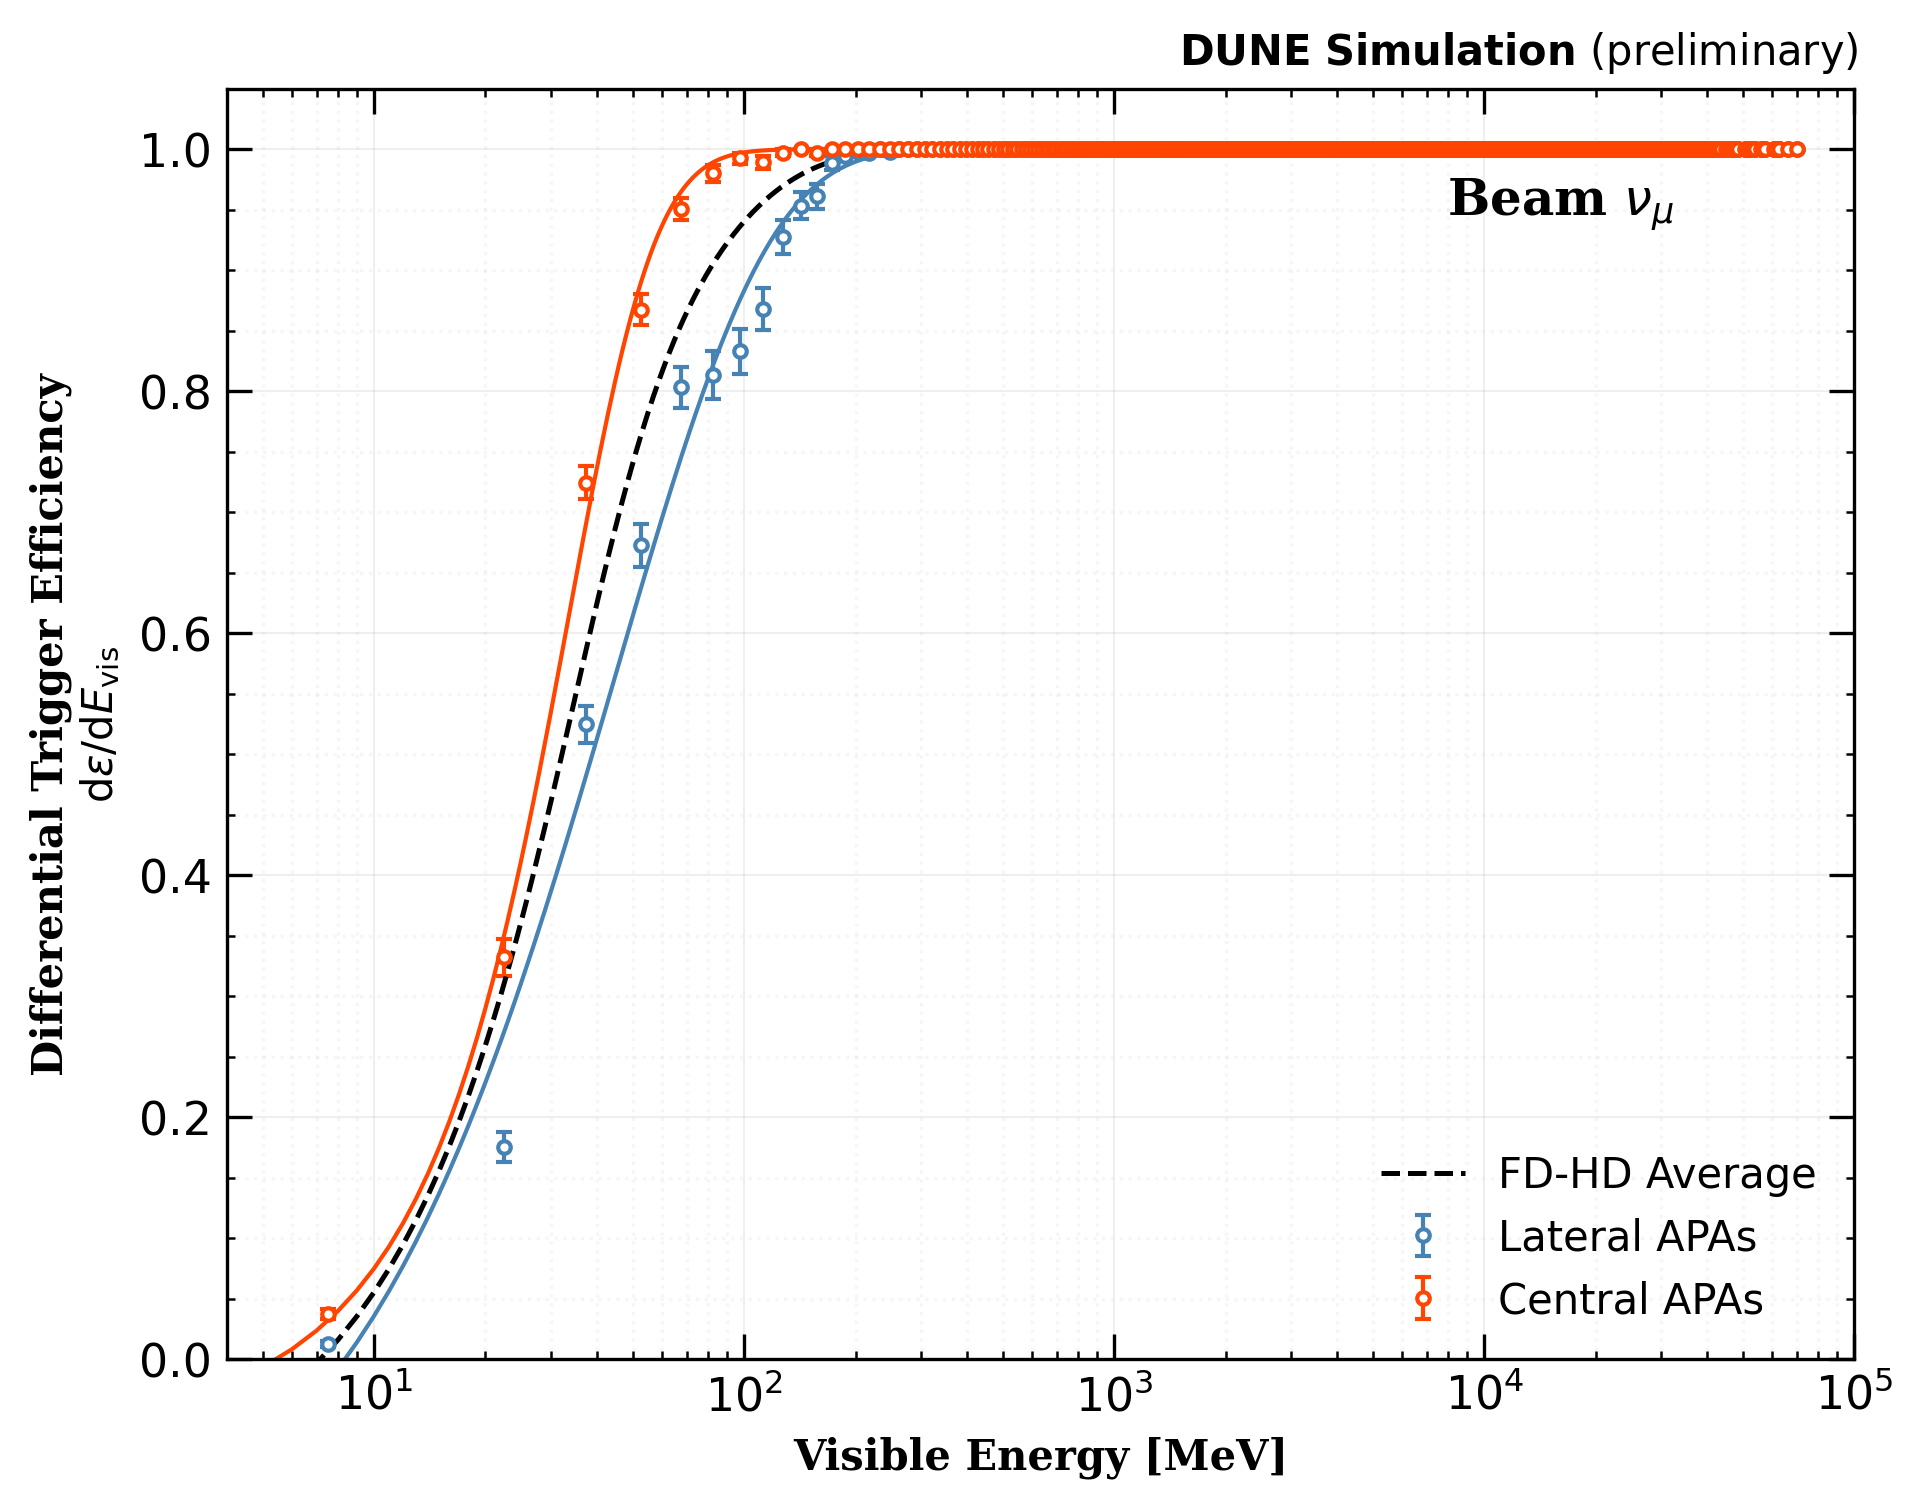

In [15]:

from scipy.optimize import curve_fit

def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

data_lat = [trig_beam_numu_lat]
data_cent = [trig_beam_numu_cent]
#fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=200, sharex=True, sharey=True)
fig, ax = plt.subplots(figsize=(7,5.5), dpi=300)
lines_for_legend = []

for idx in range(len(data_lat)):
    dx_lat = 15
    dx_cent =15
    max_eng = 1e5

    energies_lat = np.arange(0, max_eng, dx_lat)
    bin_centers_lat = energies_lat[:-1] + dx_lat / 2

    energies_cent = np.arange(0, max_eng, dx_cent)
    bin_centers_cent = energies_cent[:-1] + dx_cent / 2

    sensitivity_lat = []
    errors_lat = []
    df_lat = data_lat[idx]
    for energy_start in energies_lat[:-1]:
        upper = energy_start + dx_lat
        events_in_bin = df_lat[(df_lat.visible_energy >= energy_start) & (df_lat.visible_energy < upper)]
        accepted_events_in_bin = events_in_bin[events_in_bin.flag == 2]

        n = events_in_bin.event_uid.nunique()
        k = accepted_events_in_bin.event_uid.nunique()

        if n > 0:
            sens = k / n
            err = np.sqrt(sens * (1 - sens) / n)
        else:
            sens = np.nan
            err = 0

        sensitivity_lat.append(sens)
        errors_lat.append(err)

    sensitivity_cent = []
    errors_cent = []
    df_cent = data_cent[idx]
    for energy_start in energies_cent[:-1]:
        upper = energy_start + dx_cent
        events_in_bin = df_cent[(df_cent.visible_energy >= energy_start) & (df_cent.visible_energy < upper)]
        accepted_events_in_bin = events_in_bin[events_in_bin.flag == 2]

        n = events_in_bin.event_uid.nunique()
        k = accepted_events_in_bin.event_uid.nunique()

        if n > 0:
            sens = k / n
            err = np.sqrt(sens * (1 - sens) / n)
        else:
            sens = np.nan
            err = 0

        sensitivity_cent.append(sens)
        errors_cent.append(err)

    bin_centers_lat = np.array(bin_centers_lat)
    sensitivity_lat = np.array(sensitivity_lat)
    errors_lat = np.array(errors_lat)

    bin_centers_cent = np.array(bin_centers_cent)
    sensitivity_cent = np.array(sensitivity_cent)
    errors_cent = np.array(errors_cent)

    mask_lat = ~np.isnan(sensitivity_lat)
    mask_cent = ~np.isnan(sensitivity_cent)

    try:
        popt_lat, _ = curve_fit(sigmoid, bin_centers_lat[mask_lat], sensitivity_lat[mask_lat], p0=[1, 10, 1, 0], maxfev=1000)
    except:
        popt_lat = [1, 10, 1, 0]
    try:
        popt_cent, _ = curve_fit(sigmoid, bin_centers_cent[mask_cent], sensitivity_cent[mask_cent], p0=[1, 10, 1, 0], maxfev=1000)
    except:
        popt_cent = [1, 10, 1, 0]

    x_fit = np.linspace(4, 1000, 1000)
    y_fit_lat = sigmoid(x_fit, *popt_lat)
    y_fit_cent = sigmoid(x_fit, *popt_cent)
    y_fit_mean = (y_fit_lat + y_fit_cent) / 2

    levels = (0.5, 0.75, 0.90)
    results = {
        "Lateral": energies_at_efficiency(x_fit, y_fit_lat, levels),
        "Central": energies_at_efficiency(x_fit, y_fit_cent, levels),
        "Mean":    energies_at_efficiency(x_fit, y_fit_mean, levels), }
    print_efficiency_table("beam ν_μ$", results)


    ax.errorbar(bin_centers_lat, sensitivity_lat, yerr=errors_lat, fmt='o', capsize=2, markersize=3,markerfacecolor='white', elinewidth=1, color=cl, label='Lateral APAs')
    ax.errorbar(bin_centers_cent, sensitivity_cent, yerr=errors_cent, fmt='o', capsize=2, markersize=3,markerfacecolor='white', elinewidth=1, color=cc, label = 'Central APAs')
    line_cent, = ax.plot(x_fit, y_fit_cent, color=cc, linewidth=1)
    line_lat, = ax.plot(x_fit, y_fit_lat, color=cl, linewidth=1)



    line_mean, = ax.plot(x_fit, y_fit_mean, color='black', linewidth=1.2, linestyle='--', label ="FD-HD Average")

    if idx == 0: lines_for_legend = [line_cent, line_lat, line_mean]

    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=11)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0,1e5)
    ax.grid(True, which='major', linestyle='-', linewidth=0.5, alpha=0.2)
    ax.grid(True, which='minor', linestyle=':', alpha =0.1)
    ax.set_xscale('log')
    ax.set_xlim(4,max_eng)
    ax.set_xlabel("Visible Energy [MeV]", fontweight='bold', family='serif')
    ax.set_ylabel(r"Differential Trigger Efficiency" + "\n" + r"$\mathrm{d}\varepsilon / \mathrm{d}E_\mathrm{vis}$",  fontweight='bold',  family='serif')
    ax.legend( frameon=False, loc='lower right',  ncol=1)
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='major', direction='in', top=True, right=True, length =6)
    ax.text(1.5e3, 1.07, r'$\bf{DUNE\ Simulation}$ (preliminary)')
    ax.minorticks_on()
    ax.text(0.75, 0.90, r"Beam $\nu_{\mu}$", transform=ax.transAxes, fontsize=12, fontweight='bold', family='serif')
    ax.legend(loc = 'lower right', frameon = False)
plt.savefig("./figures/beam_numu_diff_eff.png")

plt.show()

/var/folders/1s/mfxsnwp9275ft3r75z4zs6c80000gn/T/ipykernel_2842/478252961.py:4: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0))) + b



beam ν_e
                  50%        75%        90%
-------------------------------------------
Lateral         55.3      80.8     108.2
Central         34.1      48.0      62.6
Mean            42.2      63.7      90.1


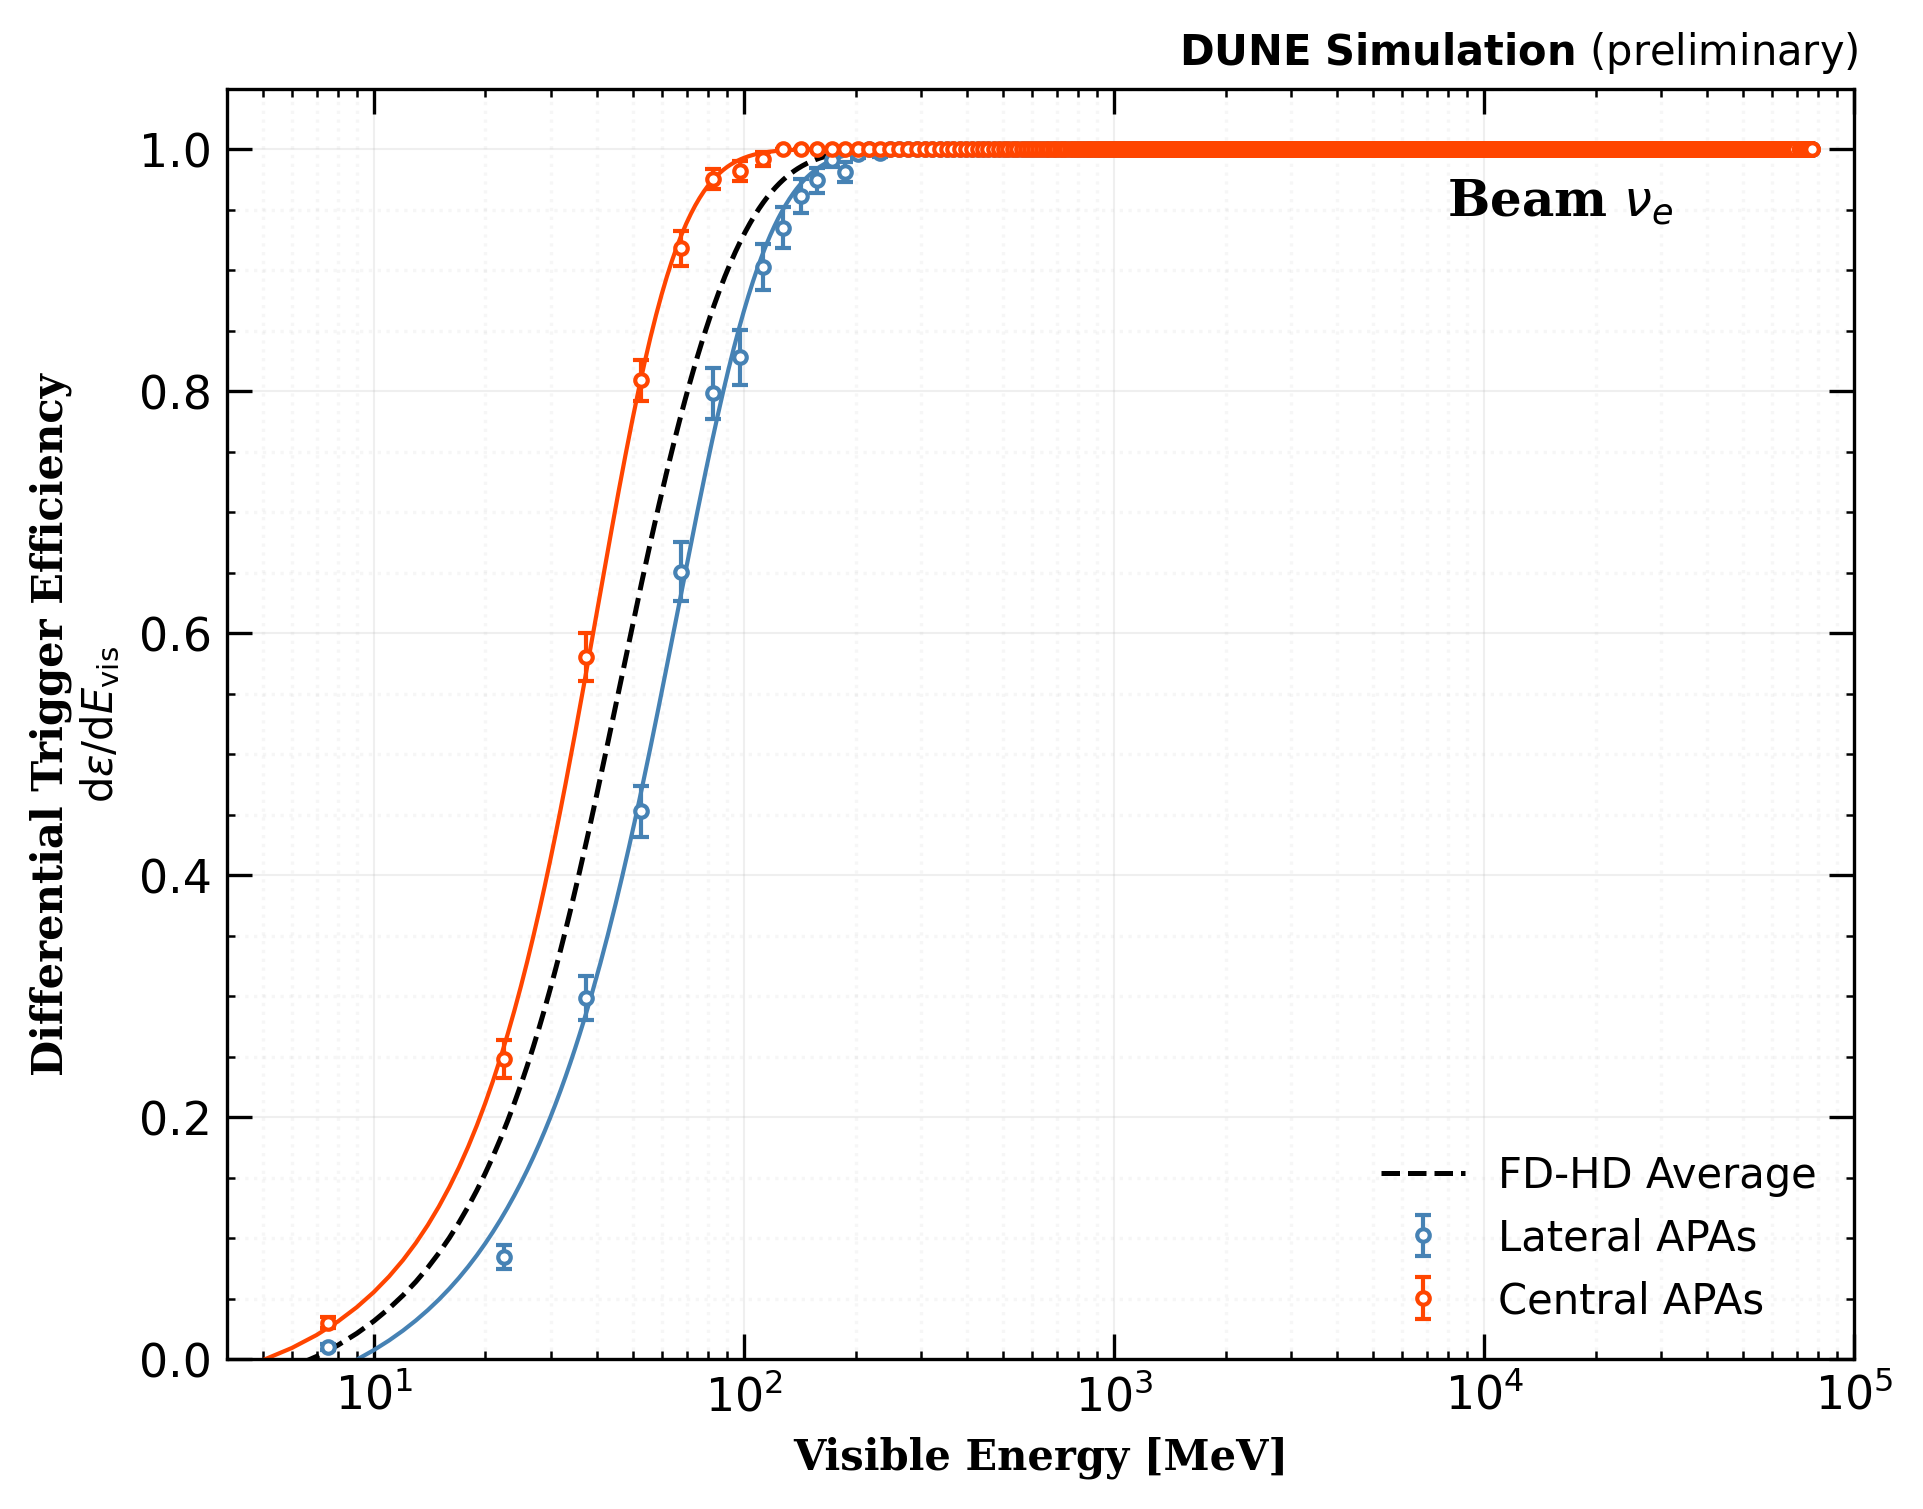

In [16]:

from scipy.optimize import curve_fit

def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

data_lat = [trig_beam_nue_lat]
data_cent = [trig_beam_nue_cent]
#fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=200, sharex=True, sharey=True)
fig, ax = plt.subplots(figsize=(7,5.5), dpi=300)
lines_for_legend = []

for idx in range(len(data_lat)):
    dx_lat = 15
    dx_cent =15
    max_eng = 1e5

    energies_lat = np.arange(0, max_eng, dx_lat)
    bin_centers_lat = energies_lat[:-1] + dx_lat / 2

    energies_cent = np.arange(0, max_eng, dx_cent)
    bin_centers_cent = energies_cent[:-1] + dx_cent / 2

    sensitivity_lat = []
    errors_lat = []
    df_lat = data_lat[idx]
    for energy_start in energies_lat[:-1]:
        upper = energy_start + dx_lat
        events_in_bin = df_lat[(df_lat.visible_energy >= energy_start) & (df_lat.visible_energy < upper)]
        accepted_events_in_bin = events_in_bin[events_in_bin.flag == 2]

        n = events_in_bin.event_uid.nunique()
        k = accepted_events_in_bin.event_uid.nunique()

        if n > 0:
            sens = k / n
            err = np.sqrt(sens * (1 - sens) / n)
        else:
            sens = np.nan
            err = 0

        sensitivity_lat.append(sens)
        errors_lat.append(err)

    sensitivity_cent = []
    errors_cent = []
    df_cent = data_cent[idx]
    for energy_start in energies_cent[:-1]:
        upper = energy_start + dx_cent
        events_in_bin = df_cent[(df_cent.visible_energy >= energy_start) & (df_cent.visible_energy < upper)]
        accepted_events_in_bin = events_in_bin[events_in_bin.flag == 2]

        n = events_in_bin.event_uid.nunique()
        k = accepted_events_in_bin.event_uid.nunique()

        if n > 0:
            sens = k / n
            err = np.sqrt(sens * (1 - sens) / n)
        else:
            sens = np.nan
            err = 0

        sensitivity_cent.append(sens)
        errors_cent.append(err)

    bin_centers_lat = np.array(bin_centers_lat)
    sensitivity_lat = np.array(sensitivity_lat)
    errors_lat = np.array(errors_lat)

    bin_centers_cent = np.array(bin_centers_cent)
    sensitivity_cent = np.array(sensitivity_cent)
    errors_cent = np.array(errors_cent)

    mask_lat = ~np.isnan(sensitivity_lat)
    mask_cent = ~np.isnan(sensitivity_cent)

    try:
        popt_lat, _ = curve_fit(sigmoid, bin_centers_lat[mask_lat], sensitivity_lat[mask_lat], p0=[1, 10, 1, 0], maxfev=1000)
    except:
        popt_lat = [1, 10, 1, 0]
    try:
        popt_cent, _ = curve_fit(sigmoid, bin_centers_cent[mask_cent], sensitivity_cent[mask_cent], p0=[1, 10, 1, 0], maxfev=1000)
    except:
        popt_cent = [1, 10, 1, 0]

    x_fit = np.linspace(4, 1000, 1000)
    y_fit_lat = sigmoid(x_fit, *popt_lat)
    y_fit_cent = sigmoid(x_fit, *popt_cent)
    y_fit_mean = (y_fit_lat + y_fit_cent) / 2

    levels = (0.5, 0.75, 0.90)
    results = {
        "Lateral": energies_at_efficiency(x_fit, y_fit_lat, levels),
        "Central": energies_at_efficiency(x_fit, y_fit_cent, levels),
        "Mean":    energies_at_efficiency(x_fit, y_fit_mean, levels), }
    print_efficiency_table("beam ν_e", results)



    ax.errorbar(bin_centers_lat, sensitivity_lat, yerr=errors_lat, fmt='o', capsize=2, markersize=3,markerfacecolor='white', elinewidth=1, color=cl, label='Lateral APAs')
    ax.errorbar(bin_centers_cent, sensitivity_cent, yerr=errors_cent, fmt='o', capsize=2, markersize=3,markerfacecolor='white', elinewidth=1, color=cc, label = 'Central APAs')
    line_cent, = ax.plot(x_fit, y_fit_cent, color=cc, linewidth=1)
    line_lat, = ax.plot(x_fit, y_fit_lat, color=cl, linewidth=1)



    line_mean, = ax.plot(x_fit, y_fit_mean, color='black', linewidth=1.2, linestyle='--', label ="FD-HD Average")

    if idx == 0: lines_for_legend = [line_cent, line_lat, line_mean]

    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=11)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0,1e5)
    ax.grid(True, which='major', linestyle='-', linewidth=0.5, alpha=0.2)
    ax.grid(True, which='minor', linestyle=':', alpha =0.1)
    ax.set_xscale('log')
    ax.set_xlim(4,max_eng)
    ax.set_xlabel("Visible Energy [MeV]", fontweight='bold', family='serif')
    ax.set_ylabel(r"Differential Trigger Efficiency" + "\n" + r"$\mathrm{d}\varepsilon / \mathrm{d}E_\mathrm{vis}$",  fontweight='bold',  family='serif')
    ax.legend( frameon=False, loc='lower right',  ncol=1)
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='major', direction='in', top=True, right=True, length =6)
    ax.text(1.5e3, 1.07, r'$\bf{DUNE\ Simulation}$ (preliminary)')
    ax.minorticks_on()
    ax.text(0.75, 0.90, r"Beam $\nu_{e}$", transform=ax.transAxes, fontsize=12, fontweight='bold', family='serif')
    ax.legend(loc = 'lower right', frameon = False)
plt.savefig("./figures/beam_nue_diff_eff.png")
plt.show()

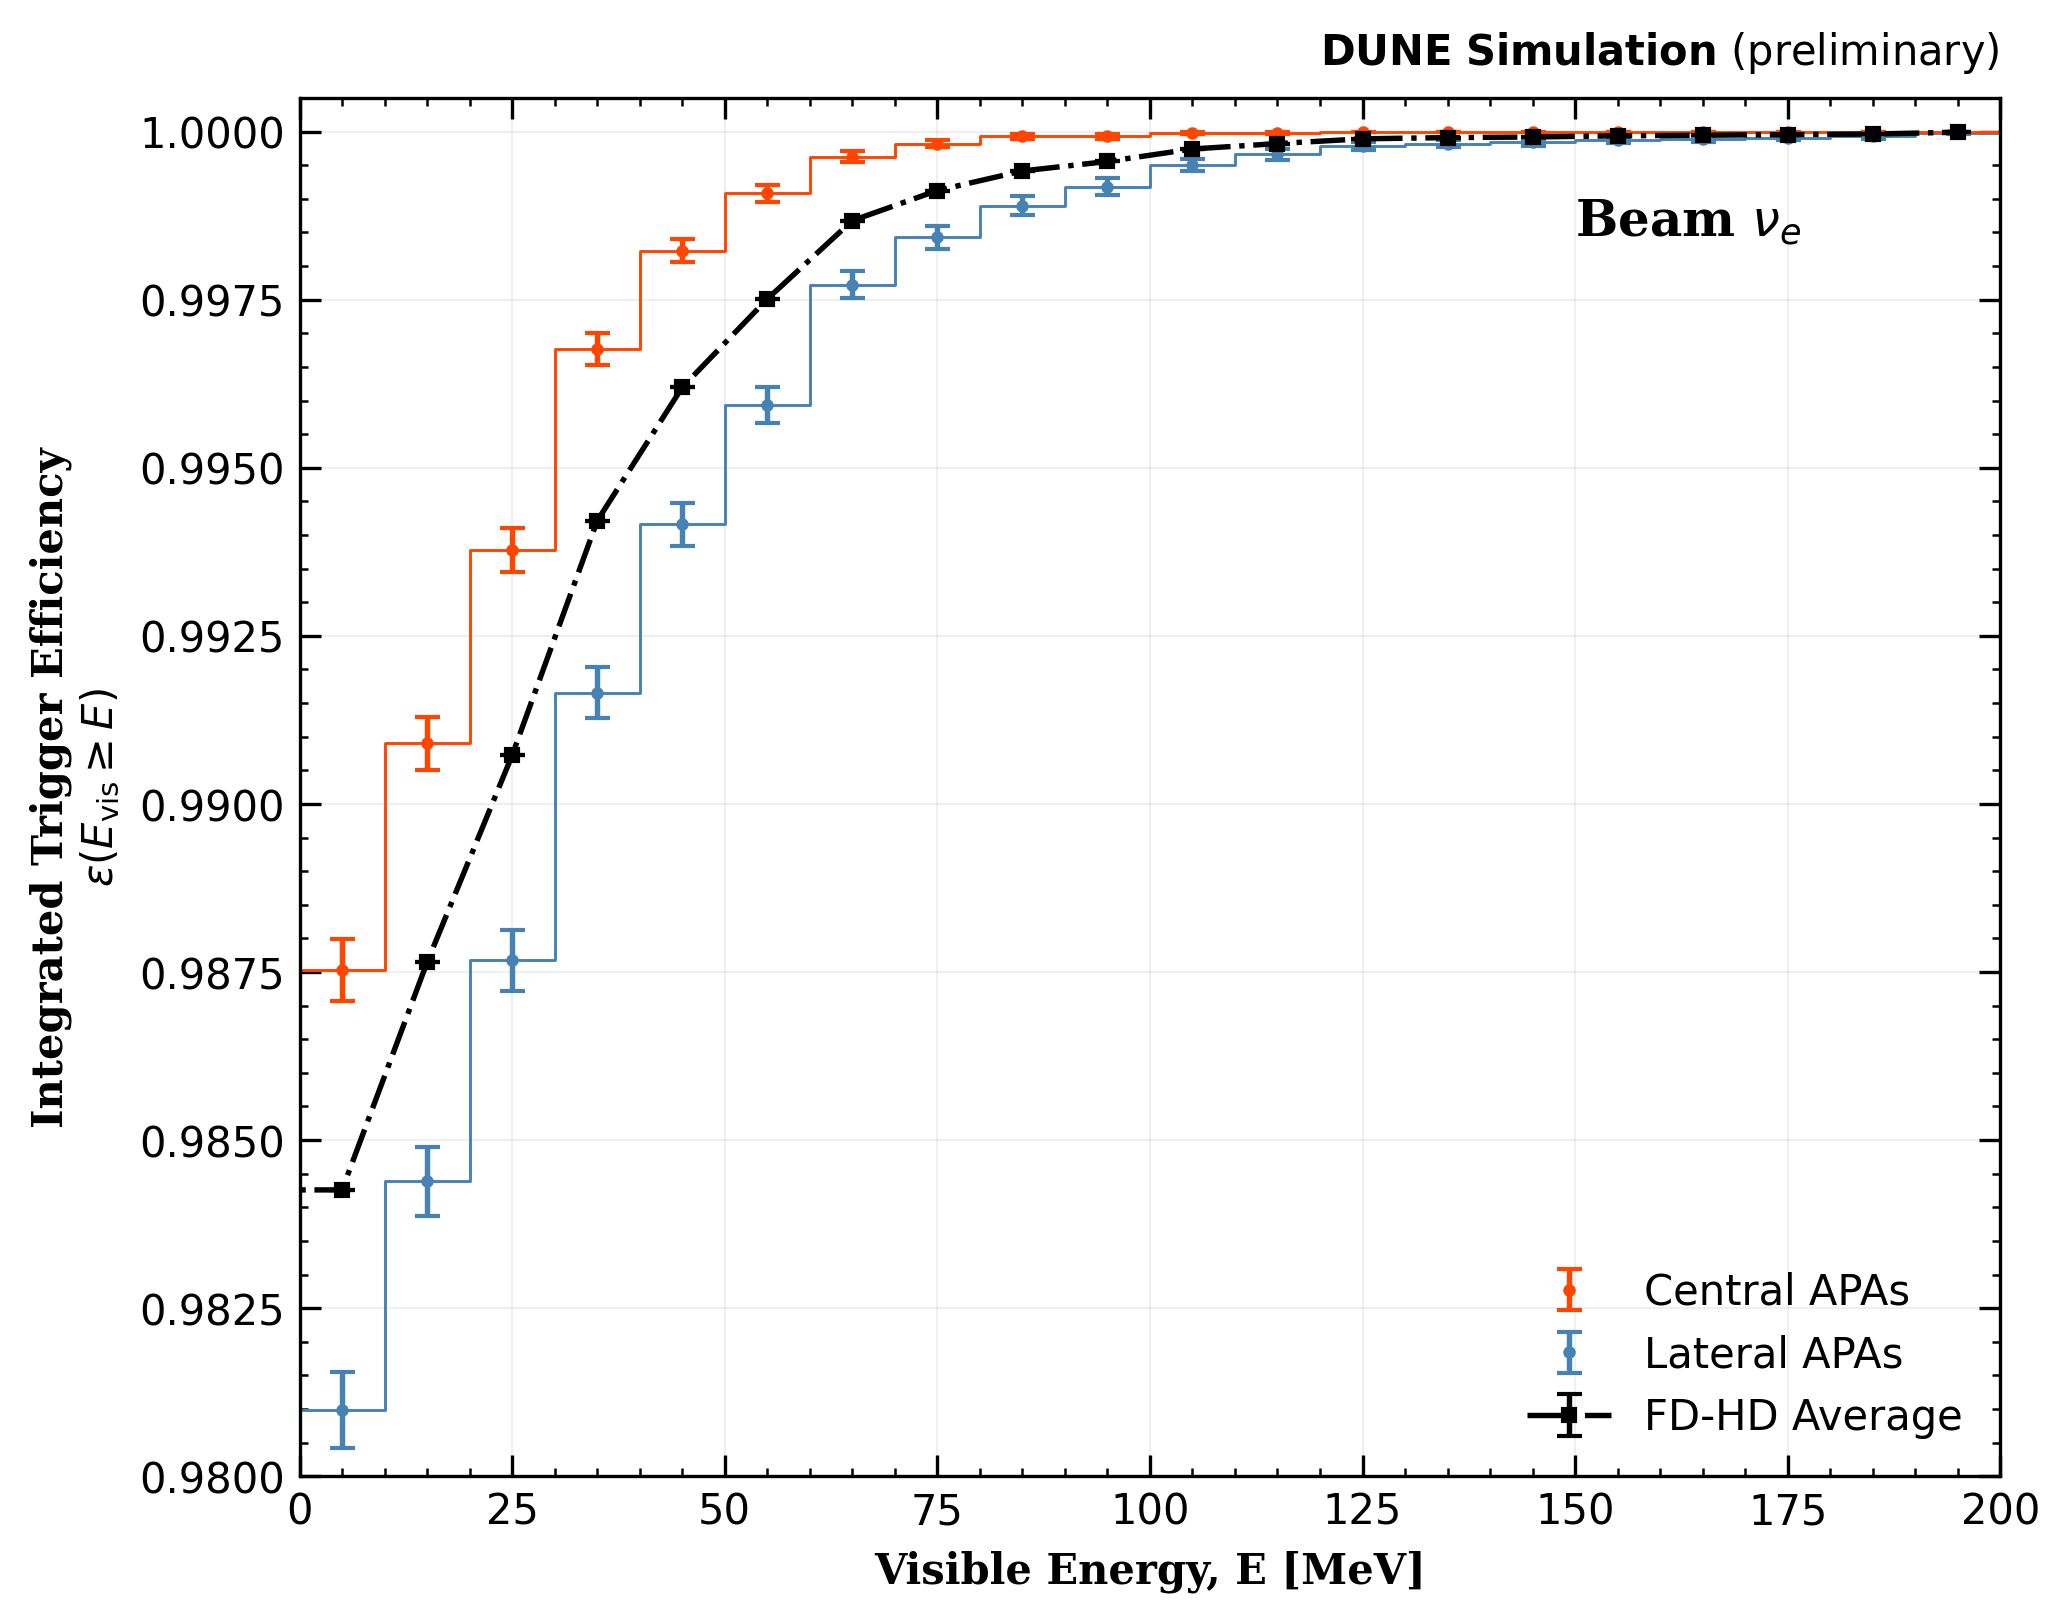

In [17]:

fv_event_nue = nue_mc[ (nue_mc.pdg==12) & (nue_mc.x.abs() <360) & (nue_mc.y.abs() <600) &(nue_mc.z > 0) & (nue_mc.z<1360)  ].event_uid.unique()

dx = 10
energies = np.arange(-dx, 210, dx)
bin_centers = energies[:-1] + dx / 2

fig, ax = plt.subplots(figsize=(7,5.5), dpi=300)

lines_for_legend = []

data_lat = [trig_beam_nue_lat[trig_beam_nue_lat.event_uid.isin(fv_event_nue) & (trig_beam_nue_lat.visible_energy > 0)]]
data_cent = [trig_beam_nue_cent[trig_beam_nue_cent.event_uid.isin(fv_event_nue)  & (trig_beam_nue_cent.visible_energy > 0)]]

for idx in range(len(data_lat)):
    df_lat = data_lat[idx]
    df_cent = data_cent[idx]

    sensitivity_lat = []
    errors_lat = []
    for i in energies[:-1]:
        events_above = df_lat[df_lat.visible_energy >= i]
        accepted = events_above[events_above.flag == 2]
        n = events_above.event_uid.nunique()
        k = accepted.event_uid.nunique()
        if n > 0:
            eff = k / n
            err = np.sqrt(eff * (1 - eff) / n)
        else:
            eff = np.nan
            err = 0
        sensitivity_lat.append(eff)
        errors_lat.append(err)

    sensitivity_cent = []
    errors_cent = []
    for i in energies[:-1]:
        events_above = df_cent[df_cent.visible_energy >= i]

        accepted = events_above[events_above.flag == 2]
        n = events_above.event_uid.nunique()
        k = accepted.event_uid.nunique()
        if n > 0:
            eff = k / n
            err = np.sqrt(eff * (1 - eff) / n)
        else:
            eff = np.nan
            err = 0
        sensitivity_cent.append(eff)
        errors_cent.append(err)

    sensitivity_lat = np.array(sensitivity_lat)
    errors_lat = np.array(errors_lat)
    sensitivity_cent = np.array(sensitivity_cent)
    errors_cent = np.array(errors_cent)

    line_cent = ax.errorbar(bin_centers, sensitivity_cent, yerr=errors_cent, fmt='o', capsize=3, markersize=2, linewidth=1.3, label='Central APAs', color=cc)
    #ax.bar(bin_centers, sensitivity_cent, width =dx, alpha =1,color=cc,)
    
    
    line_lat = ax.errorbar(bin_centers, sensitivity_lat, yerr=errors_lat, fmt='o', capsize=3, markersize=2, linewidth=1.3, label='Lateral APAs', color=cl)
    ax.step(energies[1:], sensitivity_lat,  alpha=1, color=cl, linewidth=0.7)
    ax.step(energies[1:], sensitivity_cent,  alpha=1, color=cc, linewidth = 0.7)
    #ax.step(energies[1:], 0.5*(sensitivity_lat + sensitivity_cent),  alpha=1, color='k', linewidth = 0.7)

    ax.errorbar(bin_centers, 0.5 * (sensitivity_lat + sensitivity_cent), yerr=0, fmt='s-.', capsize=3, markersize=3, linewidth=1.3, label='FD-HD Average', color='k')
    #ax.bar(bin_centers, sensitivity_lat, width =dx, alpha =1,color=cl,)

    lines_for_legend = [line_cent, line_lat]
ax.text(0.75, 0.90, r"Beam $\nu_{e}$", transform=ax.transAxes, fontsize=12, fontweight='bold', family='serif')

ax.set_xlabel("Visible Energy, E [MeV]", fontweight='bold', family='serif')
ax.set_ylabel("Integrated Trigger Efficiency\n" + r"$\varepsilon(E_\mathrm{vis} \geq E)$", fontweight='bold', family='serif')
ax.set_ylim(0.98, 1.0005)
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth=0.5, alpha=0.2)

ax.legend( frameon=False, loc='lower right',  ncol=1)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.tick_params(axis='both', which='major', direction='in', top=True, right=True, length =5)
ax.text(120, 1.001, r'$\bf{DUNE\ Simulation}$ (preliminary)')
ax.minorticks_on()
plt.xlim(0,200)
#plt.hlines(0.999, 0, 200, linestyle='dotted')
plt.tight_layout()
plt.savefig("./figures/beam_nue_int_eff.png")
plt.show()


# Low Energy Neutrinos

In [18]:
generate_tas = False

if generate_tas:
    for data_type in ["mc", "tps", "eventsum"]:
        for part in ["es", "cc"]:
            globals()[f"{part}_{data_type}"] = pd.read_pickle(f"./low_e/nue_{part}_{data_type}.pkl")

            #get unique event IDs
            util.get_unique_event_ids(globals()[f"{part}_{data_type}"])
            #make sure all the dfs are sorted by the unique event IDs --> important when merging multiple dfs. later on 
            globals()[f"{part}_{data_type}"] = globals()[f"{part}_{data_type}"].sort_values(by="event_uid")


    #visible energy from both ROP planes 
    for part in ["es", "cc"]:
        globals()[f"{part}_eventsum"]['visible_energy'] =  globals()[f"{part}_eventsum"]['tot_visible_energy_rop2']  +  globals()[f"{part}_eventsum"]['tot_visible_energy_rop3']

    #Generate TAs 
    for part in ["es", "cc"]:
        print("\n" + f"generating central APA efficiencies for  {part}")
        globals()[f"cTPs_{part}"], globals()[f"cTAs_{part}"]  = util.GenerateTAs(globals()[f"{part}_tps"], add_backgrounds = False)
        print("\n" + f"generating lateral APA efficiencies for  {part}")
        globals()[f"lTPs_{part}"], globals()[f"lTAs_{part}"]  = util.GenerateTAs(globals()[f"{part}_tps"], **lat_params, add_backgrounds = False)

    #Merge with truth information 
    for part in ["es", "cc"]:
        cTAs_part = globals().get(f"cTAs_{part}")
        lTAs_part = globals().get(f"lTAs_{part}")

        eventsum_part = globals().get(f"{part}_eventsum")
        
        if cTAs_part is not None and eventsum_part is not None and {'event', 'run'}.issubset(cTAs_part.columns) and {'event', 'run'}.issubset(eventsum_part.columns):
            globals()[f"trig_{part}_cent"] = pd.merge(cTAs_part, eventsum_part[['event', 'run', 'visible_energy', 'event_uid']], on=['event', 'run'], how='right').fillna(-1)

        if lTAs_part is not None and eventsum_part is not None and {'event', 'run'}.issubset(lTAs_part.columns) and {'event', 'run'}.issubset(eventsum_part.columns):
            globals()[f"trig_{part}_lat"] = pd.merge(lTAs_part, eventsum_part[['event', 'run', 'visible_energy', 'event_uid']], on=['event', 'run'], how='right').fillna(-1)
    display(trig_es_cent)

    #Save to pkl 
    for part in ["es", "cc"]:
        globals()[f"trig_{part}_cent"].to_pickle(f"./trigger_data/{part}_TAs_cbgd.pkl")
        globals()[f"trig_{part}_lat"].to_pickle(f"./trigger_data/{part}_TAs_lbgd.pkl")

        globals()[f"lTPs_{part}"].to_pickle(f"./trigger_data/{part}_TPs_lbgd.pkl")
        globals()[f"cTPs_{part}"].to_pickle(f"./trigger_data/{part}_TPs_cbgd.pkl")
        
else:
    # Load existing trigger data 

    for part in ["es", "cc"]:
        globals()[f"trig_{part}_cent"]=pd.read_pickle(f"./trigger_data/{part}_TAs_cbgd.pkl")
        globals()[f"trig_{part}_lat"]=pd.read_pickle(f"./trigger_data/{part}_TAs_lbgd.pkl")

        globals()[f"lTPs_{part}"]=pd.read_pickle(f"./trigger_data/{part}_TPs_lbgd.pkl")
        globals()[f"cTPs_{part}"]=pd.read_pickle(f"./trigger_data/{part}_TPs_cbgd.pkl")

In [19]:
#Simualte data taking in presence of backgrounds. Adding some background window contributions as this matters for SN (shouldn't impact the original cluster cut, and thresholding, but would impact subsequent SN window ids )

def add_bgd_energy(df, source_series, replace=True, seed=None):
    """
    Add a bgd_energy column to df by sampling values from bgd only TAs.
    """
    sampled = source_series.sample(n=len(df), replace=replace, random_state=seed).reset_index(drop=True)
    df = df.reset_index(drop=True).copy()
    df['bgd_energy'] = sampled.values
    return df

for bgd in ['cent', 'lat']:
    for part in ['es', 'cc']:
        globals()[f"trig_{part}_{bgd}"] =  add_bgd_energy( globals()[f"trig_{part}_{bgd}"] , globals()[f"{bgd}_ta_windows"]['window_energy_sum'], replace=True, seed = 0 ) 


trig_es_cent

event  tpc  window_start  flag     TA_id  total_window_energy  \
0           1  2.0        4000.0   2.0       0.0              58912.0   
1           2 -1.0          -1.0  -1.0      -1.0                 -1.0   
2           3 -1.0          -1.0  -1.0      -1.0                 -1.0   
3           4  3.0        3000.0   2.0       3.0              23450.0   
4           5 -1.0          -1.0  -1.0      -1.0                 -1.0   
...       ...  ...           ...   ...       ...                  ...   
294256  34996 -1.0          -1.0  -1.0      -1.0                 -1.0   
294257  34997  6.0        2000.0   2.0  332770.0             111497.0   
294258  34998 -1.0          -1.0  -1.0      -1.0                 -1.0   
294259  34999  2.0           0.0   2.0  332772.0              70324.0   
294260  35000  4.0        1000.0   2.0  332773.0             115841.0   

        TP_count  n_clusters  mean_cluster_energy total_cluster_energy  \
0            3.0        -1.0                 -1.0                   -1   
1           -1.0        -1.0                 -1.0                   -1   
2           -1.0        -1.0                 -1.0                   -1   
3            2.0         1.0              23450.0                23450   
4           -1.0        -1.0                 -1.0                   -1   
...          ...         ...                  ...                  ...   
294256      -1.0        -1.0                 -1.0                   -1   
294257       8.0        -1.0                 -1.0                   -1   
294258      -1.0        -1.0                 -1.0                   -1   
294259       4.0        -1.0                 -1.0                   -1   
294260       9.0        -1.0                 -1.0                   -1   

       max_cluster_energy   run  visible_energy       event_uid  bgd_energy  
0                      -1  1843       17.373826   7915624726529        6518  
1                      -1  1843        0.364689   7915624726530        5311  
2                      -1  1843        3.563496   7915624726531        3085  
3                   23450  1843        7.658318   7915624726532       13416  
4                      -1  1843        0.089921   7915624726533        2120  
...                   ...   ...             ...             ...         ...  
294256                 -1  8145        1.357020  34982508660916        3251  
294257                 -1  8145       28.633578  34982508660917        2197  
294258                 -1  8145        0.383819  34982508660918        2549  
294259                 -1  8145       15.932711  34982508660919        5735  
294260                 -1  8145       28.989691  34982508660920        1615  

[294261 rows x 15 columns]


ES
                  50%        75%        90%
-------------------------------------------
Mean             6.8       7.5       8.2


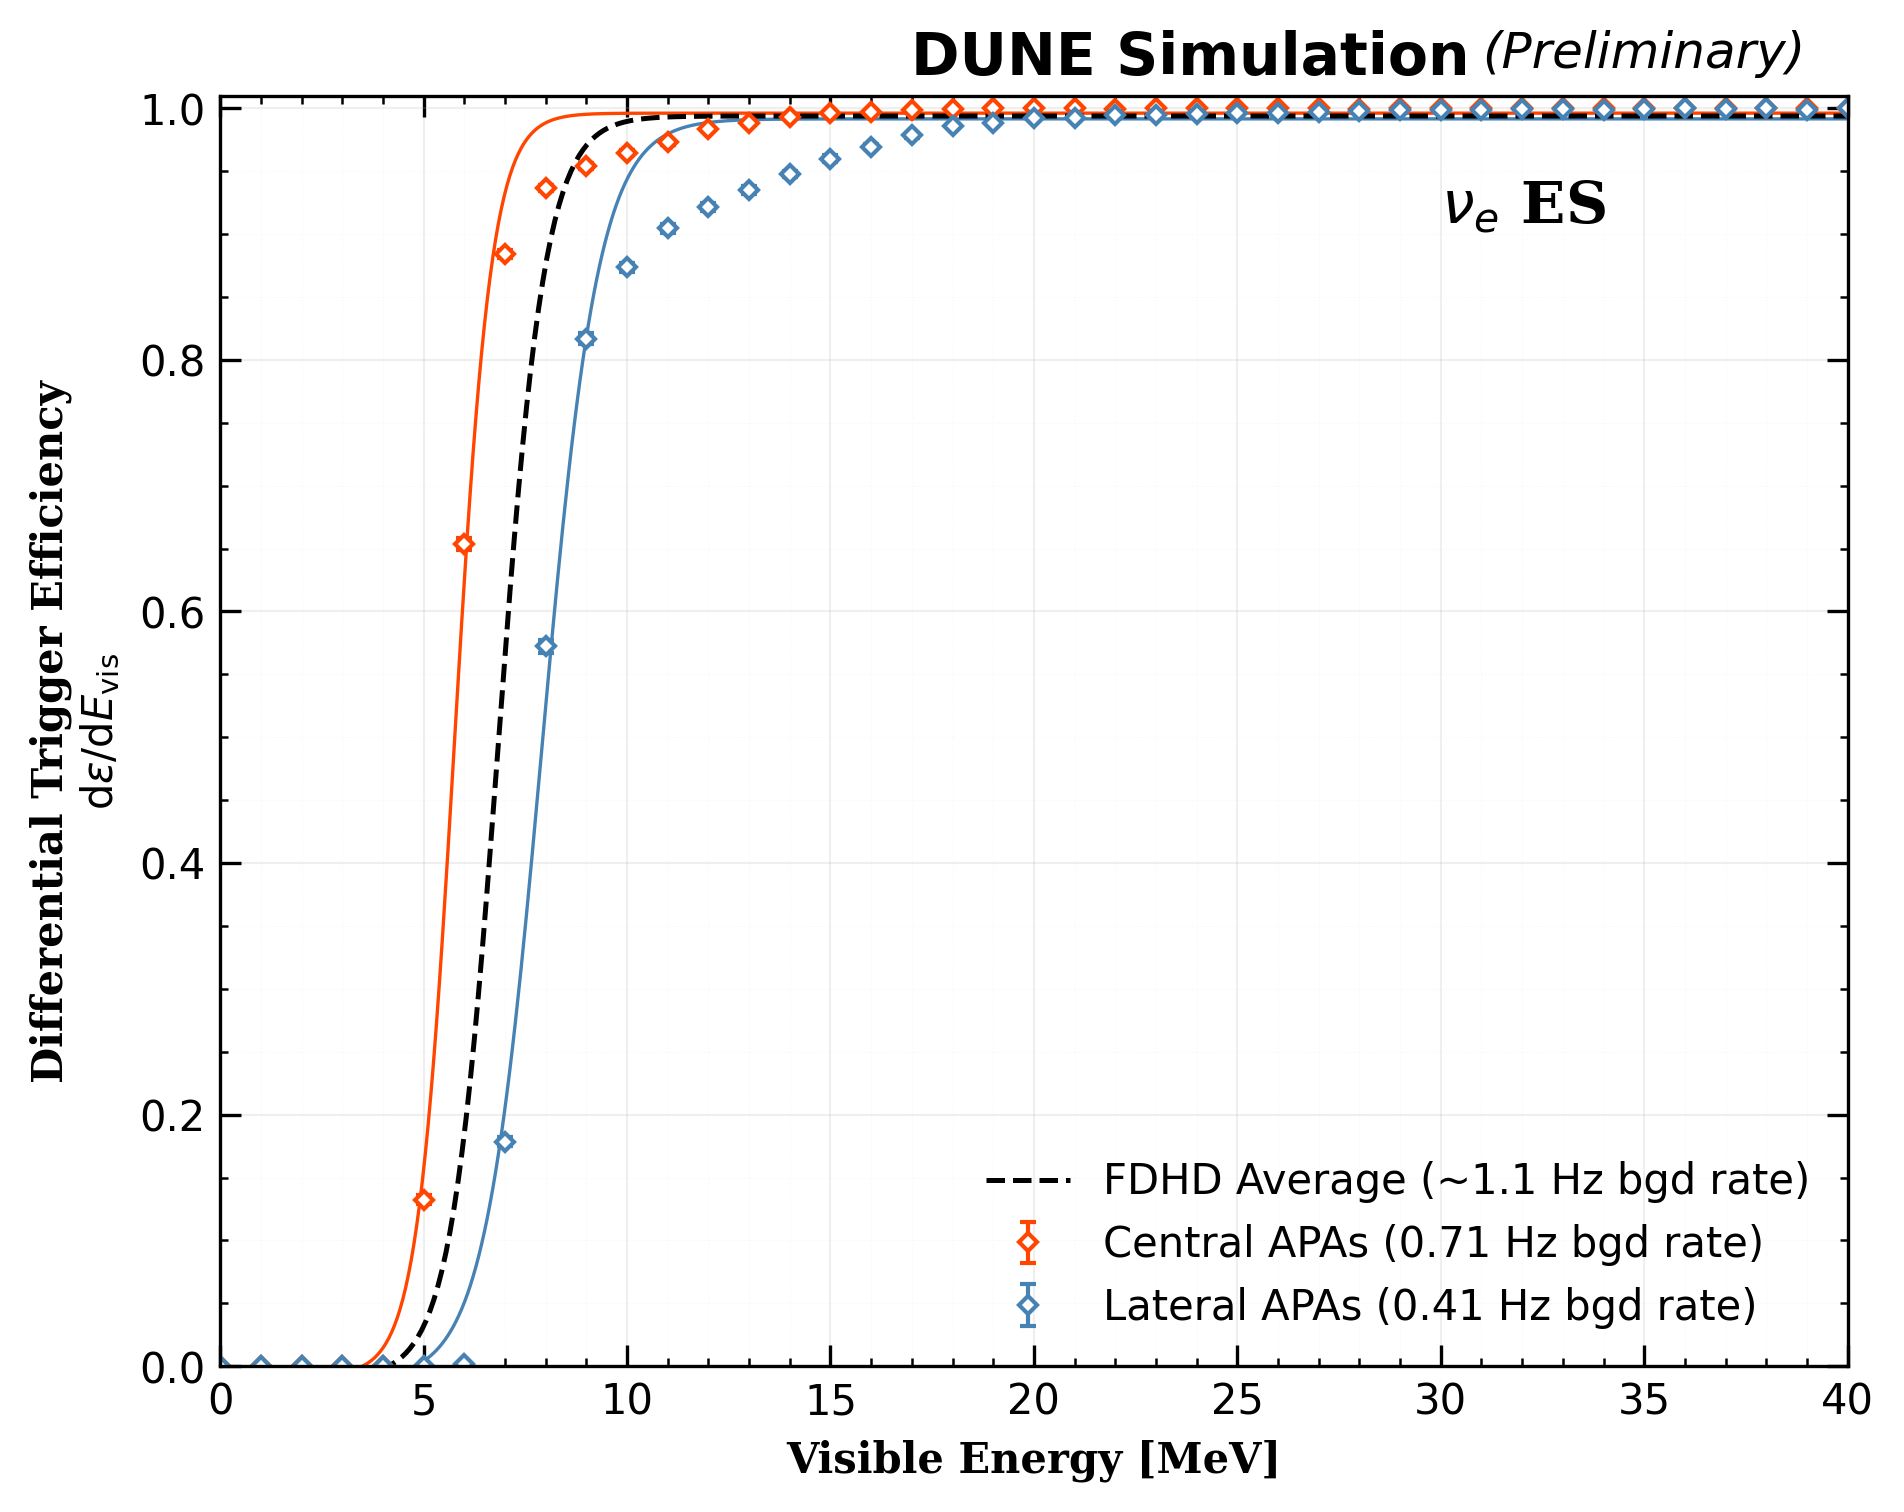


CC
                  50%        75%        90%
-------------------------------------------
Mean            10.1      11.7      13.2


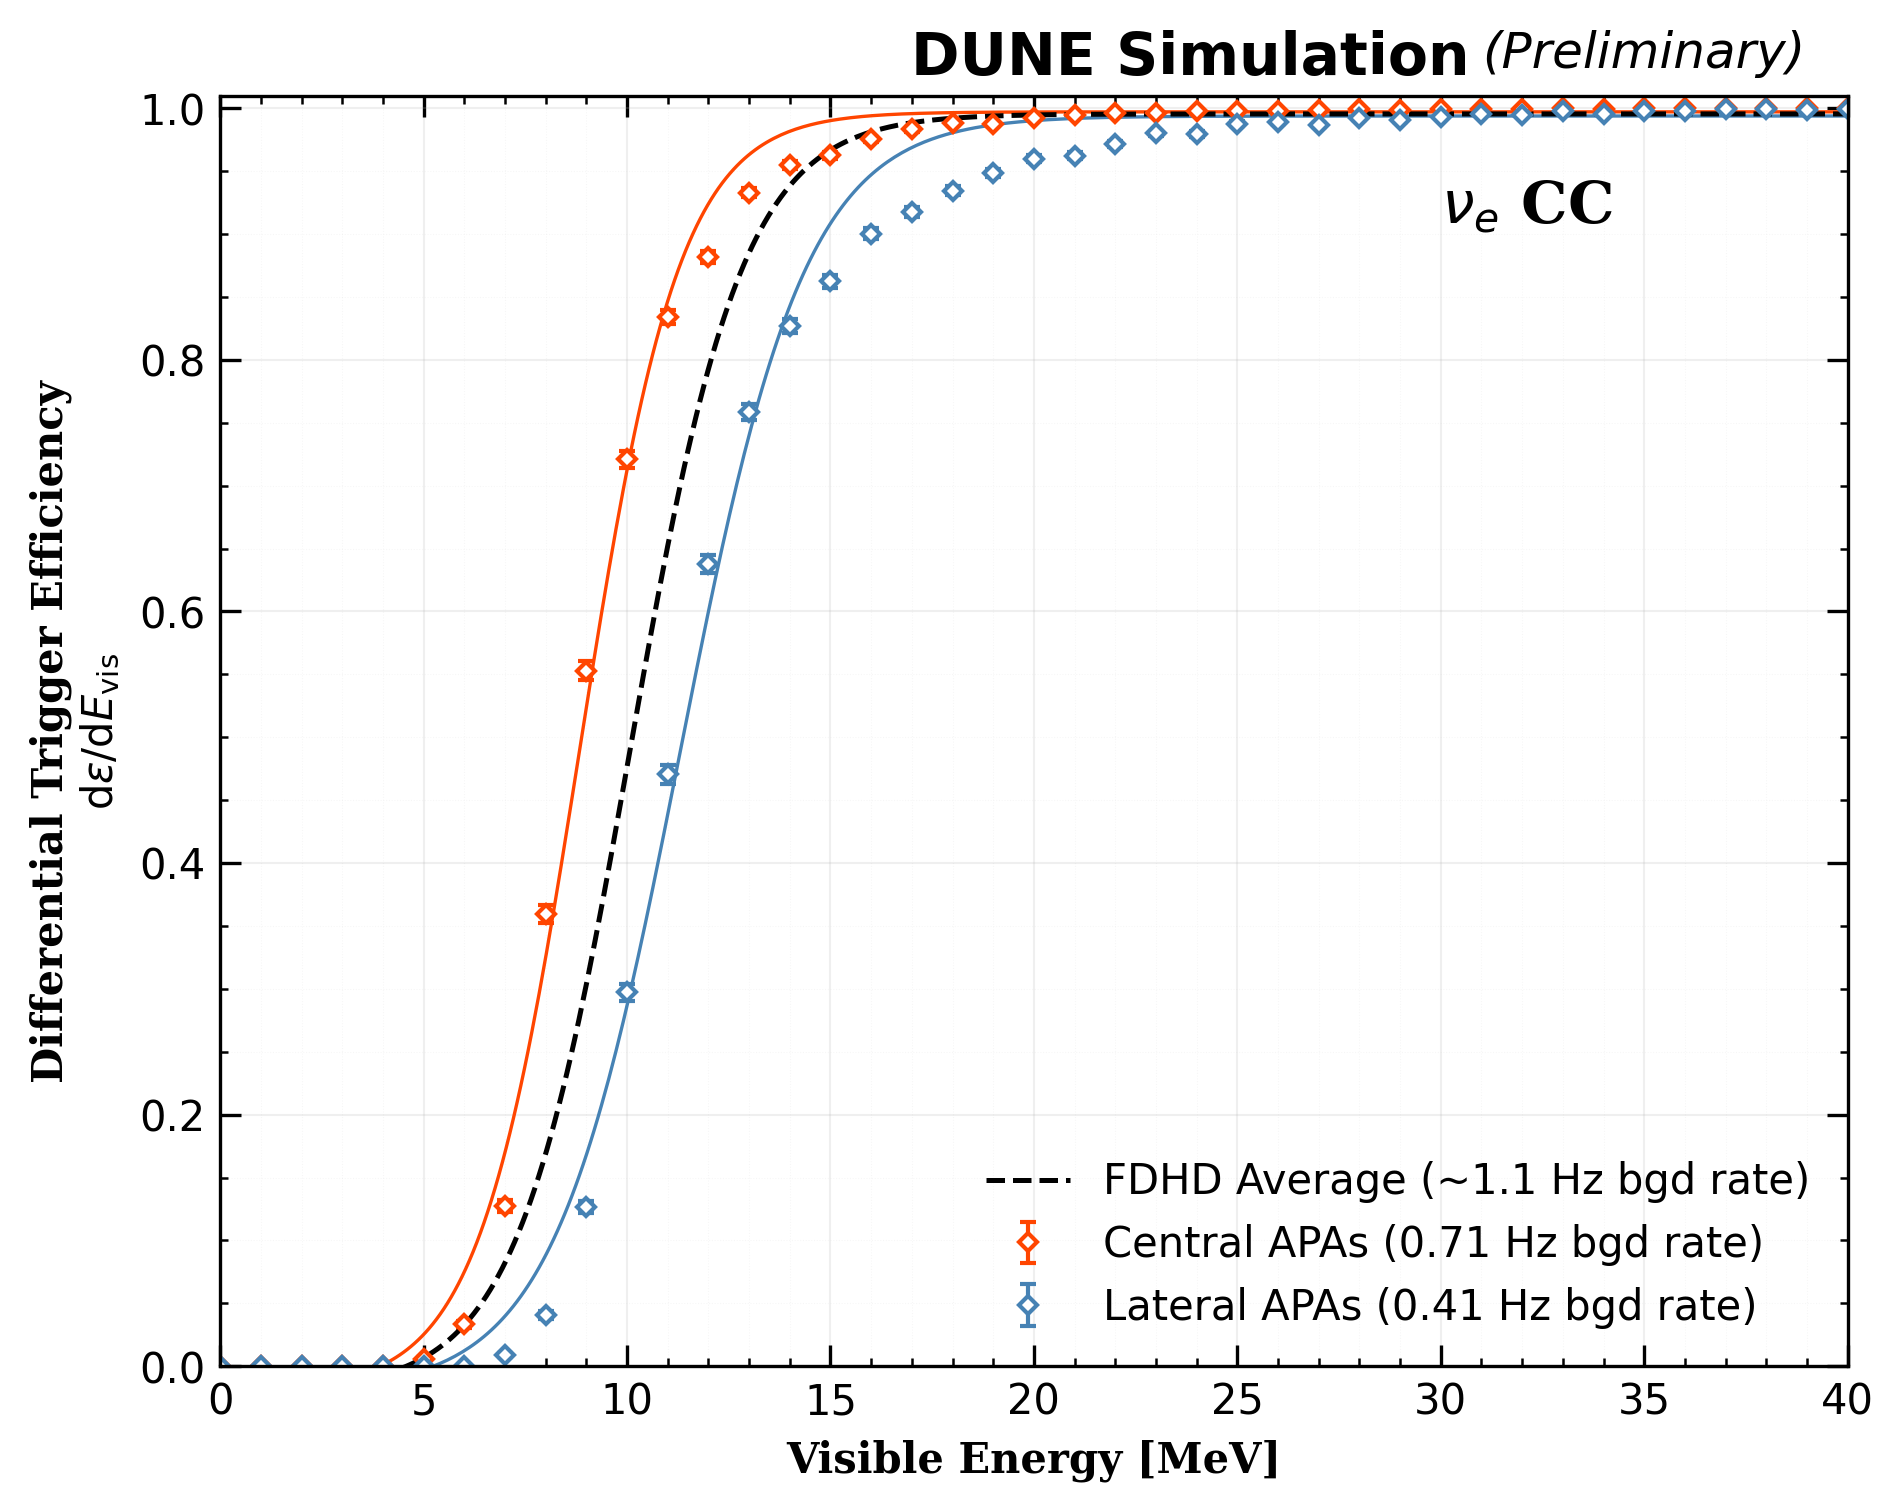

In [20]:
from scipy.optimize import curve_fit

def sigmoid(x, a, b, c, d):
    return a / (1 + np.exp(-(x - b) / c)) + d

def PlotLowECurves(data, label, central_fake_rate, lateral_fake_rate, total_fake_rate):
    fig, ax = plt.subplots(figsize=(7, 5.5), dpi=300)  # use subplots to get ax object

    labels_list = [f'Central APAs ({central_fake_rate:.2g} Hz bgd rate)',
                   f'Lateral APAs ({lateral_fake_rate:.2g} Hz bgd rate)']
    dx = 1
    energies = np.arange(-0.5, 100.5, dx)
    bin_centers = energies[:-1] + dx/2
    cols = [cc, cl]

    popt_list = []

    for idx, df in enumerate(data):
        sensitivity, errors = [], []

        for energy_start in energies[:-1]:
            upper = energy_start + dx
            events_in_bin = df[(df.visible_energy >= energy_start) & (df.visible_energy < upper)]
            accepted_events_in_bin = events_in_bin[(events_in_bin.flag == 2) ]
            n = events_in_bin.event_uid.nunique()
            k = accepted_events_in_bin.event_uid.nunique()

            if n > 0:
                sens = k / n
                err = np.sqrt(sens * (1 - sens) / n)
            else:
                sens = np.nan
                err = 0

            sensitivity.append(sens)
            errors.append(err)

        valid_data = ~np.isnan(sensitivity)
        valid_bin_centers = bin_centers[valid_data]
        valid_sensitivity = np.array(sensitivity)[valid_data]
        valid_errors = np.array(errors)[valid_data]

        # Error bars
        ax.errorbar(valid_bin_centers, valid_sensitivity, yerr=valid_errors,   fmt='D', capsize=2, markersize=3, markerfacecolor='white',  linewidth=1, label=labels_list[idx], c=cols[idx])

        if len(valid_sensitivity) > 0:
            popt, _ = curve_fit(sigmoid, valid_bin_centers, valid_sensitivity, p0=[1, 10, 1, 0])
            popt_list.append(popt)
            x_fit = np.linspace(min(valid_bin_centers), max(valid_bin_centers), 1000)
            y_fit = sigmoid(x_fit, *popt)
            ax.plot(x_fit, y_fit, color=cols[idx], linewidth=0.8)

    # Plot average curve
    if popt_list:
        popt_mean = np.mean(popt_list, axis=0)
        x_fit_mean = np.linspace(min(bin_centers), max(bin_centers), 1000)
        y_fit_mean = sigmoid(x_fit_mean, *popt_mean)
        ax.plot(x_fit_mean, y_fit_mean, 'k--', label=f'FDHD Average (~{total_fake_rate:.2g} Hz bgd rate)',linewidth=1.2)

        levels = (0.5, 0.75, 0.90)
        results = {
            "Mean":    energies_at_efficiency(x_fit_mean, y_fit_mean, levels), }
        print_efficiency_table(label, results)



    ax.set_xlabel("Visible Energy [MeV]",fontweight='bold', family='serif')
    ax.set_ylabel("Differential Trigger Efficiency\n"+ r"$\mathrm{d}\varepsilon / \mathrm{d}E_\mathrm{vis}$", fontweight='bold', family='serif')
    ax.set_xlim(0, 40)
    ax.set_ylim(0, 1.01)
    ax.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.2)
    ax.grid(which='minor', linestyle='dotted', linewidth=0.25, alpha=0.1)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='major', direction='in', top=True, right=True, length =5)
    ax.text(0.75, 0.90, rf"$\nu_e$ {label}", transform=ax.transAxes, fontsize=14, fontweight='bold', family='serif')

    ax.legend( frameon=False, ncol=1)

    fig.text(0.72, 0.92, r"DUNE Simulation", ha='right', va='top', fontsize=14, fontweight='bold')
    fig.text(0.88, 0.92, r"(Preliminary)", ha='right', va='top', fontsize=12, style='italic')
    plt.savefig(f"./figures/lowe_nue_{label}_eff.png")

    plt.show()

PlotLowECurves(data= [trig_es_cent, trig_es_lat], label = 'ES',  central_fake_rate=central_fake_rate, lateral_fake_rate=lateral_fake_rate, total_fake_rate= total_fake_rate)
PlotLowECurves(data= [trig_cc_cent, trig_cc_lat], label = 'CC',  central_fake_rate=central_fake_rate, lateral_fake_rate=lateral_fake_rate, total_fake_rate= total_fake_rate)

In [21]:
trig_cc_cent

event  tpc  window_start  flag     TA_id  total_window_energy  \
0           1  0.0        3000.0   2.0       1.0             127718.0   
1           2 -1.0          -1.0  -1.0      -1.0                 -1.0   
2           3  0.0        2000.0   2.0       3.0             164035.0   
3           3  4.0        2000.0   2.0       4.0              74343.0   
4           4  5.0           0.0   2.0       5.0             243994.0   
...       ...  ...           ...   ...       ...                  ...   
291053   2496  2.0           0.0   0.0  410599.0              25000.0   
291054   2497 -1.0          -1.0  -1.0      -1.0                 -1.0   
291055   2498  4.0        3000.0   2.0  410601.0             205664.0   
291056   2499  2.0        3000.0   2.0  410602.0             148736.0   
291057   2500  1.0        1000.0   2.0  410603.0             132742.0   

        TP_count  n_clusters  mean_cluster_energy total_cluster_energy  \
0           16.0        -1.0                 -1.0                   -1   
1           -1.0        -1.0                 -1.0                   -1   
2           17.0        -1.0                 -1.0                   -1   
3           13.0        -1.0                 -1.0                   -1   
4           17.0        -1.0                 -1.0                   -1   
...          ...         ...                  ...                  ...   
291053       5.0         1.0              19679.0                19679   
291054      -1.0        -1.0                 -1.0                   -1   
291055      28.0        -1.0                 -1.0                   -1   
291056      22.0        -1.0                 -1.0                   -1   
291057      26.0        -1.0                 -1.0                   -1   

       max_cluster_energy   run  visible_energy       event_uid  bgd_energy  
0                      -1  1845       48.127953   7924214661121        6518  
1                      -1  1845        2.937704   7924214661122        5311  
2                      -1  1845       63.584580   7924214661123        3085  
3                      -1  1845       63.584580   7924214661123       13416  
4                      -1  1845       63.342410   7924214661124        2120  
...                   ...   ...             ...             ...         ...  
291053              19679  8496        7.922433  36490042149312        5430  
291054                 -1  8496        3.904213  36490042149313        3617  
291055                 -1  8496       59.508493  36490042149314        1132  
291056                 -1  8496       43.985265  36490042149315         910  
291057                 -1  8496       35.351604  36490042149316        6783  

[291058 rows x 15 columns]

# Supernova Burst

In [22]:
for data_type in ["mc"]:
    for part in ["es", "cc"]:
        globals()[f"{part}_{data_type}"] = pd.read_pickle(f"./low_e/nue_{part}_{data_type}.pkl")

        #get unique event IDs
        util.get_unique_event_ids(globals()[f"{part}_{data_type}"])
        #make sure all the dfs are sorted by the unique event IDs --> important when merging multiple dfs. later on 
        globals()[f"{part}_{data_type}"] = globals()[f"{part}_{data_type}"].sort_values(by="event_uid")



nuecc = cc_mc[(cc_mc.pdg ==12) & (cc_mc.status_code==0)]
nuees = es_mc[(es_mc.pdg ==12) & (es_mc.status_code==0)]

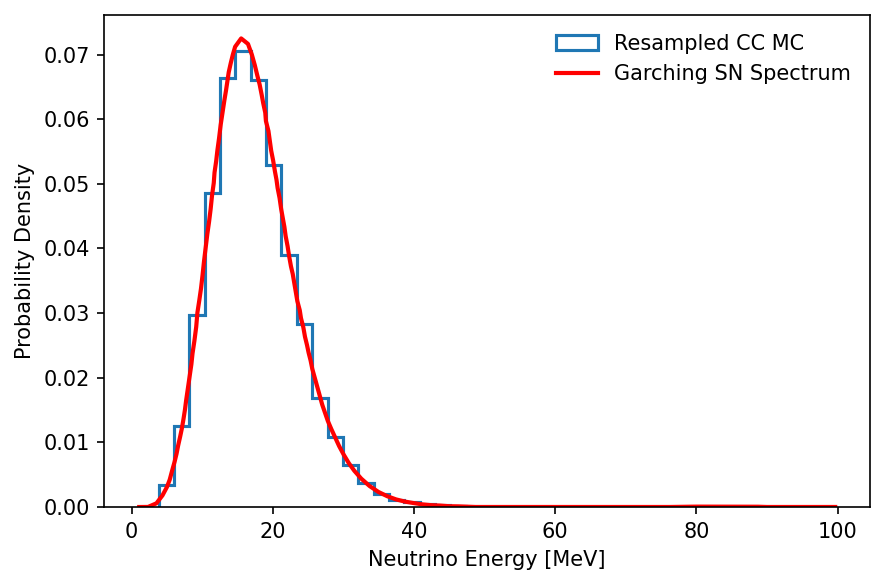

SN single CC efficiency (Garching) in central volume: 0.8092
SN single CC efficiency (Garching) in lateral volume: 0.6633
SN single ES efficiency (Garching) in central volume: 0.5697
SN single ES efficiency (Garching) in lateral volume: 0.4287


In [23]:
Garching = np.loadtxt("./low_e/Garching_SNspectrum.txt", delimiter=',')
gE, gPDF = Garching[:,0], Garching[:,1]
gPDF = gPDF / np.trapezoid(gPDF, gE)
rng = np.random.default_rng(0)

#Resample the flat spectrum to follow the SN garching spectrum 
def resample_to_garching(df):
    E = df['energy'].values * 1000
    interp_pdf = np.interp(E, gE, gPDF, left=0, right=0)
    p_accept = interp_pdf / interp_pdf.max()
    mask = rng.random(len(E)) < p_accept
    return df.loc[mask].reset_index(drop=True)

garching_sample_cc  = resample_to_garching(nuecc)
garching_sample_es  = resample_to_garching(nuees)

#Quick check. 

plt.figure(dpi=150, figsize=(6,4))
plt.hist(garching_sample_cc['energy'] * 1000, bins=30, density=True, histtype='step', linewidth=1.5, label='Resampled CC MC')
plt.plot(gE, gPDF, 'r-', linewidth=2, label='Garching SN Spectrum')
plt.xlabel("Neutrino Energy [MeV]")
plt.ylabel("Probability Density")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


#Compute the trigger efficiencies for individual SN interactions 
def triggered_efficiency(sample, trig_cent, trig_lat, label):
    trig_cent_sel = trig_cent[trig_cent.event_uid.isin(sample.event_uid.unique())]
    trig_lat_sel  = trig_lat[trig_lat.event_uid.isin(sample.event_uid.unique())]

    eff_cent = trig_cent_sel[trig_cent_sel.flag==2].event_uid.nunique() / sample.event_uid.nunique()
    eff_lat  = trig_lat_sel[trig_lat_sel.flag==2].event_uid.nunique() / sample.event_uid.nunique()

    print(f"{label} efficiency (Garching) in central volume: {eff_cent:.4f}")
    print(f"{label} efficiency (Garching) in lateral volume: {eff_lat:.4f}")
    return eff_cent, eff_lat

cc_eff = triggered_efficiency(garching_sample_cc, trig_cc_cent, trig_cc_lat, "SN single CC")
es_eff = triggered_efficiency(garching_sample_es, trig_es_cent, trig_es_lat, "SN single ES")



[226.25  35.5 ]


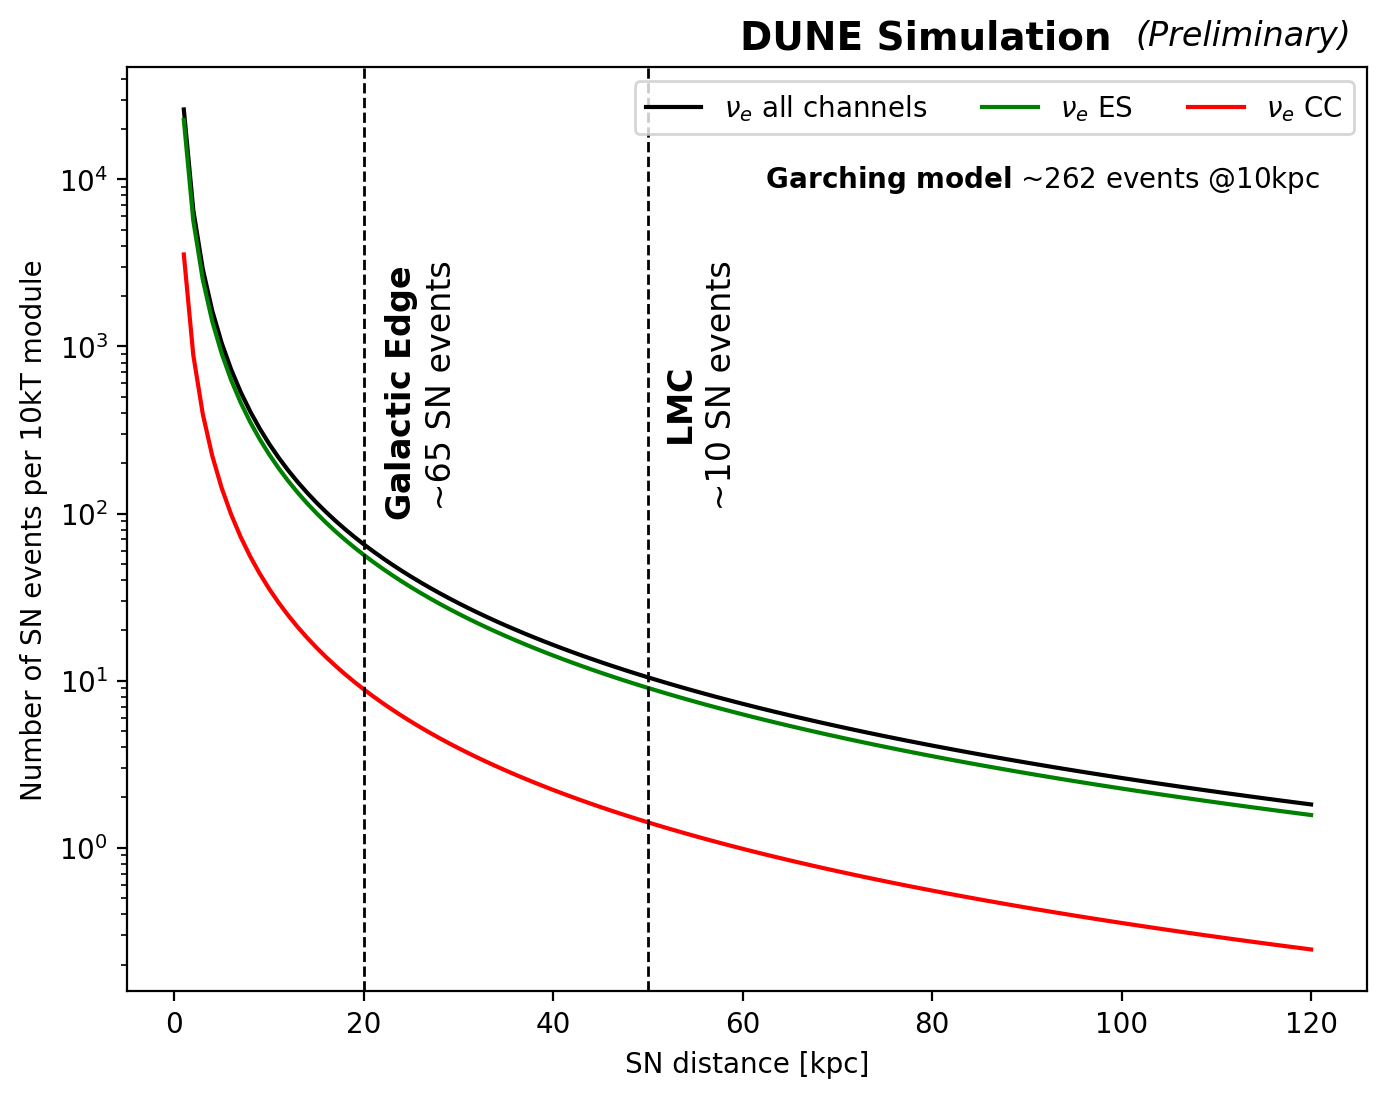

In [24]:
reference_distance = 10
expected_signal_10kpc = np.array([882 + 23, 142])  * 1/4 #scale by number of modules since this assumes 40kT.
print(expected_signal_10kpc)
distances = np.linspace(1, 120, 120)

n_events_cc = []
n_events_es = []
n_events = []

for d in distances:
    signal_at_d = expected_signal_10kpc * (reference_distance / d) ** 2
    n_events_cc.append(signal_at_d[0])
    n_events_es.append(signal_at_d[1])
    n_events.append(np.sum(signal_at_d))
    
fig = plt.figure(figsize=(8, 6), dpi=200)
plt.plot(distances, n_events ,color='k', label = r'$\nu_e$ all channels')
plt.plot(distances, n_events_cc, color ='green', label = r'$\nu_e$ ES')
plt.plot(distances, n_events_es, color='r', label = r'$\nu_e$ CC')
plt.yscale('log')
plt.legend(ncols =3)
plt.xlabel("SN distance [kpc]")
plt.ylabel("Number of SN events per 10kT module")
fig.text(0.87, 0.8, r" $\bf{Garching\ model}$ ~262 events @10kpc", ha='right', va='top', fontsize=10)
fig.text(0.74, 0.92, r"DUNE Simulation", ha='right', va='top', fontsize=14, fontweight='bold')
fig.text(0.89, 0.92, r"(Preliminary)", ha='right', va='top', fontsize=12, style='italic')
plt.axvline(50, color='k', linestyle='--', lw=1, alpha=1)
plt.text(52, 100, r'       $\bf{LMC}$' + '\n ~10 SN events', fontsize=12, color='k', rotation=90)
plt.axvline(20, color='k', linestyle='--', lw=1, alpha=1)
plt.text(22, 100, r'$\bf{Galactic\ Edge}$' + '\n ~65 SN events', fontsize=12, color='k', rotation=90)
plt.savefig("./figures/SN_events_vs_distance.png")
plt.show()

Background mean counts: 11.25
Trigger threshold s_req: 29
[226.25  35.5 ]


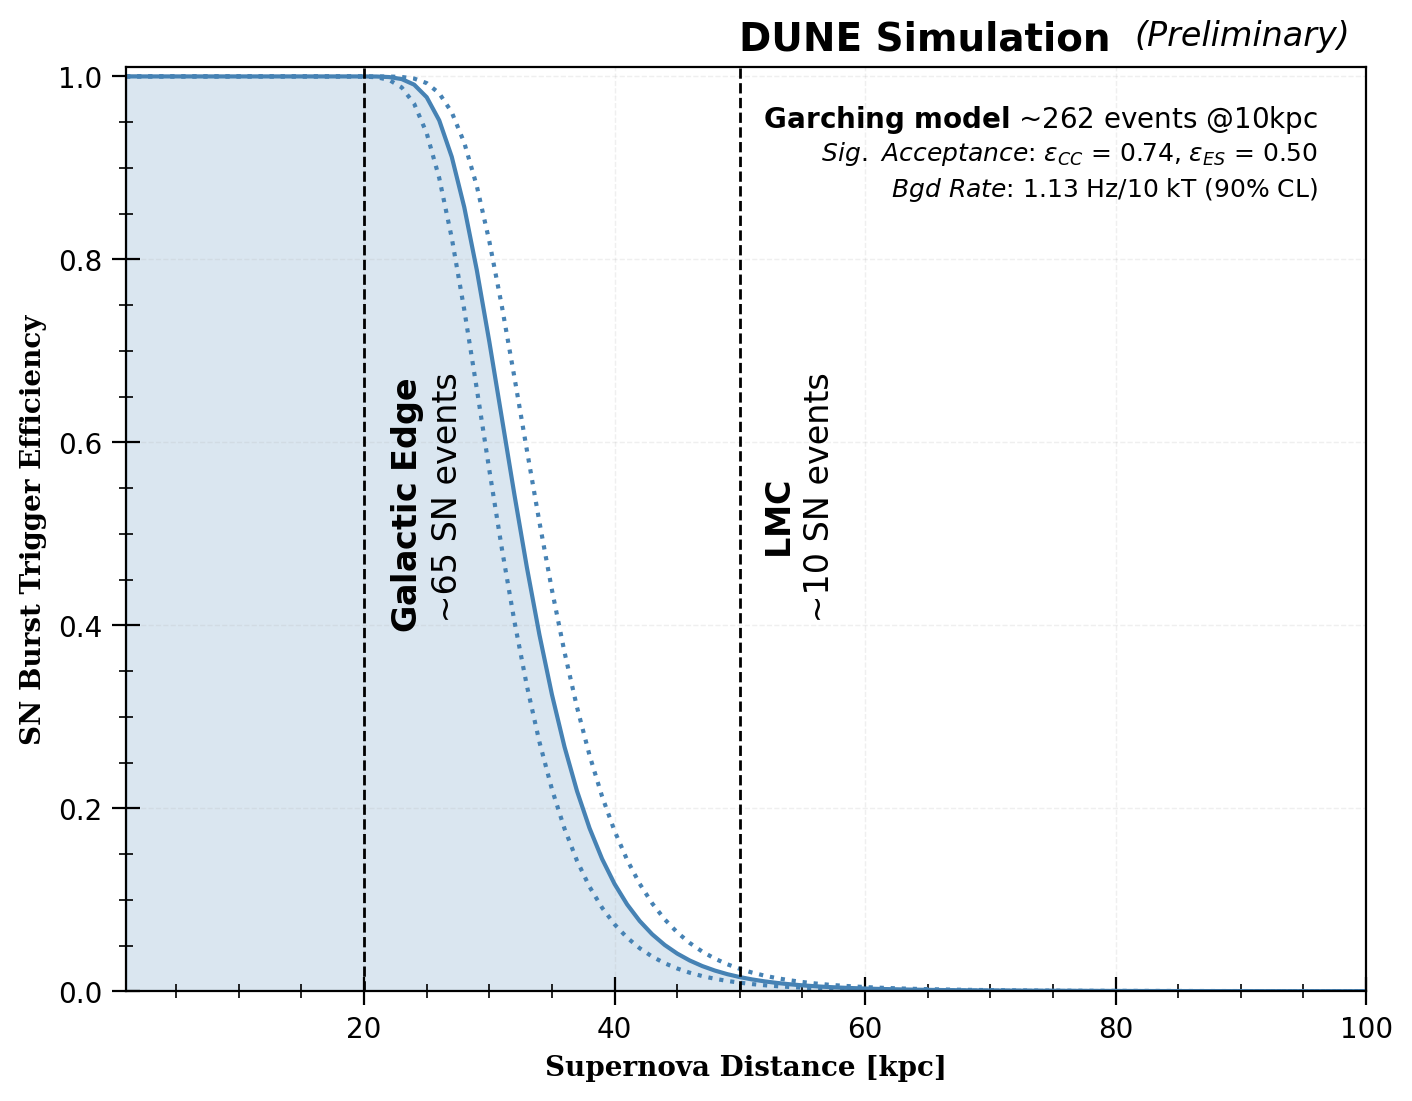

In [25]:
from scipy.stats import poisson, norm

def PlotSNBSen(bgd_rate_hz, cc_efficiencies, es_efficiencies, nmod = 1, CL = 0.9, label = 'inclusive'):

    obs_window_s = 10
    alpha = 1 - norm.cdf(4.46)
    mu_bgd = bgd_rate_hz * obs_window_s
    s_req = int(np.ceil(poisson.ppf(1 - alpha, mu_bgd)))

    print(f"Background mean counts: {mu_bgd:.2f}")
    print(f"Trigger threshold s_req: {s_req}")

    number_of_modules = 4
    reference_distance = 10
    expected_signal_10kpc = np.array([882 + 23, 142])  * nmod/number_of_modules #scale by number of modules since this assumes 40kT.
    print(expected_signal_10kpc)
    distances = np.linspace(1, 120, 120)

    trigger_efficiency = []
    trigger_eff_cent = []
    trigger_eff_lat = []

    for d in distances:
        signal_at_d = expected_signal_10kpc * (reference_distance / d) ** 2
        mu_sig = (signal_at_d[0] * np.mean(cc_efficiencies)) + (signal_at_d[1] * np.mean(es_efficiencies))
        mu_tot = mu_sig + mu_bgd
        eff = 1 - poisson.cdf(s_req - 1, mu_tot)
        trigger_efficiency.append(eff)
        trigger_eff_cent.append(1 - poisson.cdf(s_req - 1, mu_bgd + ((signal_at_d[0] * cc_efficiencies[0]) + (signal_at_d[1] * es_efficiencies[0]))))
        trigger_eff_lat.append(1 - poisson.cdf(s_req - 1, mu_bgd + ((signal_at_d[0] * cc_efficiencies[1]) + (signal_at_d[1] * es_efficiencies[1]))))

    fig = plt.figure(figsize=(8, 6), dpi=200)
    c= 'steelblue'
    plt.plot(distances, trigger_efficiency,  label=rf'Bgd Rate: {bgd_rate_hz:.3f} Hz/10 kT ({int(CL * 100)}$\%$ CL)' + '\n Sig. Acceptance: ' + rf'$\epsilon_{{CC}}$ = {np.mean(cc_efficiencies):.2f}, $\epsilon_{{ES}}$ = {np.mean(es_efficiencies):.2f}', color=c)
    plt.plot(distances, trigger_eff_cent, linestyle='dotted', color=c)
    plt.plot(distances, trigger_eff_lat, linestyle='dotted', color=c)
    plt.fill_between(distances, trigger_efficiency, alpha=0.2, color=c)
    plt.xlabel('Supernova Distance [kpc]', fontweight='bold', family='serif')
    plt.ylabel('SN Burst Trigger Efficiency', fontweight='bold', family='serif')
    plt.grid(linestyle='dashed', alpha=0.2, linewidth=0.5)
    plt.ylim(0, 1.01)
    plt.xlim(1, 100)
    plt.axvline(50, color='k', linestyle='--', lw=1, alpha=1)
    plt.text(52, 0.4, r'       $\bf{LMC}$' + '\n ~10 SN events', fontsize=12, color='k', rotation=90)
    plt.axvline(20, color='k', linestyle='--', lw=1, alpha=1)
    plt.text(22, 0.4, r'$\bf{Galactic\ Edge}$' + '\n ~65 SN events', fontsize=12, color='k', rotation=90)
    plt.minorticks_on()
    plt.tick_params(axis='both', which='minor', direction='inout', length =5)
    plt.tick_params(axis='both', which='major', direction='inout', length=10)
    fig.text(0.87, 0.85, r" $\bf{Garching\ model}$ ~262 events @10kpc", ha='right', va='top', fontsize=10)
    fig.text(0.87, 0.82, r' ${Sig.\ Acceptance}$: ' + rf'$\epsilon_{{CC}}$ = {np.mean(cc_efficiencies):.2f}, $\epsilon_{{ES}}$ = {np.mean(es_efficiencies):.2f}', ha='right', va='top', fontsize=9)
    fig.text(0.87, 0.79, r'${Bgd\ Rate}$:' + rf' {bgd_rate_hz:.2f} Hz/10 kT ({int(CL * 100)}$\%$ CL)', ha='right', va='top', fontsize=9)
    fig.text(0.74, 0.92, r"DUNE Simulation", ha='right', va='top', fontsize=14, fontweight='bold')
    fig.text(0.89, 0.92, r"(Preliminary)", ha='right', va='top', fontsize=12, style='italic')
    plt.savefig(f"./figures/snb_eff_{label}.png")
    plt.show()

PlotSNBSen(total_fake_rate, cc_eff, es_eff)

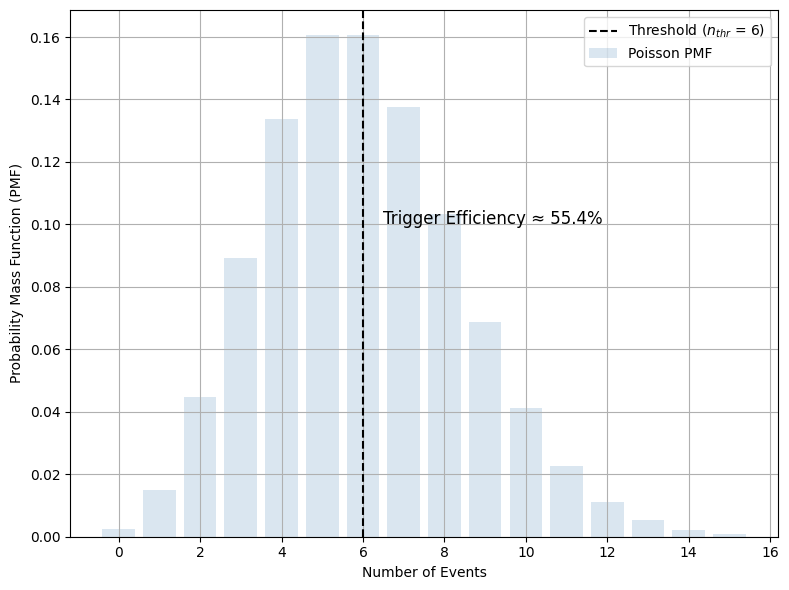

In [26]:
mu_bgd = 6  # Expected number of events (mean of Poisson distribution)
n_thr = 6   # Trigger threshold
max_n = 15  # Maximum number of events to plot

x = np.arange(0, max_n+1)
poisson_probs = poisson.pmf(x, mu_bgd)

plt.figure(figsize=(8, 6))
plt.bar(x, poisson_probs, label="Poisson PMF", color='steelblue', alpha=0.2)
plt.axvline(n_thr, color='k', linestyle='--', label=f'Threshold ($n_{{thr}}$ = {n_thr})')

# Probability of observing >= n_thr events
prob_trigger = 1 - poisson.cdf(n_thr-1, mu_bgd)
plt.text(n_thr+0.5, 0.1, f"Trigger Efficiency ≈ {prob_trigger*100:.1f}%", fontsize=12, color='k')
plt.xlabel('Number of Events')
plt.ylabel('Probability Mass Function (PMF)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<>:36: SyntaxWarning: invalid escape sequence '\s'
<>:36: SyntaxWarning: invalid escape sequence '\s'
/var/folders/1s/mfxsnwp9275ft3r75z4zs6c80000gn/T/ipykernel_2842/2634143014.py:36: SyntaxWarning: invalid escape sequence '\s'
  plt.savefig("figures\sn_window_energies.png")


--- Central APA --- 
 window cut =  48000.0
bgd survival with window energy cut; central: 11
CC selection efficiency in central APAs after cluster + window cut: 0.56
ES selection efficiency in central APAs after cluster + window cut: 0.29
--- Lateral APA --- 
 window cut =  49000.0
bgd survival after window energy cut: 28
CC selection efficiency in lateral APAs after cluster + window cut: 0.54
ES selection efficiency in lateral APAs after cluster + window cut: 0.28


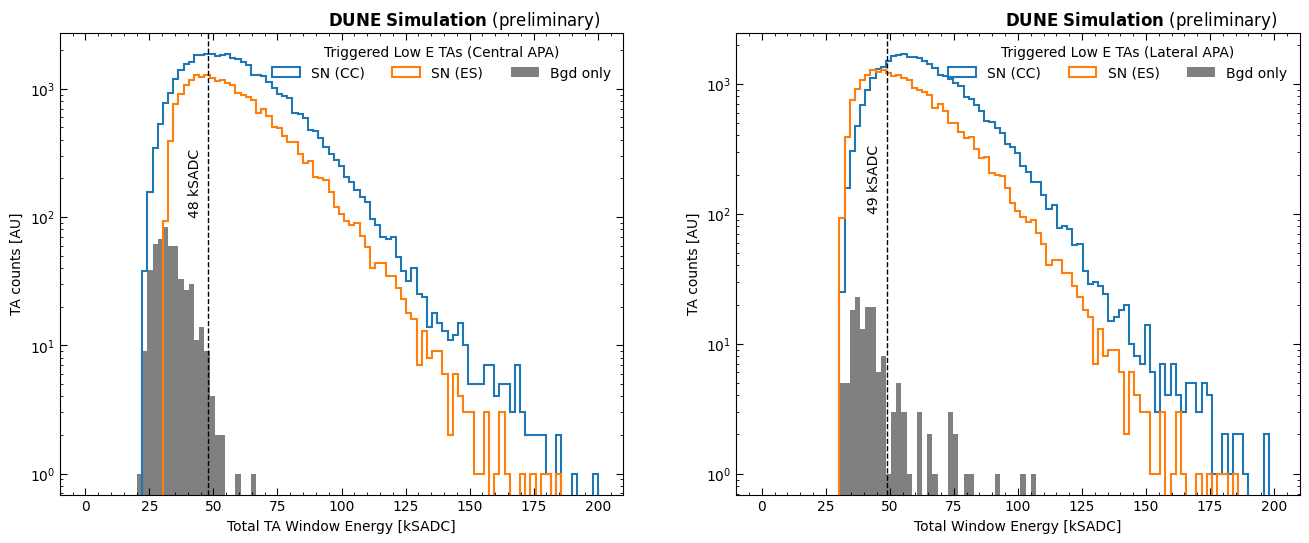

<Figure size 1920x1440 with 0 Axes>

<Figure size 1920x1440 with 0 Axes>

In [27]:
#extracting triggered SN TAs 
def extract_sn_tas(df, sn_events):
    return df[(df.event_uid.isin(sn_events.event_uid.unique())) & (df.flag == 2)]

trig_cent_ccsn = extract_sn_tas(trig_cc_cent, garching_sample_cc) #central vol. CC 
trig_lat_ccsn = extract_sn_tas(trig_cc_lat, garching_sample_cc) #lateral vol. CC
trig_cent_essn = extract_sn_tas(trig_es_lat, garching_sample_es)
trig_lat_essn = extract_sn_tas(trig_es_lat, garching_sample_es)

#triggered backgrounds 
TAcen_triggered = TAcen[TAcen.flag==2]
TAlat_triggered = TAlat[TAlat.flag==2]


#Overlay both TA windows 

def overlay_window_energies(datacc, dataes, data_bgd, window_cut, title, xlabel, ax):
    plt.figure(dpi=300)
    bins = np.linspace(0, 200, 100); dens = False
    ax.hist((datacc.total_window_energy + datacc.bgd_energy) / 1e3, histtype='step', label='SN (CC)', bins=bins, density=dens, linewidth =1.5)
    ax.hist((dataes.total_window_energy + dataes.bgd_energy ) / 1e3, histtype='step', label='SN (ES)', bins=bins, density=dens, linewidth =1.5)
    ax.hist(data_bgd.total_window_energy / 1e3, label='Bgd only', bins=bins, color='grey', density=dens)
    #ax.set_yscale('log')

    ax.axvline(window_cut / 1e3, 0, 350, linestyle='--', color='k', linewidth =1)
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='major', direction='in', top=True, right=True, length =5)
    ax.text(0.96, 1.05, r'$\bf{DUNE\ Simulation}$ (preliminary)', ha='right', va='top', fontsize=12,transform=ax.transAxes)   
  
    ax.minorticks_on()
    ax.legend(title=f"Triggered Low E TAs ({title})",loc='upper right',ncols=3, frameon=False)
    ax.text((window_cut/1e3) - 5, 100, f"{(window_cut/1e3):1g} kSADC", rotation=90, ha='center', va='bottom')
    ax.set_xlabel(xlabel)
    ax.set_ylabel("TA counts [AU]")
    ax.set_yscale('log')
    plt.savefig("figures\sn_window_energies.png")


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Central APA, effect of window cuts on fake rate 
window_cut_cen = 48e3
overlay_window_energies(trig_cent_ccsn, trig_cent_essn, TAcen_triggered, window_cut_cen, "Central APA", "Total TA Window Energy [kSADC]", ax=axes[0])

print("--- Central APA --- \n window cut = ", window_cut_cen)
#bgd survival 
fake_events_cent = TAcen_triggered[(TAcen_triggered.total_window_energy > window_cut_cen) ].TA_id.nunique()
print(f"bgd survival with window energy cut; central: {fake_events_cent}")

#signal survival
surv_ccc = trig_cent_ccsn[((trig_cent_ccsn.total_window_energy + trig_cent_ccsn.bgd_energy)  > window_cut_cen)].event_uid.nunique() / garching_sample_cc.event_uid.nunique()
print(f"CC selection efficiency in central APAs after cluster + window cut: {surv_ccc:.2f}")
surv_esc = trig_cent_essn[((trig_cent_essn.total_window_energy + trig_cent_essn.bgd_energy )  > window_cut_cen)].event_uid.nunique() / garching_sample_es.event_uid.nunique()
print(f"ES selection efficiency in central APAs after cluster + window cut: {surv_esc:.2f}")




# Lateral APA, effect of window cuts on fake rate 
window_cut_lat = 49e3
overlay_window_energies(trig_lat_ccsn, trig_lat_essn, TAlat_triggered, window_cut_lat, "Lateral APA", "Total Window Energy [kSADC]", ax = axes[1])

print("--- Lateral APA --- \n window cut = ", window_cut_lat)
# bgd survival 
fake_events_lat = TAlat_triggered[(TAlat_triggered.total_window_energy > window_cut_lat)].TA_id.nunique()
print(f"bgd survival after window energy cut: {fake_events_lat}")

#overall signal survival after cluster + window cuts
surv_ccl = trig_lat_ccsn[(trig_lat_ccsn.total_window_energy + trig_lat_ccsn.bgd_energy )> window_cut_lat].event_uid.nunique() / garching_sample_cc.event_uid.nunique()
print(f"CC selection efficiency in lateral APAs after cluster + window cut: {surv_ccl:.2f}")
surv_esl = trig_lat_essn[(trig_lat_essn.total_window_energy  + trig_lat_essn.bgd_energy) > window_cut_lat].event_uid.nunique() / garching_sample_es.event_uid.nunique()
print(f"ES selection efficiency in lateral APAs after cluster + window cut: {surv_esl:.2f}")



bgd livetime (min):  8.926245210727968
39
Background mean counts: 0.73
Trigger threshold s_req: 7
[226.25  35.5 ]


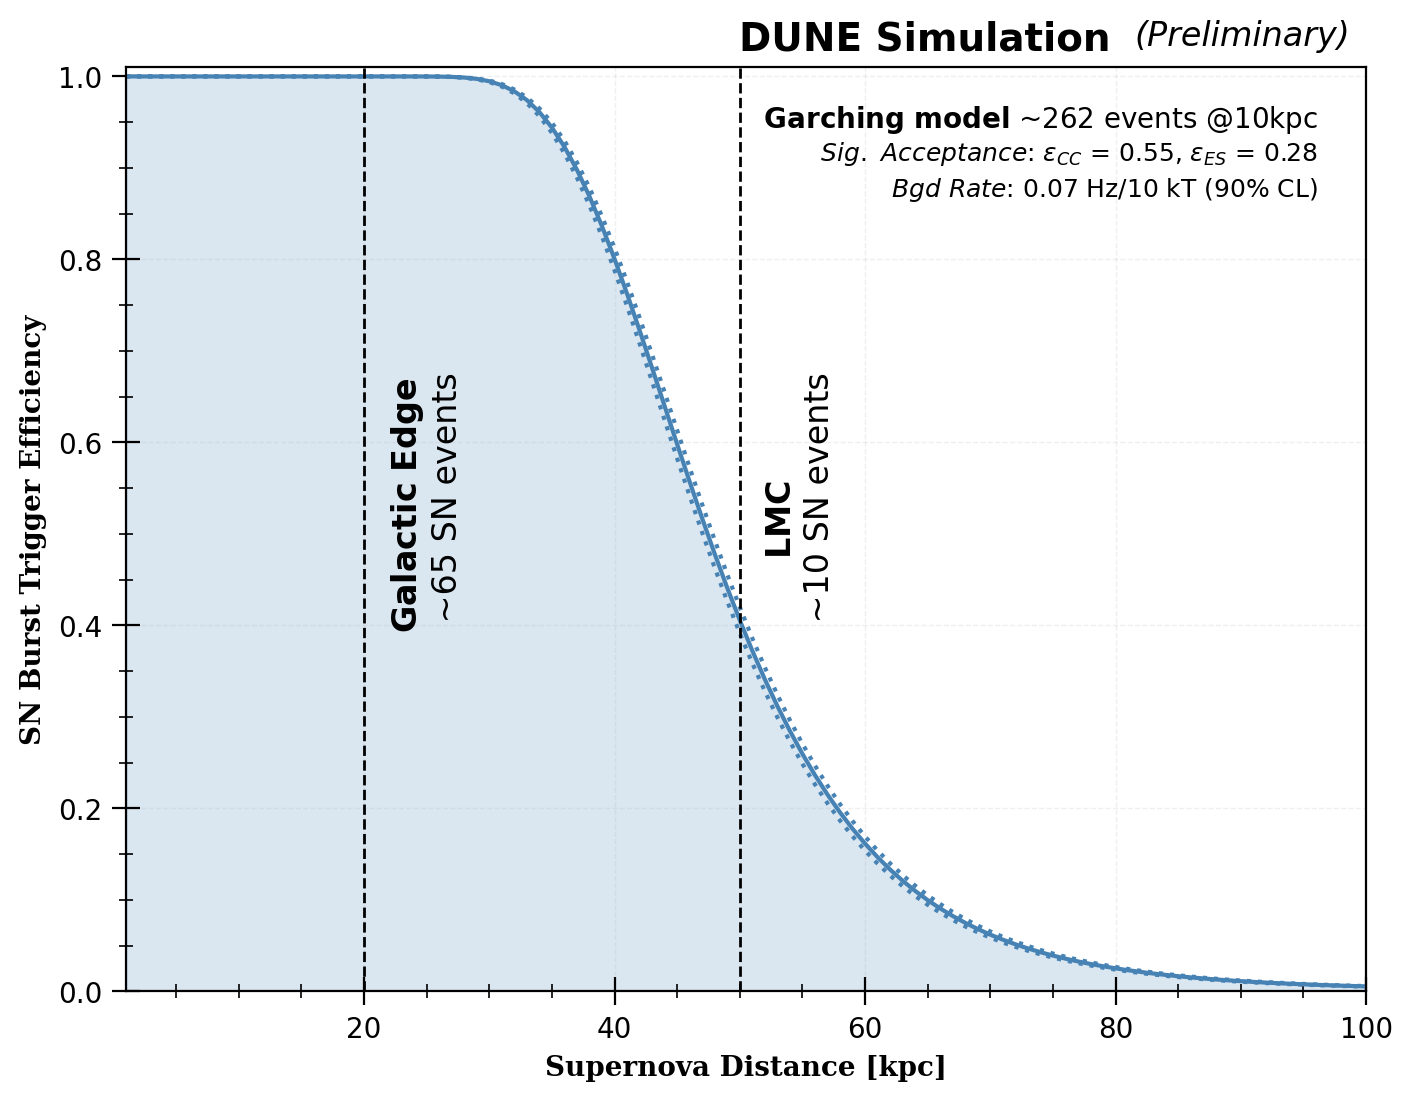

In [28]:
from scipy.stats import poisson
from scipy.optimize import brentq

def poisson_rate_upper_limit(n_obs, T, CL=0.9):
    """
    Poisson upper limit on bgd fake rate (Hz) for SNB.

    n_obs : Number of observed background events.
    T : Observation time in seconds.
    CL : Confidence level upper limit 

    Returns upper limit on background rate in Hz.
    """
    target = 1 - CL  # tail probability

    #  CDF condition: P(k ≤ n | λ) = 1 - CL
    def eqn(lam):
        return poisson.cdf(n_obs, lam) - target

    # Solve for λ_upper
    lam_ul = brentq(eqn, 0, 50)
    return lam_ul / T

CL = 0.90 #confidence upper limit on bgd rate
n_fake_events = fake_events_cent+fake_events_lat #number of observed bgd events
livetime = np.mean([central_livetime, lateral_livetime]) #observation time
print("bgd livetime (min): " , livetime/60)
#projected_fake_rate =  poisson_rate_upper_limit(n_obs =n_fake_events,T= livetime, CL=CL)
#print("Projected fake rate: " , projected_fake_rate, 'Hz')
print(n_fake_events)

cc_eff_ = [surv_ccc, surv_ccl]
es_eff_ = [surv_esc, surv_esl]

#cc_eff = [surv_ccc_clust, surv_ccl_clust]
#es_eff = [surv_esc_clust, surv_esl_clust]

true_fake_rate = n_fake_events/livetime
#use the true fake rate since the observation window is decent 

PlotSNBSen(true_fake_rate, cc_eff_, es_eff_, nmod = 1, label = 'selective')


# Solar Neutrinos

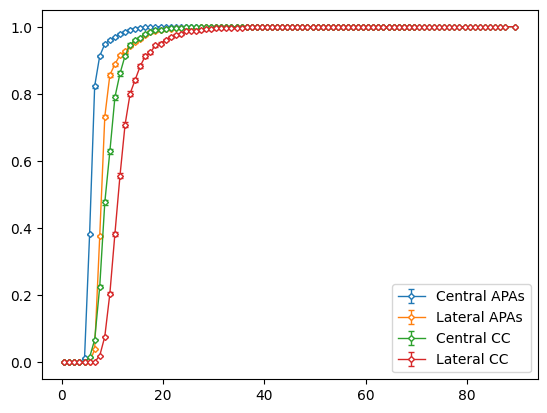

In [29]:
dx = 1
energies = np.arange(0, 100, dx)

def save_to_file(filename, bin_centers, sensitivity):
    data = np.column_stack((bin_centers, sensitivity))
    np.savetxt(filename, data, delimiter=',', header="Energy [MeV],Trigger Efficiency", fmt="%.4f")

data = [
    (trig_es_cent, 'solar_data/trig_eff_es_central.txt', 'Central APAs'),
    (trig_es_lat, 'solar_data/trig_eff_es_lateral.txt', 'Lateral APAs'),
    (trig_cc_cent, 'solar_data/trig_eff_cc_central.txt', 'Central CC'),
    (trig_cc_lat, 'solar_data/trig_eff_cc_lateral.txt', 'Lateral CC')
]

for idx, (df, filename, label) in enumerate(data):
    sensitivity, errors = [], []
    bin_centers = (energies[:-1] + energies[1:]) / 2
    
    for energy_start in energies[:-1]:
        upper = energy_start + dx
        events_in_bin = df[(df.visible_energy >= energy_start) & (df.visible_energy < upper)]
        accepted_events_in_bin = events_in_bin[(events_in_bin.flag == 2)]
        n, k = events_in_bin.event_uid.nunique(), accepted_events_in_bin.event_uid.nunique()
        sens, err = (k / n, np.sqrt(sens * (1 - sens) / n)) if n > 0 else (np.nan, 0)
        sensitivity.append(sens)
        errors.append(err)

    valid_data = ~np.isnan(sensitivity)
    valid_bin_centers = bin_centers[valid_data]
    valid_sensitivity = np.array(sensitivity)[valid_data]
    valid_errors = np.array(errors)[valid_data]
    
    plt.errorbar(valid_bin_centers, valid_sensitivity, yerr=valid_errors, fmt='D-', capsize=2, markersize=3, markerfacecolor='white', linewidth=1, label=label,)
    #save_to_file(filename, valid_bin_centers, valid_sensitivity)
    plt.legend()


In [30]:

from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

def calculate_triggered_fraction(trig_file, sol_file, Emin=0, Emax=25, Egrid_points=100):
    trig = pd.read_csv(trig_file)
    sol  = pd.read_csv(sol_file)

    E_trig, eff = trig.iloc[:,0].values, trig.iloc[:,1].values
    E_sol, surv = sol.iloc[:,0].values, sol.iloc[:,1].values

    sort_trig = np.argsort(E_trig)
    sort_sol  = np.argsort(E_sol)
    E_trig, eff = E_trig[sort_trig], eff[sort_trig]
    E_sol, surv = E_sol[sort_sol], surv[sort_sol]

    Egrid = np.linspace(Emin, Emax, Egrid_points)
    interp_eff = interp1d(E_trig, eff, kind='linear', bounds_error=False, fill_value=(eff[0], eff[-1]))
    interp_surv = interp1d(E_sol, surv, kind='linear', bounds_error=False, fill_value=(surv[0], surv[-1]))

    eff_i = interp_eff(Egrid)
    surv_i = interp_surv(Egrid)

    if np.nanmax(surv_i) > 1.5:
        surv_i = surv_i / 100.0

    smooth_surv = savgol_filter(surv_i, window_length=15, polyorder=3)
    dSdE = np.gradient(smooth_surv, Egrid)
    fE = -dSdE
    fE = np.clip(fE, 0, None)
    fE /= np.trapezoid(fE, Egrid)

    triggered_fraction = np.trapezoid(eff_i * fE, Egrid)
    return triggered_fraction


#central APAs, CC
hep_triggered_fraction_cent = calculate_triggered_fraction("solar_data/trig_eff_cc_central.txt", "solar_data/solar_surv_hep_cc.txt")
b8_triggered_fraction_cent = calculate_triggered_fraction("solar_data/trig_eff_cc_central.txt", "solar_data/solar_surv_B8_cc.txt")

print(f"hep solar CC neutrino trigger efficiency (central APA - 5kT -  0.5 Hz fake rate) = {hep_triggered_fraction_cent:.2f}")
print(f"B-8 solar CC neutrino trigger efficiency (central APA - 5kT -  0.5 Hz fake rate) = {b8_triggered_fraction_cent:.2f}", '\n')


#lateral APAs, CC
hep_triggered_fraction_lat = calculate_triggered_fraction("solar_data/trig_eff_cc_lateral.txt", "solar_data/solar_surv_hep_cc.txt")
b8_triggered_fraction_lat = calculate_triggered_fraction("solar_data/trig_eff_cc_lateral.txt", "solar_data/solar_surv_B8_cc.txt")

print(f"hep solar CC neutrino trigger efficiency (lateral APA - 5kT - 0.5 Hz fake rate) = {hep_triggered_fraction_lat:.2f}")
print(f"B-8 solar CC neutrino trigger efficiency (lateral APA - 5kT -  0.5 Hz fake rate) = {b8_triggered_fraction_lat:.2f}", '\n')

#central APAs, ES 
hep_triggered_fraction_cent_es = calculate_triggered_fraction("solar_data/trig_eff_es_central.txt", "solar_data/solar_surv_hep_es.txt")
b8_triggered_fraction_cent_es = calculate_triggered_fraction("solar_data/trig_eff_es_central.txt", "solar_data/solar_surv_B8_es.txt")

print(f"hep solar ES neutrino trigger efficiency (central APA - 5kT -  0.5 Hz fake rate) = {hep_triggered_fraction_cent_es:.2f}")
print(f"B-8 solar ES neutrino trigger efficiency (central APA - 5kT -  0.5 Hz fake rate) = {b8_triggered_fraction_cent_es:.2f}", '\n')

#lateral APAs, ES
hep_triggered_fraction_lat_es = calculate_triggered_fraction("solar_data/trig_eff_es_lateral.txt", "solar_data/solar_surv_hep_es.txt")
b8_triggered_fraction_lat_es = calculate_triggered_fraction("solar_data/trig_eff_es_lateral.txt", "solar_data/solar_surv_B8_es.txt")

print(f"hep solar ES neutrino trigger efficiency (lateral APA - 5kT -  0.5 Hz fake rate) = {hep_triggered_fraction_lat_es:.2f}")
print(f"B-8 solar ES neutrino trigger efficiency (lateral APA - 5kT -  0.5 Hz fake rate) = {b8_triggered_fraction_lat_es:.2f}", '\n')


def get_fulfd_proj(df_cent, df_lat):
    return (df_cent + df_lat)/2

hep_cc = get_fulfd_proj(hep_triggered_fraction_cent,  hep_triggered_fraction_lat)
print("hep cc", hep_cc)
hep_es = get_fulfd_proj(hep_triggered_fraction_cent_es,  hep_triggered_fraction_lat_es)
print("hep es", hep_es)

b8_cc = get_fulfd_proj(b8_triggered_fraction_cent,  b8_triggered_fraction_lat)
print("b8_cc", b8_cc) 
b8_es = get_fulfd_proj(b8_triggered_fraction_cent_es,  b8_triggered_fraction_lat_es)
print("b8_es", b8_es) 

hep solar CC neutrino trigger efficiency (central APA - 5kT -  0.5 Hz fake rate) = 0.75
B-8 solar CC neutrino trigger efficiency (central APA - 5kT -  0.5 Hz fake rate) = 0.44 

hep solar CC neutrino trigger efficiency (lateral APA - 5kT - 0.5 Hz fake rate) = 0.52
B-8 solar CC neutrino trigger efficiency (lateral APA - 5kT -  0.5 Hz fake rate) = 0.17 

hep solar ES neutrino trigger efficiency (central APA - 5kT -  0.5 Hz fake rate) = 0.38
B-8 solar ES neutrino trigger efficiency (central APA - 5kT -  0.5 Hz fake rate) = 0.22 

hep solar ES neutrino trigger efficiency (lateral APA - 5kT -  0.5 Hz fake rate) = 0.23
B-8 solar ES neutrino trigger efficiency (lateral APA - 5kT -  0.5 Hz fake rate) = 0.08 

hep cc 0.6329675668599763
hep es 0.3061795614175945
b8_cc 0.3074821856828389
b8_es 0.15383524217510725


Central APA. Cluster cut = 16.0 kSADC. Fake rate: 1.5245952752128553 Hz
Leteral APA. Cluster cut = 25.0 kSADC. Fake rate: 1.3398809038257606 Hz


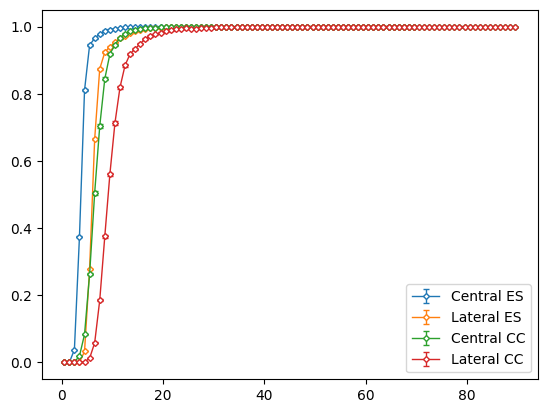

In [31]:
#Lowering the cuts, and allowing for higher fake rate 
cut_cent = 16e3; cut_lat = 25e3

central_fake_rate_relaxed = GetFakeRatevsClustCut(TAcen, volume = 'central', cluster_cut = cut_cent);  
lateral_fake_rate_relaxed = GetFakeRatevsClustCut(TAlat, volume = 'lateral', cluster_cut = cut_lat) 
print(f"Central APA. Cluster cut = {cut_cent/1e3} kSADC. Fake rate: { central_fake_rate_relaxed} Hz")
print(f"Leteral APA. Cluster cut = {cut_lat/1e3} kSADC. Fake rate: {lateral_fake_rate_relaxed } Hz")


from scipy.optimize import curve_fit
dx=2
def save_to_file(filename, bin_centers, sensitivity):
    data = np.column_stack((bin_centers, sensitivity))
    np.savetxt(filename, data, delimiter=',', header="Energy [MeV],Trigger Efficiency", fmt="%.4f")

data = [(trig_es_cent, 'solar_data/trig_eff_es_central_3Hz.txt', 'Central ES'),
        (trig_es_lat, 'solar_data/trig_eff_es_lateral_3Hz.txt', 'Lateral ES'),
        (trig_cc_cent, 'solar_data/trig_eff_cc_central_3Hz.txt', 'Central CC'),
        (trig_cc_lat, 'solar_data/trig_eff_cc_lateral_3Hz.txt', 'Lateral CC')]

for idx, (df, filename, label) in enumerate(data):
    sensitivity, errors = [], []
    for energy_start in energies[:-1]:
        upper = energy_start + dx
        events_in_bin = df[(df.visible_energy >= energy_start) & (df.visible_energy < upper)]
        #accepted_events_in_bin = events_in_bin[((events_in_bin.flag == 2) & (events_in_bin.n_clusters <0)) |((events_in_bin.max_cluster_energy > 16e3) & (events_in_bin.n_clusters >0))]
        if 'Central' in label:
            accepted_events_in_bin = events_in_bin[((events_in_bin.flag == 2) & (events_in_bin.n_clusters <=0)) |((events_in_bin.max_cluster_energy > cut_cent) & (events_in_bin.n_clusters >0))]
        elif 'Lateral' in label:
            accepted_events_in_bin = events_in_bin[((events_in_bin.flag == 2) & (events_in_bin.n_clusters<=0)) |((events_in_bin.max_cluster_energy > cut_lat) & (events_in_bin.n_clusters >0))]
        n, k = events_in_bin.event_uid.nunique(), accepted_events_in_bin.event_uid.nunique()
        sens, err = (k / n, np.sqrt(sens * (1 - sens) / n)) if n > 0 else (np.nan, 0)
        sensitivity.append(sens)
        errors.append(err)

    valid_data = ~np.isnan(sensitivity)
    valid_bin_centers = bin_centers[valid_data]
    valid_sensitivity = np.array(sensitivity)[valid_data]
    valid_errors = np.array(errors)[valid_data]
    
    plt.errorbar(valid_bin_centers, valid_sensitivity, yerr=valid_errors, fmt='D-', capsize=2, markersize=3, markerfacecolor='white', linewidth=1, label=label,)
    plt.legend()
    save_to_file(filename, valid_bin_centers, valid_sensitivity)


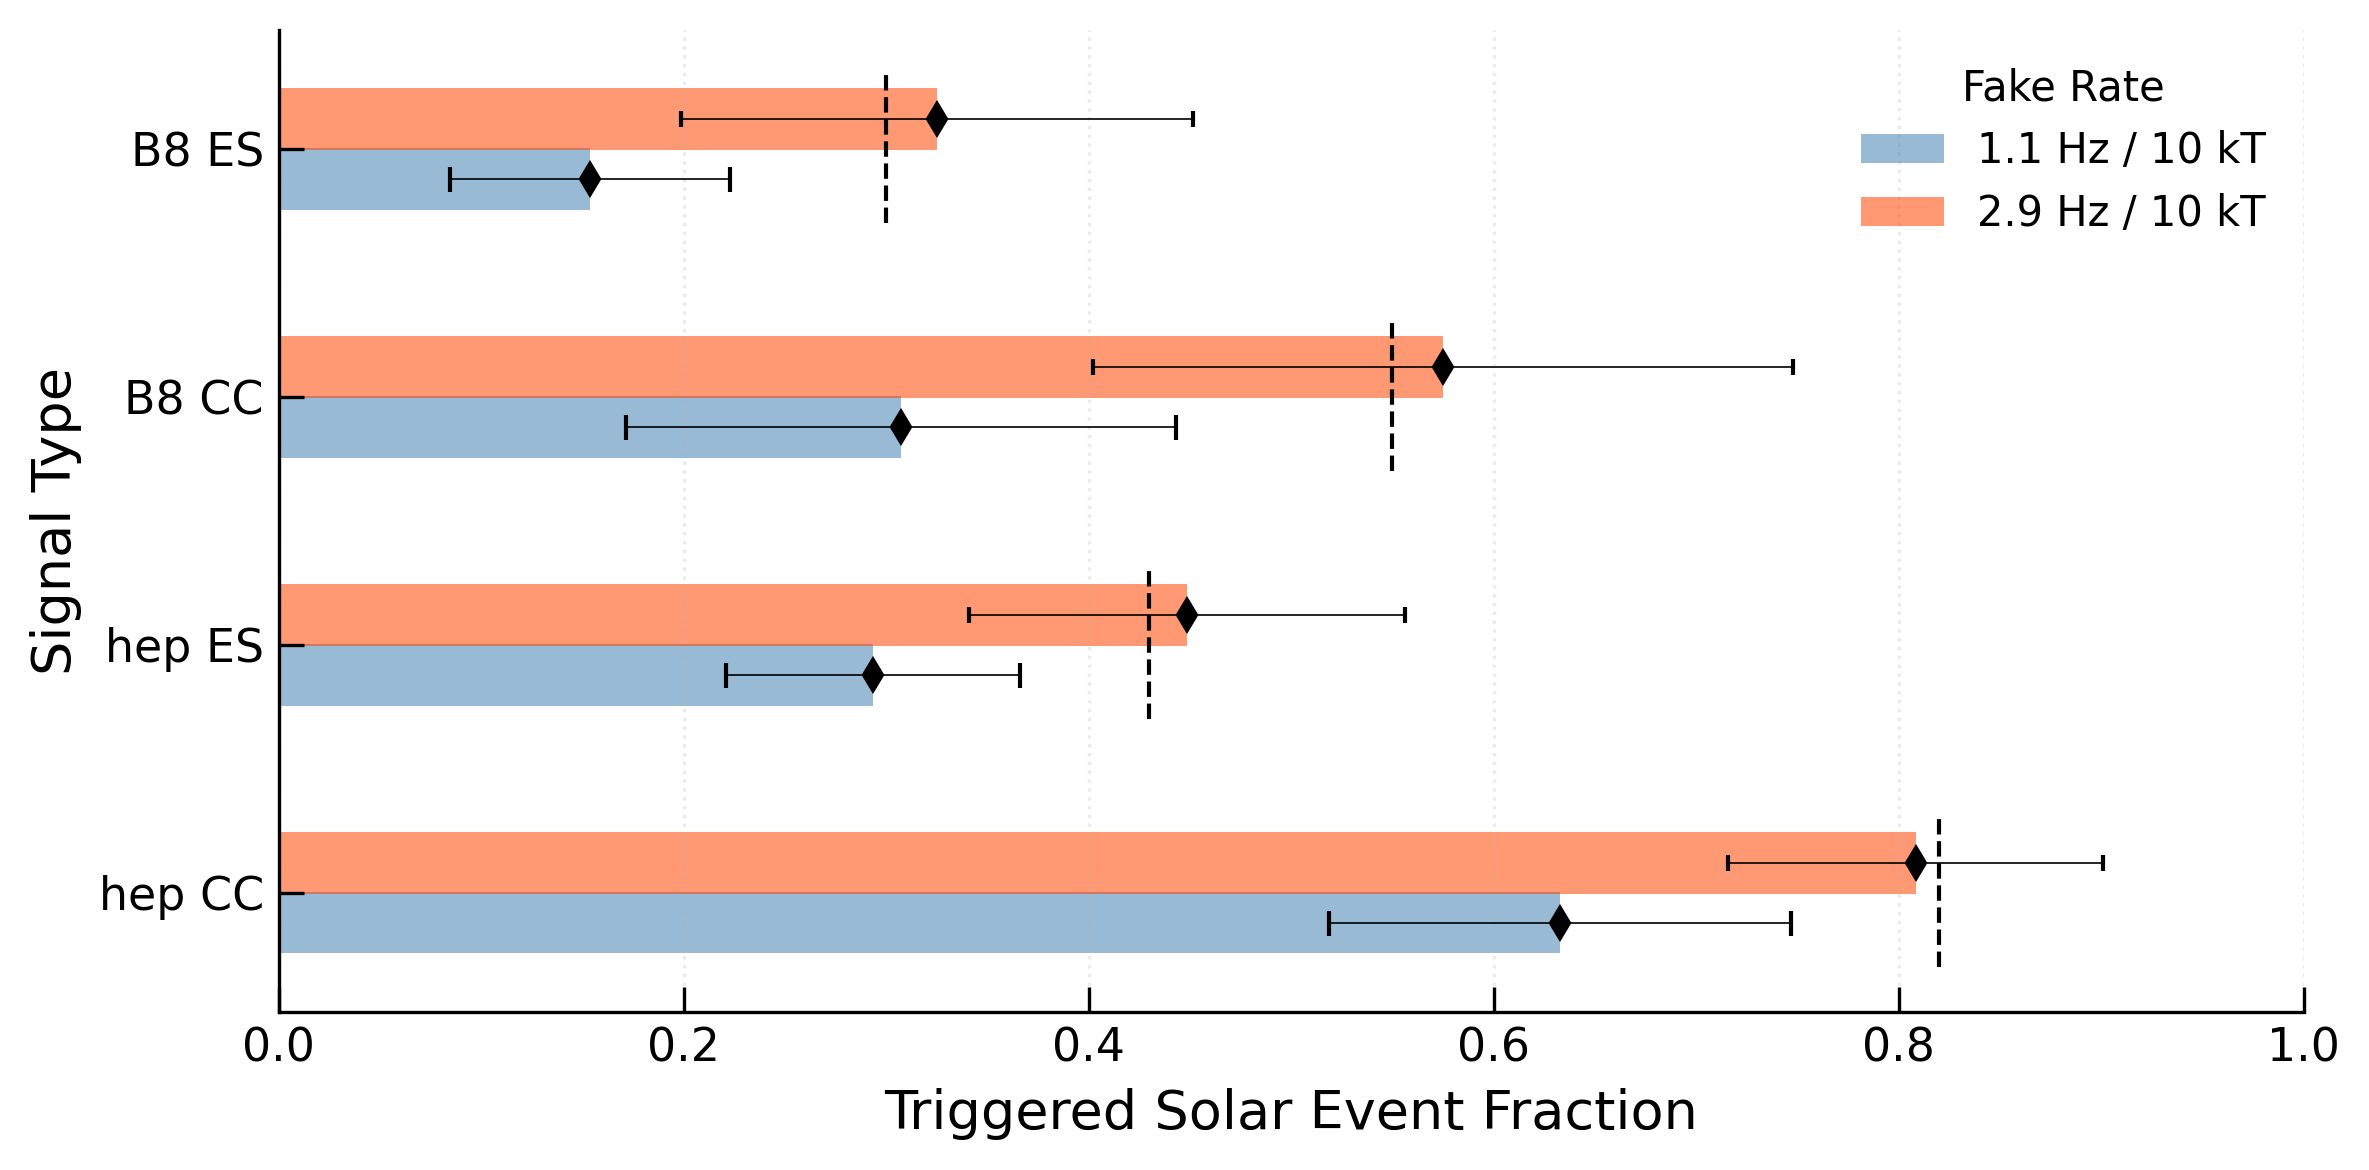

In [32]:

from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from matplotlib.lines import Line2D

# file_groups: nominal and higher fake-rate
file_groups = [
    [
        ("hep", "ES", "solar_data/trig_eff_es_central.txt", "solar_data/trig_eff_es_lateral.txt", "solar_data/solar_suv_hep_es.txt"),
        ("b8",  "ES", "solar_data/trig_eff_es_central.txt", "solar_data/trig_eff_es_lateral.txt", "solar_data/solar_surv_B8_es.txt"),
        ("hep", "CC", "solar_data/trig_eff_cc_central.txt", "solar_data/trig_eff_cc_lateral.txt", "solar_data/solar_surv_hep_cc.txt"),
        ("b8",  "CC", "solar_data/trig_eff_cc_central.txt", "solar_data/trig_eff_cc_lateral.txt", "solar_data/solar_surv_B8_cc.txt")
    ],
    [
        ("hep", "ES", "solar_data/trig_eff_es_central_3Hz.txt", "solar_data/trig_eff_es_lateral_3Hz.txt", "solar_data/solar_suv_hep_es.txt"),
        ("b8",  "ES", "solar_data/trig_eff_es_central_3Hz.txt", "solar_data/trig_eff_es_lateral_3Hz.txt", "solar_data/solar_surv_B8_es.txt"),
        ("hep", "CC", "solar_data/trig_eff_cc_central_3Hz.txt", "solar_data/trig_eff_cc_lateral_3Hz.txt", "solar_data/solar_surv_hep_cc.txt"),
        ("b8",  "CC", "solar_data/trig_eff_cc_central_3Hz.txt", "solar_data/trig_eff_cc_lateral_3Hz.txt", "solar_data/solar_surv_B8_cc.txt")
    ]
]

results, errors = [], []

for group in file_groups:
    group_results, group_errors = {}, {}
    for neutrino, channel, cent_file, lat_file, sol_file in group:
        key = f"{neutrino}_{channel}".lower()  # ensure consistent key
        cent = calculate_triggered_fraction(cent_file, sol_file)
        lat  = calculate_triggered_fraction(lat_file, sol_file)
        mean = get_fulfd_proj(cent, lat)
        group_results[key] = mean
        group_errors[key] = np.array([mean-lat, cent-mean])
    results.append(group_results)
    errors.append(group_errors)

channels = ["hep CC","hep ES","B8 CC","B8 ES"]
y = np.arange(len(channels))
goal = np.array([0.82, 0.43, 0.55, 0.30])


fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

c_low = 'steelblue'
c_high = 'orangered'

channels = ["hep CC","hep ES","B8 CC","B8 ES"]
y = np.arange(len(channels))

low_vals = [results[0][c.lower().replace(" ", "_")] for c in channels]
high_vals = [results[1][c.lower().replace(" ", "_")] for c in channels]
low_errs = np.array([errors[0][c.lower().replace(" ", "_")] for c in channels]).T
high_errs = np.array([errors[1][c.lower().replace(" ", "_")] for c in channels]).T

y_low = y-.12 #- 0.15
y_high = y+.12# + 0.15

bars_low = ax.barh(y_low, low_vals, height=0.25, color=c_low, alpha=0.55, label=f"{(central_fake_rate + lateral_fake_rate):.1f} Hz / 10 kT")
ax.errorbar(low_vals, y_low, xerr=low_errs, fmt='d', capsize=3, markersize=5, color='k', linewidth=0.4)

bars_high = ax.barh(y_high, high_vals, height=0.25, color=c_high, alpha=0.55, label=f"{(central_fake_rate_relaxed + lateral_fake_rate_relaxed):.1f} Hz / 10 kT")
ax.errorbar(high_vals, y_high, xerr=high_errs, fmt='d', capsize=2, markersize=5, color='k', linewidth=0.4)


for i, g in enumerate(goal):
    ax.plot([g, g], [i-0.3, i+0.3], 'k--', lw=1, zorder=6)

plt.legend(title='Fake Rate', frameon = False)

ax.set_yticks(y)
ax.set_yticklabels(channels)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)

ax.set_xlabel("Triggered Solar Event Fraction", fontsize =13)
ax.set_ylabel("Signal Type", fontsize=13)
ax.set_xlim(0, 1)

ax.grid(axis='x', linestyle='dotted', alpha=0.25)
ax.tick_params(axis='both', which='major', direction='in', length=6)
ax.tick_params(axis='x', which='minor', direction='in', length=4)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("./figures/solar_event_acceptance.png")

plt.show()


# Systematic effects in the trigger

In [33]:
leading_lep = es_mc[(es_mc.truth_track_id==-4) & (es_mc.pdg==11)]


test_df = pd.merge(trig_es_cent, leading_lep[['event_uid', 'x', 'y','z', 'px', 'py', 'pz', 'p']], on=['event_uid'],  how = 'right').fillna(-1)
util.calculate_col_angles_inplace(test_df)

test_df

event  tpc  window_start  flag     TA_id  total_window_energy  \
0           1  2.0        4000.0   2.0       0.0              58912.0   
1           2 -1.0          -1.0  -1.0      -1.0                 -1.0   
2           3 -1.0          -1.0  -1.0      -1.0                 -1.0   
3           4  3.0        3000.0   2.0       3.0              23450.0   
4           5 -1.0          -1.0  -1.0      -1.0                 -1.0   
...       ...  ...           ...   ...       ...                  ...   
294256  34996 -1.0          -1.0  -1.0      -1.0                 -1.0   
294257  34997  6.0        2000.0   2.0  332770.0             111497.0   
294258  34998 -1.0          -1.0  -1.0      -1.0                 -1.0   
294259  34999  2.0           0.0   2.0  332772.0              70324.0   
294260  35000  4.0        1000.0   2.0  332773.0             115841.0   

        TP_count  n_clusters  mean_cluster_energy total_cluster_energy  ...  \
0            3.0        -1.0                 -1.0                   -1  ...   
1           -1.0        -1.0                 -1.0                   -1  ...   
2           -1.0        -1.0                 -1.0                   -1  ...   
3            2.0         1.0              23450.0                23450  ...   
4           -1.0        -1.0                 -1.0                   -1  ...   
...          ...         ...                  ...                  ...  ...   
294256      -1.0        -1.0                 -1.0                   -1  ...   
294257       8.0        -1.0                 -1.0                   -1  ...   
294258      -1.0        -1.0                 -1.0                   -1  ...   
294259       4.0        -1.0                 -1.0                   -1  ...   
294260       9.0        -1.0                 -1.0                   -1  ...   

       bgd_energy           x           y           z        px        py  \
0            6518 -361.889448  585.014732  105.495967  0.012092  0.017116   
1            5311 -277.439372  -39.946833  287.909233  0.000379  0.000196   
2            3085  171.848782 -167.754592  256.499639 -0.003320 -0.001777   
3           13416  265.231180  261.653760   23.043279 -0.000720 -0.007898   
4            2120 -331.372581  -60.776088   -0.661553 -0.006878  0.007616   
...           ...         ...         ...         ...       ...       ...   
294256       3251  -34.857948  413.312721  278.793169  0.000063  0.001465   
294257       2197 -243.511262  420.954638  345.106837  0.016383 -0.023149   
294258       2549 -112.608020  199.046626   46.605151  0.000432 -0.000491   
294259       5735  -62.357145  535.968700  114.949452 -0.012088 -0.010383   
294260       1615 -123.196891 -155.731312  363.485102  0.012812 -0.025743   

              pz         p     theta_y    theta_xz  
0       0.005140  0.021577   37.512145   66.972651  
1       0.000575  0.000716   74.155677   33.416220  
2       0.001513  0.004058  115.967334  -65.505189  
3      -0.002218  0.008235  163.553186 -162.006403  
4      -0.019845  0.022341   70.068305 -160.882935  
...          ...       ...         ...         ...  
294256 -0.001039  0.001797   35.403317  176.527362  
294257  0.007070  0.029228  142.374272   66.656801  
294258  0.000339  0.000736  131.820182   51.846272  
294259  0.004101  0.016455  129.125099  -71.262179  
294260  0.006906  0.029573  150.517247   61.675542  

[294261 rows x 24 columns]

In [67]:
# impose active volume requirement 
test_df = test_df[(test_df.x.abs() < 360) &  (test_df.y.abs() < 600) & (test_df.z > 0) & (test_df.z < 460)] #1x2x2

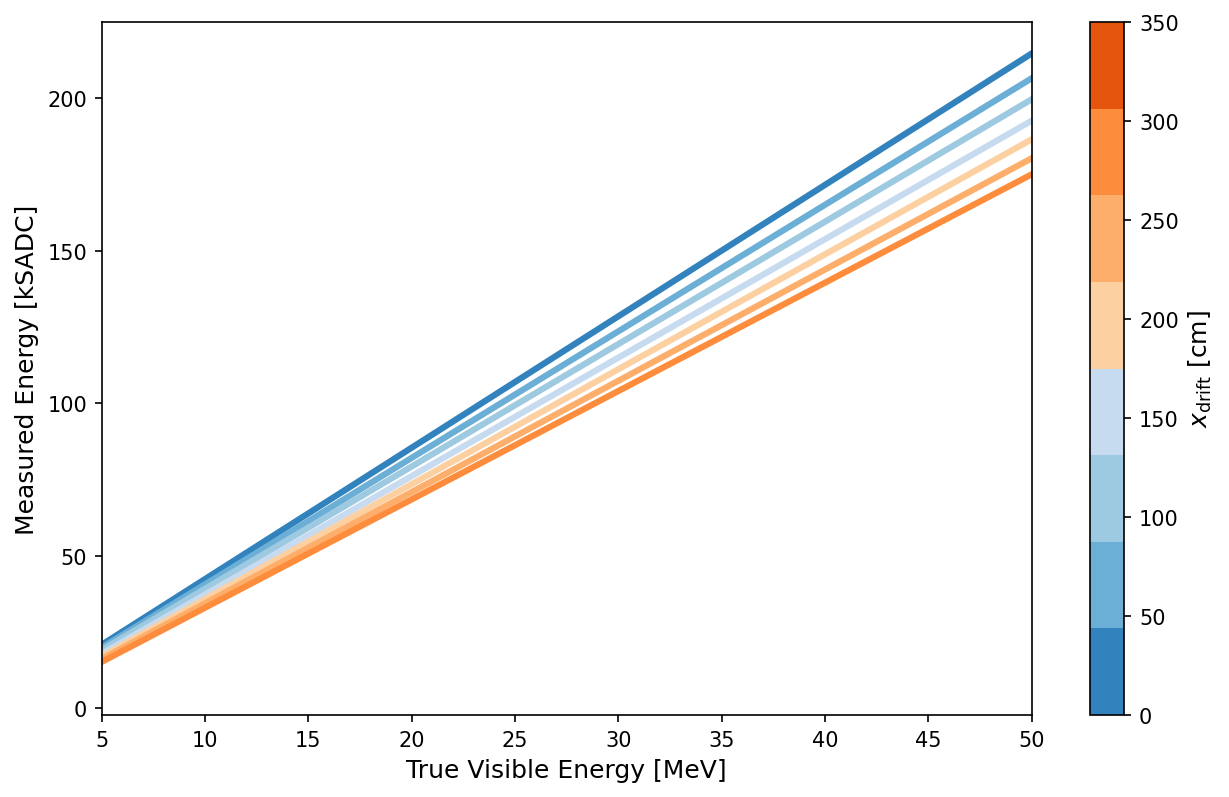

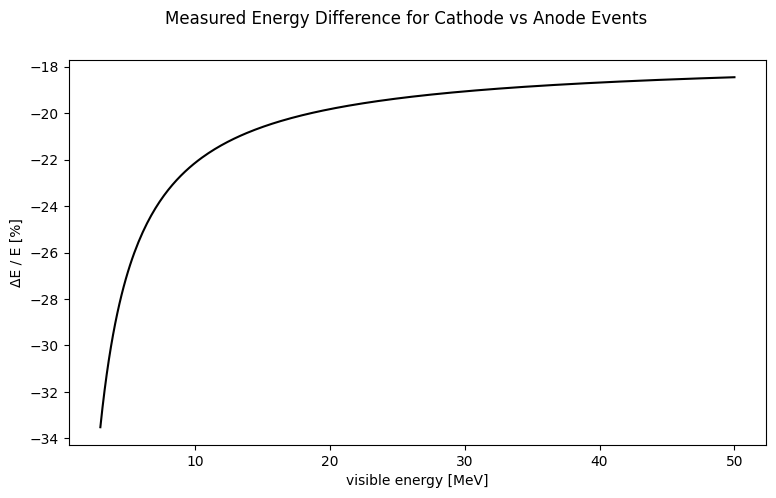

In [68]:

fig,ax=plt.subplots(figsize=(10,6), dpi=150)

g=test_df[(test_df.visible_energy > 3) & (test_df.visible_energy < 50)].groupby("event_uid")

x_vis=g.visible_energy.first().to_numpy()
y_tot=(g.total_window_energy.sum()/1e3).to_numpy()
x_drift=g.x.first().abs().to_numpy()

bins=np.arange(0, x_drift.max(), 50)
bin_idx=np.digitize(x_drift, bins)
#cmap=plt.get_cmap("turbo", len(bins)-1)
cmap=plt.matplotlib.colors.ListedColormap( plt.get_cmap("tab20c").colors[:4] + plt.get_cmap("tab20c").colors[4:8][::-1])
fs =12
fits={}

for i in range(1, len(bins)):
    m=bin_idx==i
    if m.sum()<2:
        continue
    p=np.polyfit(x_vis[m], y_tot[m], 1)
    fits[i]=p
    xs=np.linspace(x_vis[m].min(), x_vis[m].max(), 200)
    ys=np.polyval(p, xs)
    ax.plot(xs, ys, color=cmap(i-1), linewidth =3)

sm=plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=bins[0], vmax=bins[-1]))
sm.set_array([])
fig.colorbar(sm, ax=ax).set_label(r"$x_{\text{drift}}$ [cm]", fontsize=fs)
ax.set_ylabel("Measured Energy [kSADC]", fontsize=fs)
ax.set_xlabel("True Visible Energy [MeV]", fontsize=fs)
ax.set_xlim(5,50)
ax.tick_params(axis="both", labelsize=fs-2)


plt.show()

fig,ax2=plt.subplots(figsize=(9,5))

fit_bins=np.array(sorted(fits.keys()))
b_first=fit_bins[0]
b_last=fit_bins[-1]
E=np.linspace(max(x_vis.min(),3),min(x_vis.max(),70),300)
y_first=np.polyval(fits[b_first],E)
y_last=np.polyval(fits[b_last],E)
pct_diff=100*(y_last-y_first)/y_first
ax2.plot(E,pct_diff,color="black")
ax.set_ylabel("total window energy [kSADC]")
ax2.set_ylabel("ΔE / E [%]")
ax2.set_xlabel("visible energy [MeV]")
sm=plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=bins[0],vmax=bins[-1]))
sm.set_array([])
fig.colorbar(sm,ax=ax,label=r"$x_{\text{drift}}$ [cm]")
plt.suptitle("Measured Energy Difference for Cathode vs Anode Events")
plt.show()



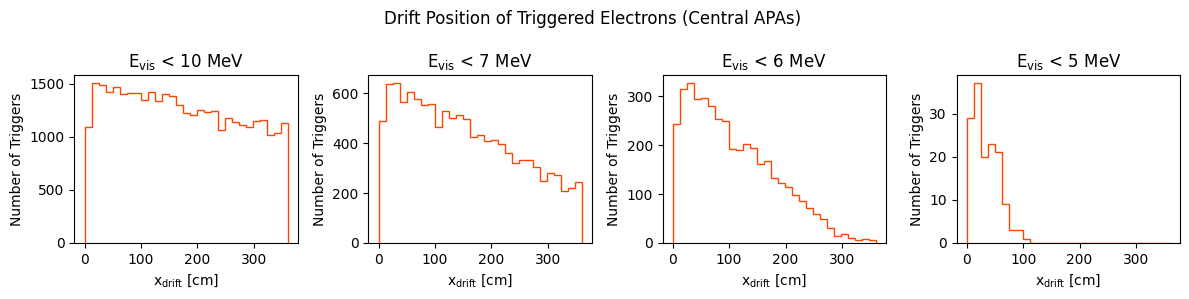

In [69]:
bins = np.linspace(0,360,30)
energies = [ 10, 7,6, 5] 
fig,ax = plt.subplots(1,len(energies),figsize=(12,3))
for i, eng in enumerate(energies):
    ax[i].hist(test_df[(test_df.flag==2) & (test_df.visible_energy < eng)].groupby("event_uid").x.first().abs(), bins =bins , histtype='step',color=cc)
    ax[i].set_title(r"E$_{\text{vis}}$ < " + f"{eng} MeV")
    ax[i].set_xlabel(r"x$_{\text{drift}}$ [cm]")
    ax[i].set_ylabel("Number of Triggers")

plt.suptitle("Drift Position of Triggered Electrons (Central APAs) ")
plt.tight_layout()
plt.show()

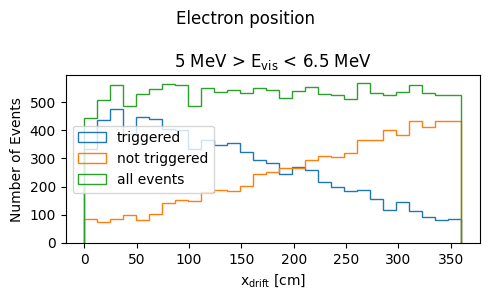

In [70]:
bins = np.linspace(0,360,30)
fig,ax = plt.subplots(figsize=(5,3))
e0 = 5; e1 = 6.5
ax.hist(test_df[(test_df.flag==2) & (test_df.visible_energy < e1) & (test_df.visible_energy > e0)].groupby("event_uid").x.first().abs(), bins =bins , histtype='step',label='triggered')
ax.hist(test_df[(test_df.flag==0) & (test_df.visible_energy < e1) & (test_df.visible_energy > e0)].groupby("event_uid").x.first().abs(), bins =bins , histtype='step', label = 'not triggered')
ax.hist(test_df[(test_df.visible_energy < e1) & (test_df.visible_energy > e0)].groupby("event_uid").x.first().abs(), bins =bins , histtype='step', label = 'all events')

ax.set_title(  f"{e0} MeV" +r" > E$_{\text{vis}}$ < " + f"{e1} MeV")
ax.set_xlabel(r"x$_{\text{drift}}$ [cm]")
ax.set_ylabel("Number of Events")
plt.legend()
plt.suptitle("Electron position")
plt.tight_layout()
plt.show()

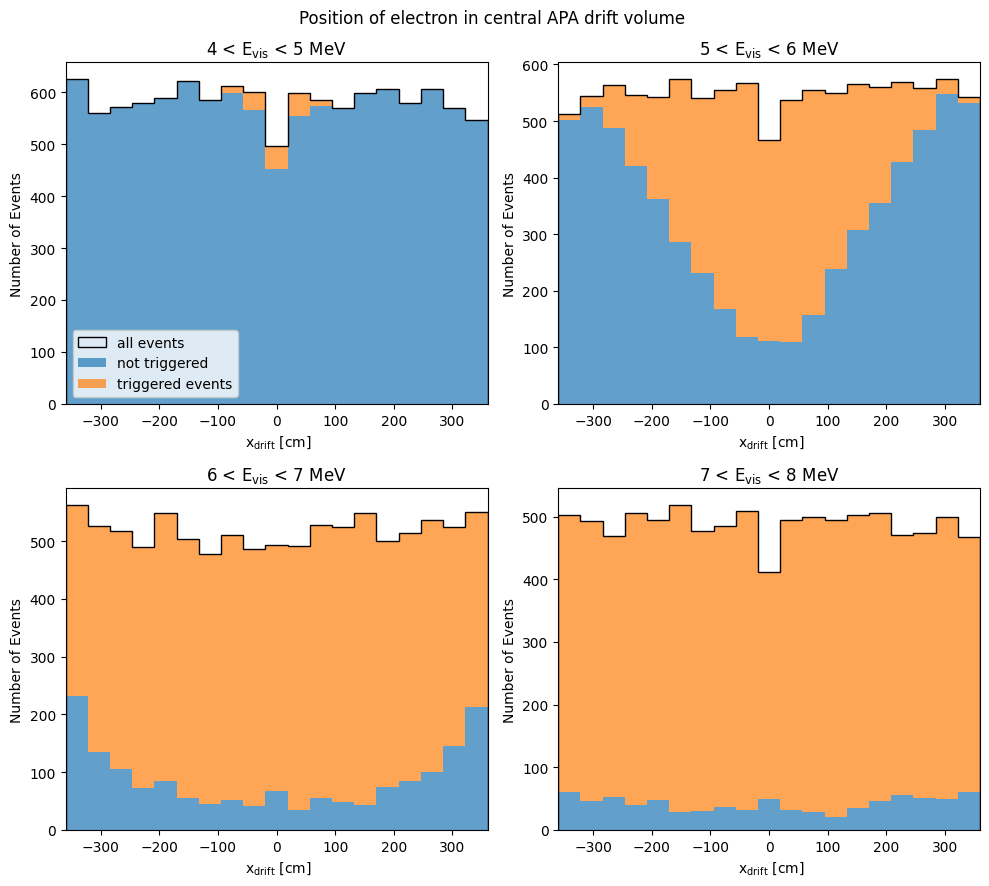

In [71]:
bins=np.linspace(-360,360,20); fig,axs=plt.subplots(2,2,figsize=(10,9)); 
axs=axs.ravel()
#for ax,(e0,e1) in zip(axs,[(i,i+1) for i in range(4,8)]):
for ax,(e0,e1) in zip(axs,[(i,i+1) for i in np.arange(4,8,1)]):
    m=test_df.visible_energy.between(e0,e1)
    all_=test_df[m].groupby("event_uid").x.first()
    tr=test_df[m&(test_df.flag==2)].groupby("event_uid").x.first()
    nt=test_df[m&(test_df.flag!=2)].groupby("event_uid").x.first()
    ax.hist(all_,bins=bins,histtype='step',color='k',label='all events')
    ax.hist([nt,tr],bins=bins,stacked=True,alpha=.7,label=['not triggered ','triggered events'])
    ax.set_title(rf"{e0} < E$_{{\text{{vis}}}}$ < {e1} MeV")

for ax in axs: 
    ax.set_xlim(-360,360)
    ax.set_ylabel("Number of Events")
    ax.set_xlabel(r" x$_{\text{drift}}$ [cm]" )
axs[0].legend();
plt.suptitle("Position of electron in central APA drift volume ") 
plt.tight_layout()
plt.show()

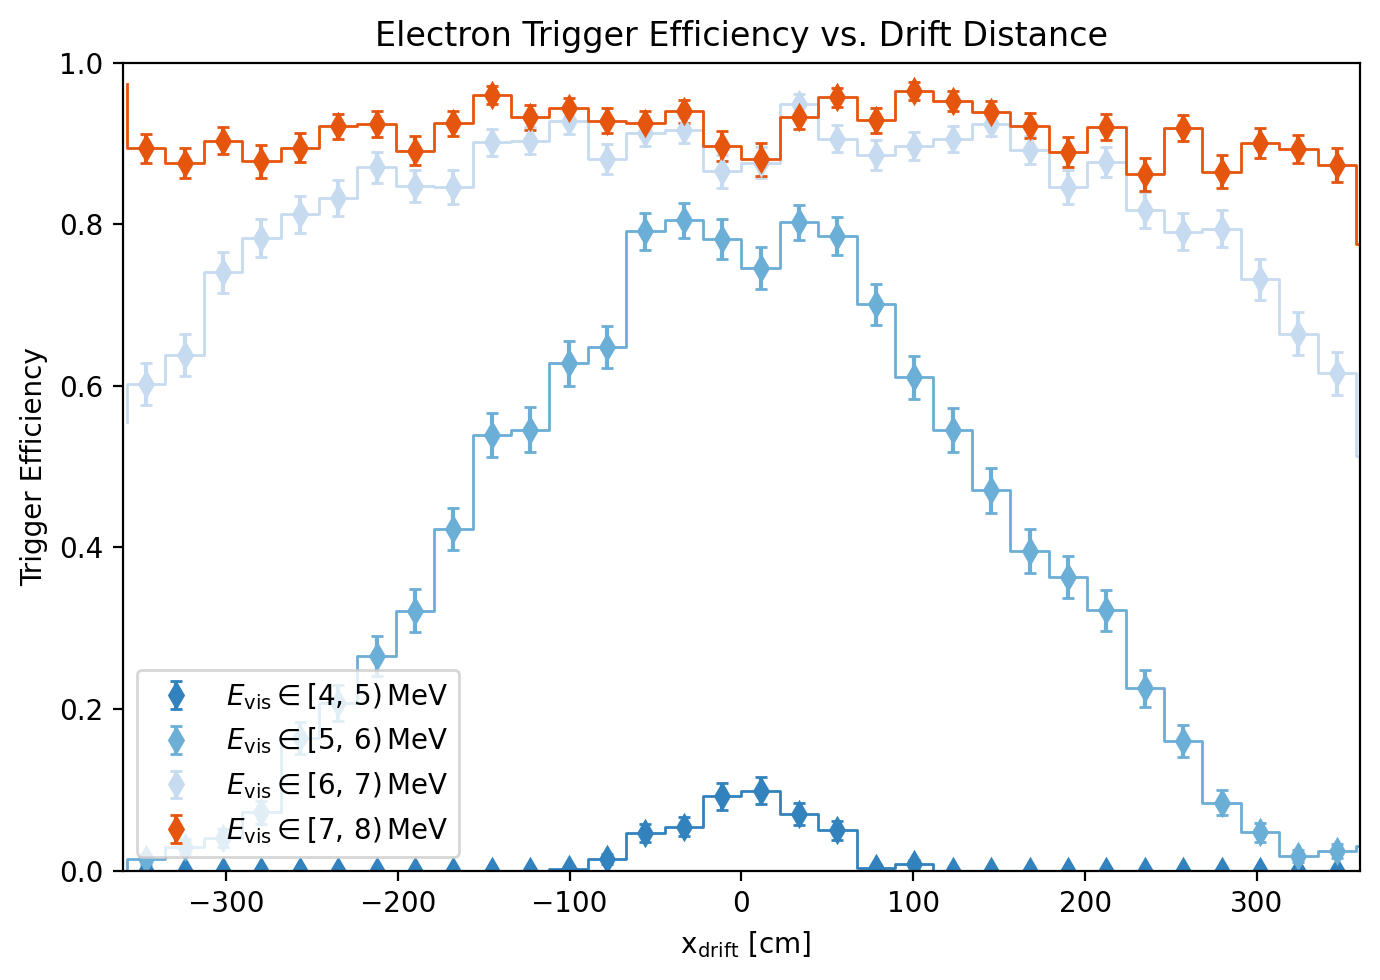

In [72]:
bins = np.linspace(-380, 380,35)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_width = bins[1] - bins[0]

fig, ax = plt.subplots(figsize=(7, 5), dpi =200)
colors = plt.cm.tab20c(np.linspace(0, 1, 14))

for (e0, e1), c in zip([(i, i+1) for i in np.arange(4, 8, 1)], colors):

    m = test_df.visible_energy.between(e0, e1)
    tr = test_df[m & (test_df.flag == 2)].groupby("event_uid").x.first()
    nt = test_df[m & (test_df.flag != 2)].groupby("event_uid").x.first()

    tr_counts, _ = np.histogram(tr, bins=bins)
    nt_counts, _ = np.histogram(nt, bins=bins)

    n = tr_counts + nt_counts
    ratio = np.divide(tr_counts, n, out=np.zeros_like(tr_counts, dtype=float), where=n > 0)
    err = np.sqrt(np.divide(ratio * (1 - ratio), n, out=np.zeros_like(ratio), where=n > 0))

    ax.step(bin_centers+bin_width/2, ratio,color=c, linewidth=1)

    ax.errorbar( bin_centers, ratio, yerr=err,fmt='d', color=c, capsize=2, label=rf"$E_{{\mathrm{{vis}}}} \in [{e0},\,{e1})\,\mathrm{{MeV}}$")

ax.set_xlim(-360, 360)
ax.set_ylim(0, 1)
ax.set_xlabel(r" x$_{\text{drift}}$ [cm]")
ax.set_ylabel(r"Trigger Efficiency")
ax.legend(loc='lower left')
plt.title(r"Electron Trigger Efficiency vs. Drift Distance")
plt.tight_layout()
plt.show()


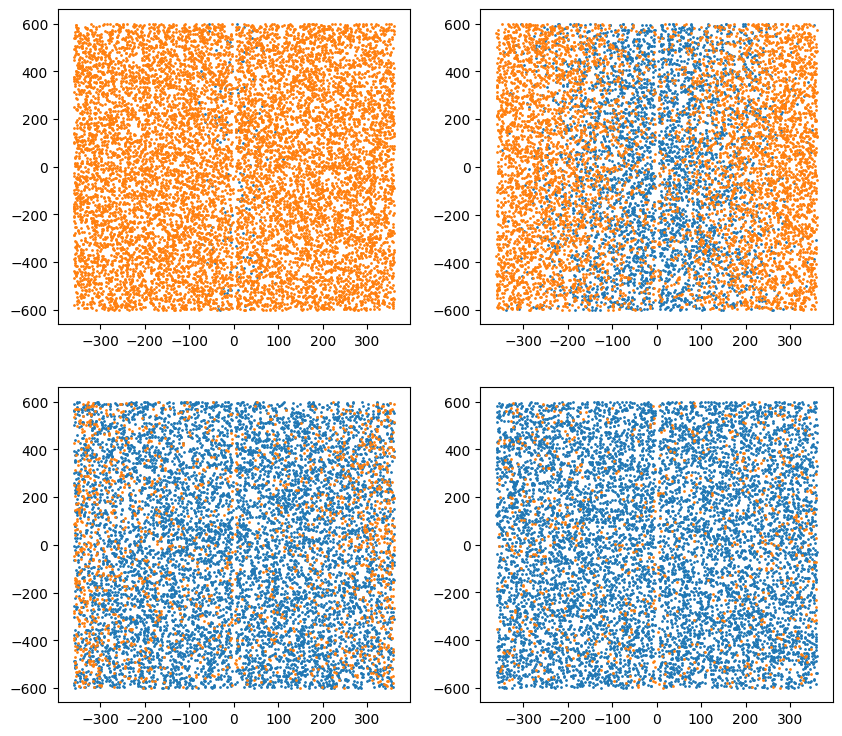

In [40]:
bins=np.linspace(-360,360,20); fig,axs=plt.subplots(2,2,figsize=(10,9)); 
axs=axs.ravel()
#for ax,(e0,e1) in zip(axs,[(i,i+1) for i in range(4,8)]):
for ax,(e0,e1) in zip(axs,[(i,i+1) for i in np.arange(4,8,1)]):
    m=test_df.visible_energy.between(e0,e1)
    all_=test_df[m].groupby("event_uid").x.first()
    tr=test_df[m&(test_df.flag==2)].groupby("event_uid")#.x.first()
    nt=test_df[m&(test_df.flag!=2)].groupby("event_uid")#.x.first()
    ax.scatter(tr.x.first(), tr.y.first(), s =1)
    ax.scatter(nt.x.first(), nt.y.first(), s =1)


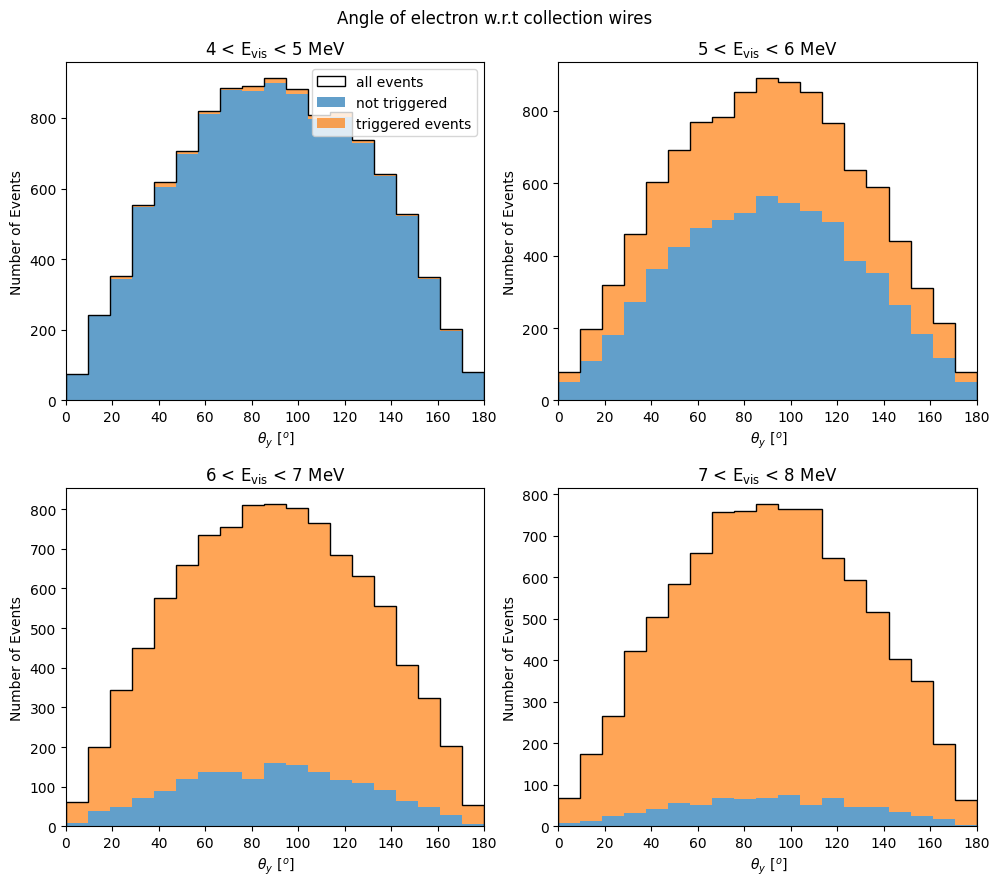

In [73]:
bins=np.linspace(0,180,20); fig,axs=plt.subplots(2,2,figsize=(10,9)); 
axs=axs.ravel()
#for ax,(e0,e1) in zip(axs,[(i,i+1) for i in range(4,8)]):
for ax,(e0,e1) in zip(axs,[(i,i+1) for i in np.arange(4,8,1)]):
    m=test_df.visible_energy.between(e0,e1)
    all_=test_df[m].groupby("event_uid").theta_y.first()
    tr=test_df[m&(test_df.flag==2)].groupby("event_uid").theta_y.first()
    nt=test_df[m&(test_df.flag!=2)].groupby("event_uid").theta_y.first()
    ax.hist(all_,bins=bins,histtype='step',color='k',label='all events')
    ax.hist([nt,tr],bins=bins,stacked=True,alpha=.7,label=['not triggered ','triggered events'])
    ax.set_title(rf"{e0} < E$_{{\text{{vis}}}}$ < {e1} MeV")

for ax in axs: 
    ax.set_xlim(0,180)
    ax.set_ylabel("Number of Events")
    ax.set_xlabel(r" $\theta_y\ [^{o}]$ " )
axs[0].legend();
plt.suptitle("Angle of electron w.r.t collection wires") 
plt.tight_layout()
plt.show()

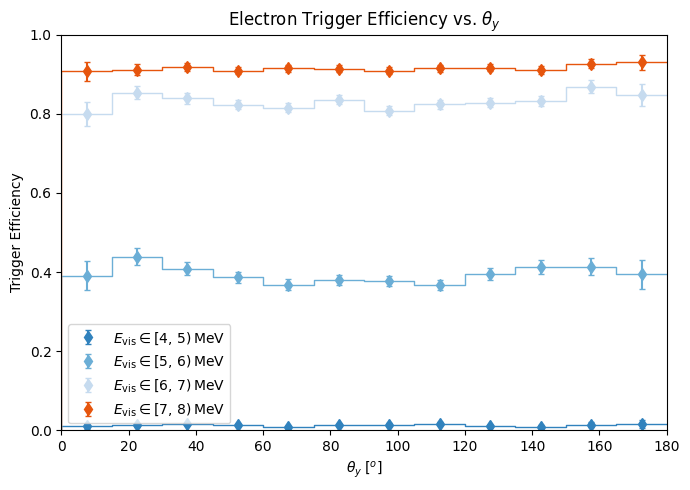

In [74]:
bins = np.linspace(-180, 180,25)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_width = bins[1] - bins[0]

fig, ax = plt.subplots(figsize=(7, 5))
colors = plt.cm.tab20c(np.linspace(0, 1, 14))

for (e0, e1), c in zip([(i, i+1) for i in np.arange(4, 8, 1)], colors):

    m = test_df.visible_energy.between(e0, e1)
    tr = test_df[m & (test_df.flag == 2)].groupby("event_uid").theta_y.first().abs()
    nt = test_df[m & (test_df.flag != 2)].groupby("event_uid").theta_y.first().abs()

    tr_counts, _ = np.histogram(tr, bins=bins)
    nt_counts, _ = np.histogram(nt, bins=bins)

    n = tr_counts + nt_counts
    ratio = np.divide(tr_counts, n, out=np.zeros_like(tr_counts, dtype=float), where=n > 0)
    err = np.sqrt(np.divide(ratio * (1 - ratio), n, out=np.zeros_like(ratio), where=n > 0))

    ax.step(bin_centers+bin_width/2, ratio,color=c, linewidth=1)

    ax.errorbar( bin_centers, ratio, yerr=err,fmt='d', color=c, capsize=2, label=rf"$E_{{\mathrm{{vis}}}} \in [{e0},\,{e1})\,\mathrm{{MeV}}$")

ax.set_xlim(0, 180)
ax.set_ylim(0, 1)
ax.set_xlabel(r"$\theta_{y}\;[^{o}]$")
ax.set_ylabel(r"Trigger Efficiency")
ax.legend(loc='lower left')
plt.title(r"Electron Trigger Efficiency vs. $\theta_{y}$")
plt.tight_layout()
plt.show()



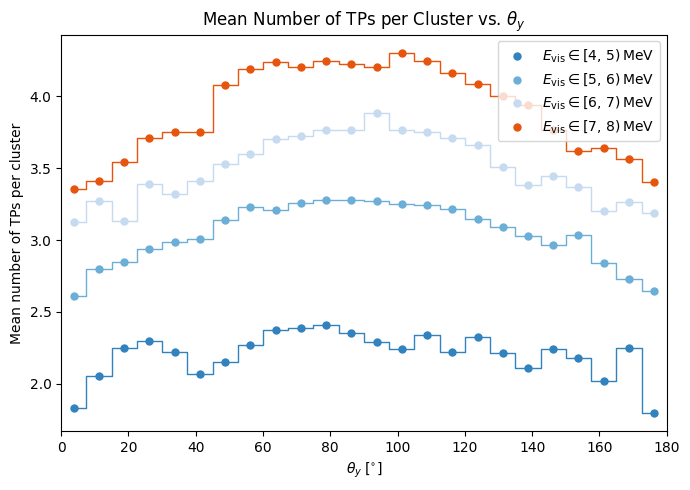

In [75]:
bins = np.linspace(0, 180, 25)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_width = bins[1] - bins[0]

fig, ax = plt.subplots(figsize=(7, 5), dpi=100)
colors = plt.cm.tab20c(np.linspace(0, 1, 14))

for (e0, e1), c in zip([(i, i + 1) for i in np.arange(4, 8)], colors):
    m = test_df.visible_energy.between(e0, e1)
    df_evt = test_df[m].groupby("event_uid", as_index=False).agg(theta=("theta_y", "first"), nTP=("TP_count", "sum"))
    tp_sum, _ = np.histogram(df_evt["theta"].abs(), bins=bins, weights=df_evt["nTP"])
    n_evt, _ = np.histogram(df_evt["theta"].abs(), bins=bins)
    mean_tp = np.divide(tp_sum, n_evt, out=np.zeros_like(tp_sum, dtype=float), where=n_evt > 0)
    ax.step(bin_centers , mean_tp, where="mid", color=c, linewidth=1)
    ax.scatter(bin_centers, mean_tp, color=c, s=25, label=rf"$E_{{\mathrm{{vis}}}} \in [{e0},\,{e1})\,\mathrm{{MeV}}$")

ax.set_xlim(0, 180)
ax.set_xlabel(r"$\theta_{y}\;[^{\circ}]$")
ax.set_ylabel("Mean number of TPs per cluster")
ax.legend()
plt.title(r"Mean Number of TPs per Cluster vs. $\theta_{y}$")
plt.tight_layout()
plt.show()


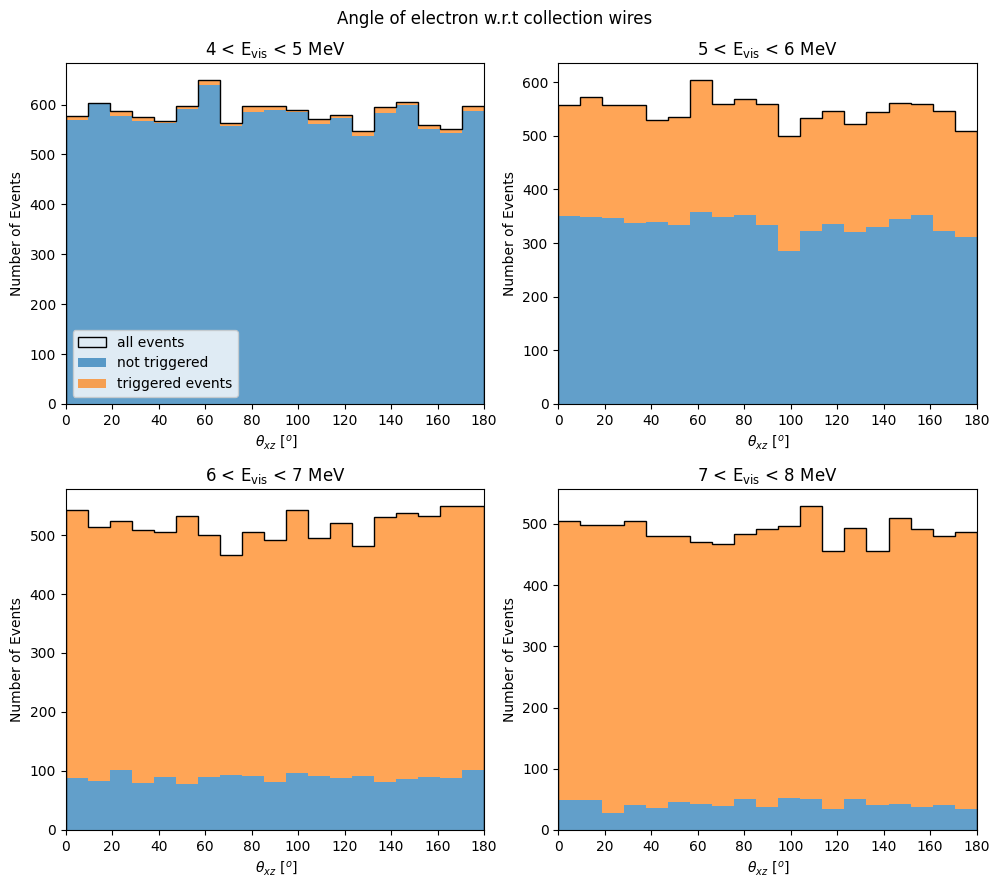

In [76]:
bins=np.linspace(0,180,20); fig,axs=plt.subplots(2,2,figsize=(10,9)); 
axs=axs.ravel()
#for ax,(e0,e1) in zip(axs,[(i,i+1) for i in range(4,8)]):
for ax,(e0,e1) in zip(axs,[(i,i+1) for i in np.arange(4,8,1)]):
    m=test_df.visible_energy.between(e0,e1)
    all_=test_df[m].groupby("event_uid").theta_xz.first().abs()
    tr=test_df[m&(test_df.flag==2)].groupby("event_uid").theta_xz.first().abs()
    nt=test_df[m&(test_df.flag!=2)].groupby("event_uid").theta_xz.first().abs()
    ax.hist(all_,bins=bins,histtype='step',color='k',label='all events')
    ax.hist([nt,tr],bins=bins,stacked=True,alpha=.7,label=['not triggered ','triggered events'])
    ax.set_title(rf"{e0} < E$_{{\text{{vis}}}}$ < {e1} MeV")

for ax in axs: 
    ax.set_xlim(0,180)
    ax.set_ylabel("Number of Events")
    ax.set_xlabel(r" $\theta_{xz}\ [^{o}]$ " )
axs[0].legend();
plt.suptitle("Angle of electron w.r.t collection wires") 
plt.tight_layout()
plt.show()

event  tpc  window_start  flag     TA_id  total_window_energy  \
313       300  6.0        2000.0   0.0     326.0              26823.0   
847       810  5.0        3000.0   0.0     867.0              26399.0   
1863     1751 -1.0          -1.0  -1.0      -1.0                 -1.0   
2237     2108  5.0           0.0   0.0    2300.0              33103.0   
2394     2252  2.0        3000.0   0.0    2465.0              20670.0   
...       ...  ...           ...   ...       ...                  ...   
291836  32720  3.0        2000.0   0.0  330271.0              24425.0   
291894  32777  5.0        1000.0   0.0  330332.0              28181.0   
292405  33258  0.0        2000.0   0.0  330876.0              28801.0   
292438  33291  1.0        1000.0   0.0  330909.0              17743.0   
292989  33808  6.0        2000.0   0.0  331481.0              23399.0   

        TP_count  n_clusters  mean_cluster_energy total_cluster_energy  ...  \
313          4.0         2.0              13411.5                26823  ...   
847          6.0         2.0              13199.5                26399  ...   
1863        -1.0        -1.0                 -1.0                   -1  ...   
2237         2.0         0.0                  0.0                    0  ...   
2394         7.0         2.0               9563.5                19127  ...   
...          ...         ...                  ...                  ...  ...   
291836       5.0         1.0              21460.0                21460  ...   
291894       1.0         0.0                  0.0                    0  ...   
292405       5.0         2.0              13600.5                27201  ...   
292438       2.0         1.0              17743.0                17743  ...   
292989       4.0         2.0              11699.5                23399  ...   

       bgd_energy           x           y           z        px        py  \
313          1071 -189.607273  198.780559  419.897901  0.002108  0.003683   
847          2184  257.638758 -426.613720  397.754634 -0.002001  0.005363   
1863         7347  327.026477  392.997735  335.621255 -0.007144 -0.003436   
2237          927   43.907695   -4.030796  452.571570  0.016483  0.017721   
2394         9488 -271.286390   18.232441  198.232736 -0.004786 -0.002939   
...           ...         ...         ...         ...       ...       ...   
291836       4257  226.322115  181.253758  193.816718  0.001384 -0.001512   
291894       8221  116.628746 -149.373620  253.079868  0.003085  0.006566   
292405      10646 -213.026641 -370.358972   78.992929 -0.007093  0.004383   
292438       2384   84.170235 -315.284405  177.742009  0.001097 -0.005944   
292989       1081 -184.165235   77.570882  429.591464  0.004414 -0.002051   

              pz         p     theta_y    theta_xz  
313    -0.006863  0.008069   62.843100  162.922545  
847     0.005463  0.007913   47.333399  -20.118996  
1863    0.000648  0.007954  115.590127  -84.816460  
2237   -0.004883  0.024689   44.129134  106.501492  
2394   -0.006887  0.008886  109.311785 -145.201259  
...          ...       ...         ...         ...  
291836 -0.007301  0.007583  101.498270  169.266065  
291894 -0.002285  0.007606   30.313974  126.531224  
292405 -0.001403  0.008455   58.778437 -101.187845  
292438 -0.005901  0.008447  134.723313  169.464382  
292989  0.007629  0.009049  103.097950   30.053117  

[803 rows x 24 columns]

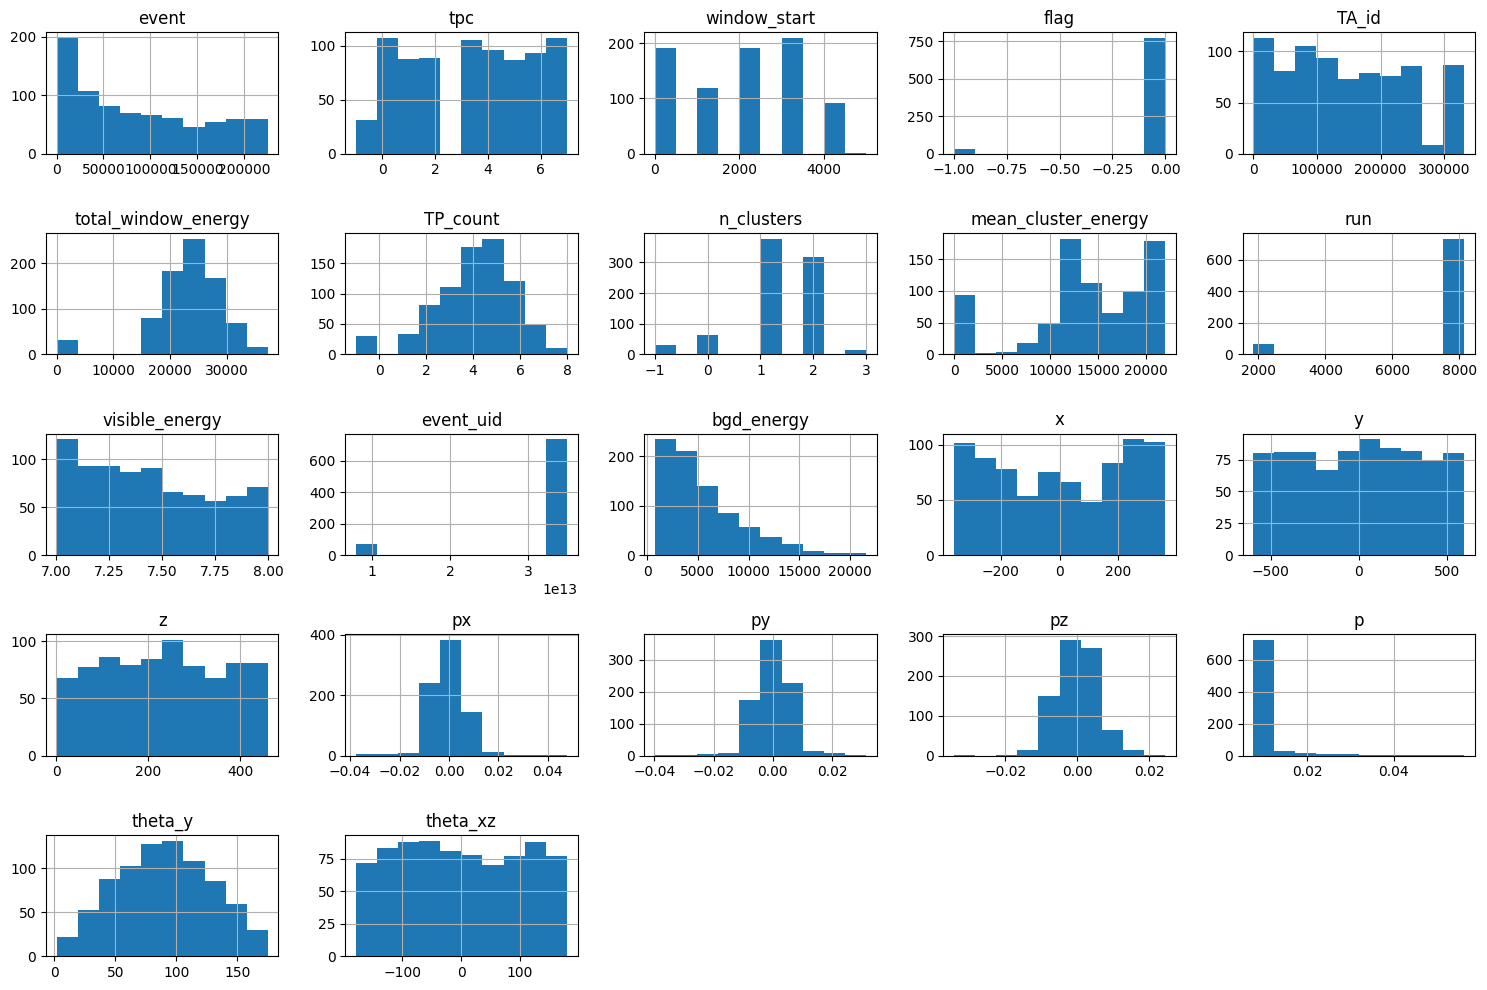

In [79]:
energy_conditon=test_df.visible_energy.between(7,8)
untriggered_events = test_df[energy_conditon].groupby("event_uid").flag.max().lt(2)
untriggered_events 
bad_events = test_df[(energy_conditon) & (test_df.event_uid.isin( untriggered_events.index[untriggered_events]))]

display(bad_events)

bad_events.hist(figsize=(15,10))
plt.tight_layout()
plt.show()

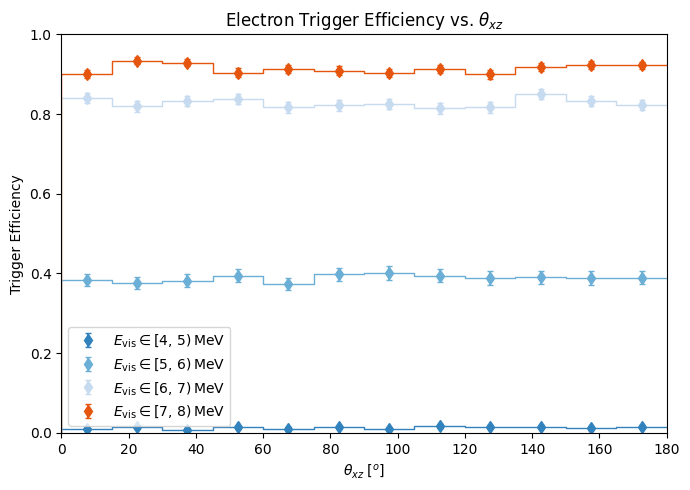

In [46]:
bins = np.linspace(-180, 180,25)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_width = bins[1] - bins[0]

fig, ax = plt.subplots(figsize=(7, 5))
colors = plt.cm.tab20c(np.linspace(0, 1, 14))

for (e0, e1), c in zip([(i, i+1) for i in np.arange(4, 8, 1)], colors):

    m = test_df.visible_energy.between(e0, e1)
    tr = test_df[m & (test_df.flag == 2)].groupby("event_uid").theta_xz.first().abs()
    nt = test_df[m & (test_df.flag != 2)].groupby("event_uid").theta_xz.first().abs()

    tr_counts, _ = np.histogram(tr, bins=bins)
    nt_counts, _ = np.histogram(nt, bins=bins)

    n = tr_counts + nt_counts
    ratio = np.divide(tr_counts, n, out=np.zeros_like(tr_counts, dtype=float), where=n > 0)
    err = np.sqrt(np.divide(ratio * (1 - ratio), n, out=np.zeros_like(ratio), where=n > 0))

    ax.step(bin_centers+bin_width/2, ratio,color=c, linewidth=1)

    ax.errorbar( bin_centers, ratio, yerr=err,fmt='d', color=c, capsize=2, label=rf"$E_{{\mathrm{{vis}}}} \in [{e0},\,{e1})\,\mathrm{{MeV}}$")

ax.set_xlim(0, 180)
ax.set_ylim(0, 1)
ax.set_xlabel(r"$\theta_{xz}\;[^{o}]$")
ax.set_ylabel(r"Trigger Efficiency")
ax.legend(loc='lower left')
plt.title(r"Electron Trigger Efficiency vs. $\theta_{xz}$")
plt.tight_layout()
plt.show()


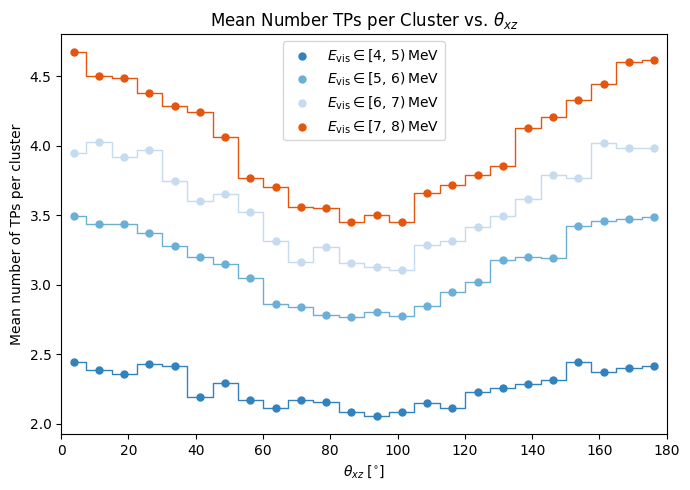

In [47]:
bins = np.linspace(0, 180, 25)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_width = bins[1] - bins[0]

fig, ax = plt.subplots(figsize=(7, 5), dpi =100)
colors = plt.cm.tab20c(np.linspace(0, 1, 14))

for (e0, e1), c in zip([(i, i + 1) for i in np.arange(4, 8)], colors):
    m = test_df.visible_energy.between(e0, e1)
    df_evt = test_df[m].groupby("event_uid", as_index=False).agg(theta=("theta_xz", "first"), nTP=("TP_count", "sum"))
    tp_sum, _ = np.histogram(df_evt["theta"].abs(), bins=bins, weights=df_evt["nTP"])
    n_evt, _ = np.histogram(df_evt["theta"].abs(), bins=bins)
    mean_tp = np.divide(tp_sum, n_evt, out=np.zeros_like(tp_sum, dtype=float), where=n_evt > 0)
    ax.step(bin_centers , mean_tp, where="mid", color=c, linewidth=1)
    ax.scatter(bin_centers, mean_tp, color=c, s=25, label=rf"$E_{{\mathrm{{vis}}}} \in [{e0},\,{e1})\,\mathrm{{MeV}}$")

ax.set_xlim(0, 180)
ax.set_xlabel(r"$\theta_{xz}\;[^{\circ}]$")
ax.set_ylabel("Mean number of TPs per cluster")
ax.legend()
plt.title(r"Mean Number TPs per Cluster vs. $\theta_{xz}$")
plt.tight_layout()
plt.show()


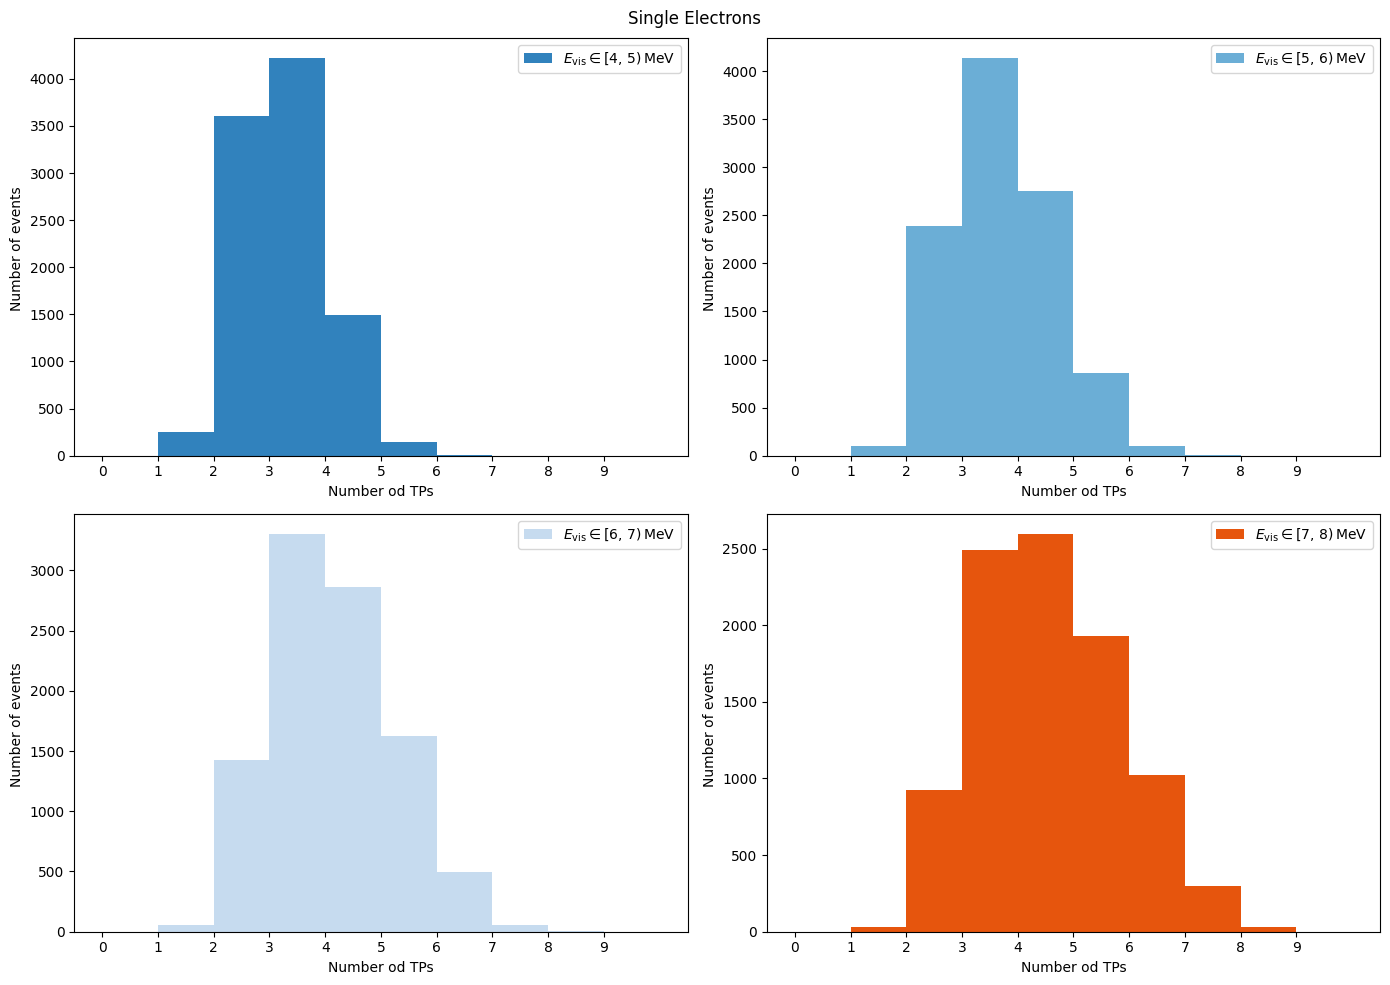

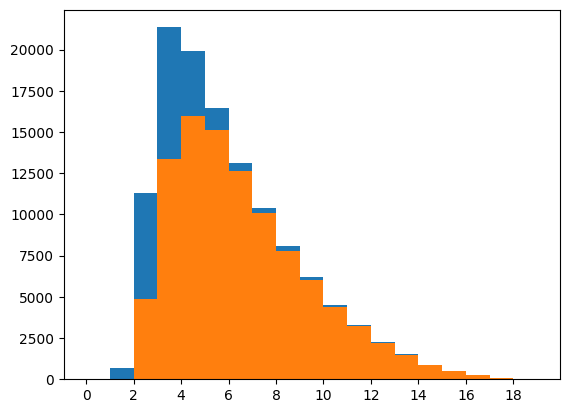

In [48]:
bins = np.linspace(0, 10,11)

# FIXME check number of clustered TPs 

colors = plt.cm.tab20c(np.linspace(0, 1, 14))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for (e0, e1), c, ax in zip([(i, i+1) for i in np.arange(4, 8, 1)], colors, axes):


    m = test_df.visible_energy.between(e0, e1)

    ax.hist(test_df[m].groupby("event_uid").TP_count.sum(), bins=bins ,  label=rf"$E_{{\mathrm{{vis}}}} \in [{e0},\,{e1})\,\mathrm{{MeV}}$", linewidth =2, color=c)


    ax.set_xlabel(r"Number od TPs")
    ax.set_ylabel(r"Number of events ")
    ax.legend()
    ax.set_xticks(np.arange(0,10,1))
plt.suptitle("Single Electrons")
plt.tight_layout()
plt.show()

x= test_df[(test_df.flag!=-1) & (test_df.visible_energy < 20)] 

plt.hist(x.groupby("event_uid").TP_count.sum(), bins = np.arange(0,20,1))
plt.hist(x[x.flag==2].groupby("event_uid").TP_count.sum(), bins = np.arange(0,20,1))

plt.xticks(np.arange(0,20,2))
plt.show()


# Check if there's a directional dependence for heavier particles like single protons 

In [49]:
test_df2 = pd.merge(trig_p_cent, p_mc[['event_uid', 'x', 'y','z', 'px', 'py', 'pz', 'p']], on=['event_uid'],  how = 'right').fillna(-1)
util.calculate_col_angles_inplace(test_df2)


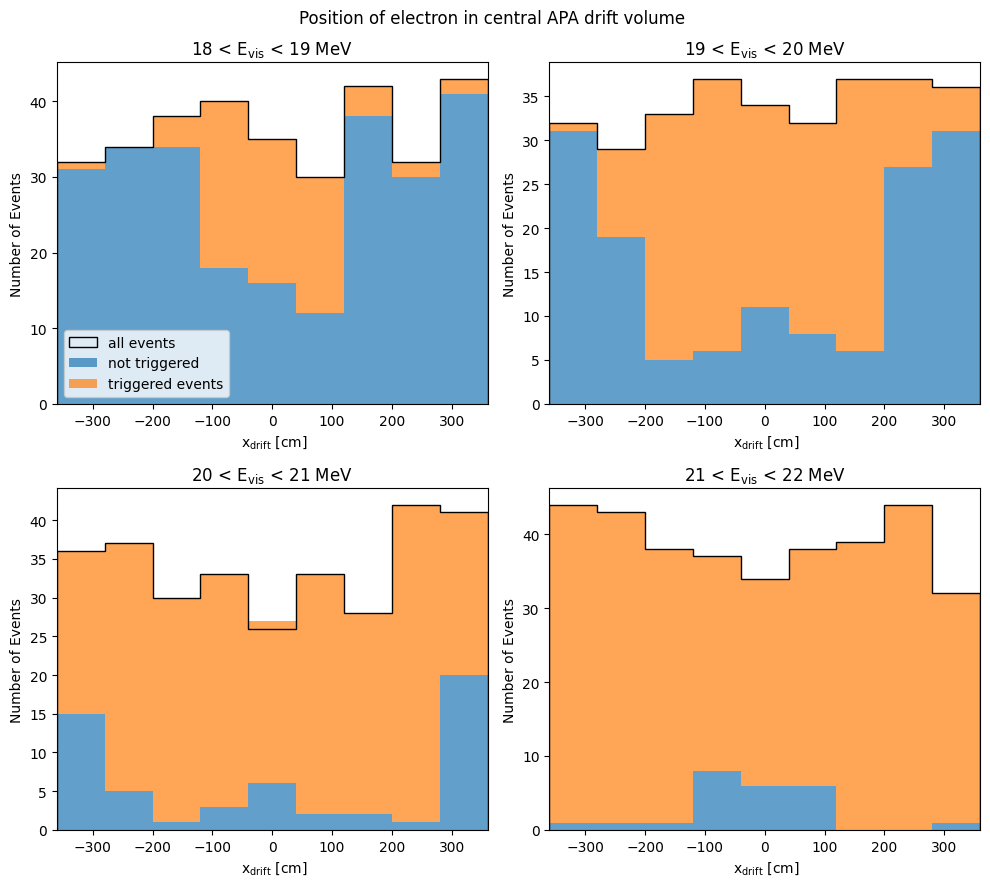

In [50]:
bins=np.linspace(-360,360,10); fig,axs=plt.subplots(2,2,figsize=(10,9)); 
axs=axs.ravel()
for ax,(e0,e1) in zip(axs,[(i,i+1) for i in np.arange(18,22,1)]):
    m=test_df2.visible_energy.between(e0,e1)
    all_=test_df2[m].groupby("event_uid").x.first()
    tr=test_df2[m&(test_df2.flag==2)].groupby("event_uid").x.first()
    nt=test_df2[m&(test_df2.flag!=2)].groupby("event_uid").x.first()
    ax.hist(all_,bins=bins,histtype='step',color='k',label='all events')
    ax.hist([nt,tr],bins=bins,stacked=True,alpha=.7,label=['not triggered ','triggered events'])
    ax.set_title(rf"{e0} < E$_{{\text{{vis}}}}$ < {e1} MeV")

for ax in axs: 
    ax.set_xlim(-360,360)
    ax.set_ylabel("Number of Events")
    ax.set_xlabel(r" x$_{\text{drift}}$ [cm]" )
axs[0].legend();
plt.suptitle("Position of electron in central APA drift volume ") 
plt.tight_layout()
plt.show()

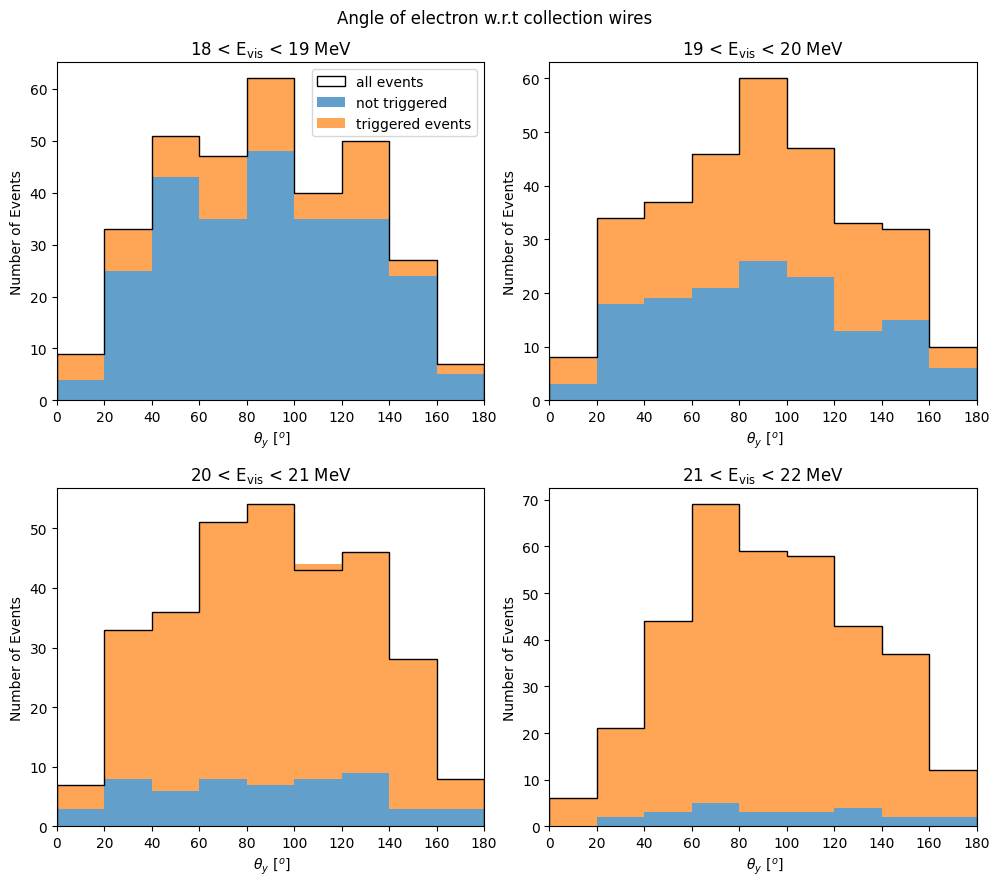

In [51]:
bins=np.linspace(0,180,10); fig,axs=plt.subplots(2,2,figsize=(10,9)); 
axs=axs.ravel()
#for ax,(e0,e1) in zip(axs,[(i,i+1) for i in range(4,8)]):
for ax,(e0,e1) in zip(axs,[(i,i+1) for i in np.arange(18,22,1)]):
    m=test_df2.visible_energy.between(e0,e1)
    all_=test_df2[m].groupby("event_uid").theta_y.first()
    tr=test_df2[m&(test_df2.flag==2)].groupby("event_uid").theta_y.first()
    nt=test_df2[m&(test_df2.flag!=2)].groupby("event_uid").theta_y.first()
    ax.hist(all_,bins=bins,histtype='step',color='k',label='all events')
    ax.hist([nt,tr],bins=bins,stacked=True,alpha=.7,label=['not triggered ','triggered events'])
    ax.set_title(rf"{e0} < E$_{{\text{{vis}}}}$ < {e1} MeV")

for ax in axs: 
    ax.set_xlim(0,180)
    ax.set_ylabel("Number of Events")
    ax.set_xlabel(r" $\theta_y\ [^{o}]$ " )
axs[0].legend();
plt.suptitle("Angle of electron w.r.t collection wires") 
plt.tight_layout()
plt.show()

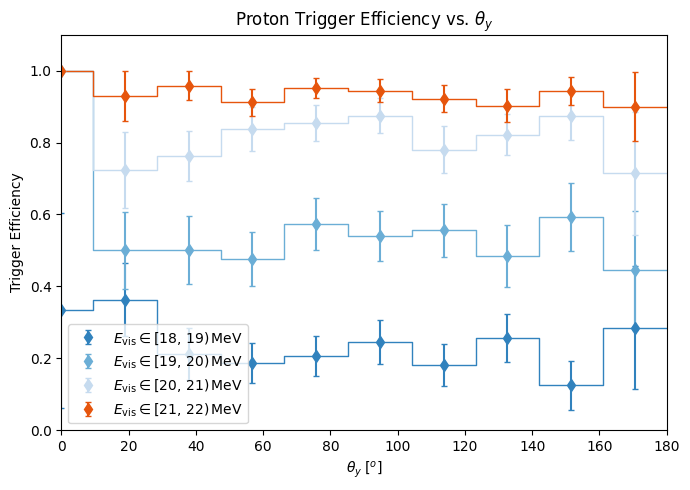

In [52]:
bins = np.linspace(-180, 180,20)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_width = bins[1] - bins[0]

fig, ax = plt.subplots(figsize=(7, 5))
colors = plt.cm.tab20c(np.linspace(0, 1, 14))

for (e0, e1), c in zip([(i, i+1) for i in np.arange(18,22,1)], colors):

    m = test_df2.visible_energy.between(e0, e1)
    tr = test_df2[m & (test_df2.flag == 2)].groupby("event_uid").theta_y.first().abs()
    nt = test_df2[m & (test_df2.flag != 2)].groupby("event_uid").theta_y.first().abs()

    tr_counts, _ = np.histogram(tr, bins=bins)
    nt_counts, _ = np.histogram(nt, bins=bins)

    n = tr_counts + nt_counts
    ratio = np.divide(tr_counts, n, out=np.zeros_like(tr_counts, dtype=float), where=n > 0)
    err = np.sqrt(np.divide(ratio * (1 - ratio), n, out=np.zeros_like(ratio), where=n > 0))

    ax.step(bin_centers+bin_width/2, ratio,color=c, linewidth=1)

    ax.errorbar( bin_centers, ratio, yerr=err,fmt='d', color=c, capsize=2, label=rf"$E_{{\mathrm{{vis}}}} \in [{e0},\,{e1})\,\mathrm{{MeV}}$")

ax.set_xlim(0, 180)
ax.set_ylim(0, 1.1)
ax.set_xlabel(r"$\theta_{y}\;[^{o}]$")
ax.set_ylabel(r"Trigger Efficiency")
ax.legend(loc='lower left')
plt.title(r"Proton Trigger Efficiency vs. $\theta_{y}$")
plt.tight_layout()
plt.show()



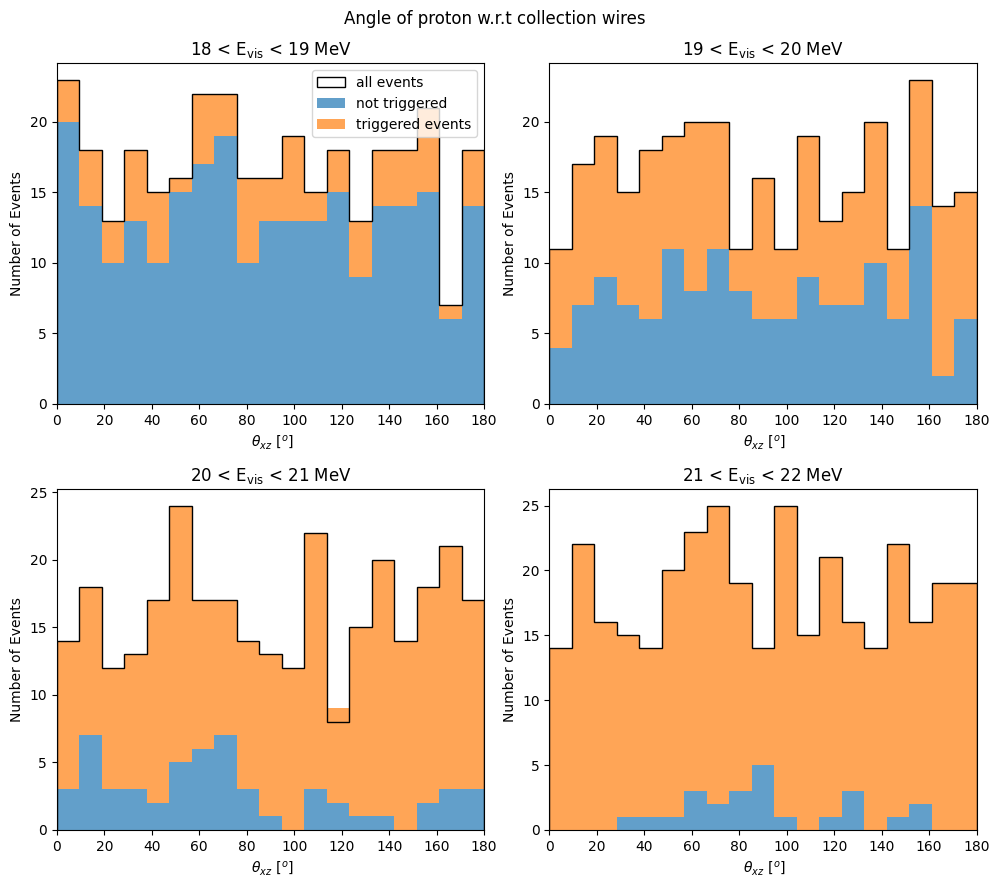

In [53]:
bins=np.linspace(0,180,20); fig,axs=plt.subplots(2,2,figsize=(10,9)); 
axs=axs.ravel()
for ax,(e0,e1) in zip(axs,[(i,i+1) for i in np.arange(18,22,1)]):
    m=test_df2.visible_energy.between(e0,e1)
    all_=test_df2[m].groupby("event_uid").theta_xz.first().abs()
    tr=test_df2[m&(test_df2.flag==2)].groupby("event_uid").theta_xz.first().abs()
    nt=test_df2[m&(test_df2.flag!=2)].groupby("event_uid").theta_xz.first().abs()
    ax.hist(all_,bins=bins,histtype='step',color='k',label='all events')
    ax.hist([nt,tr],bins=bins,stacked=True,alpha=.7,label=['not triggered ','triggered events'])
    ax.set_title(rf"{e0} < E$_{{\text{{vis}}}}$ < {e1} MeV")

for ax in axs: 
    ax.set_xlim(0,180)
    ax.set_ylabel("Number of Events")
    ax.set_xlabel(r" $\theta_{xz}\ [^{o}]$ " )
axs[0].legend();
plt.suptitle("Angle of proton w.r.t collection wires") 
plt.tight_layout()
plt.show()

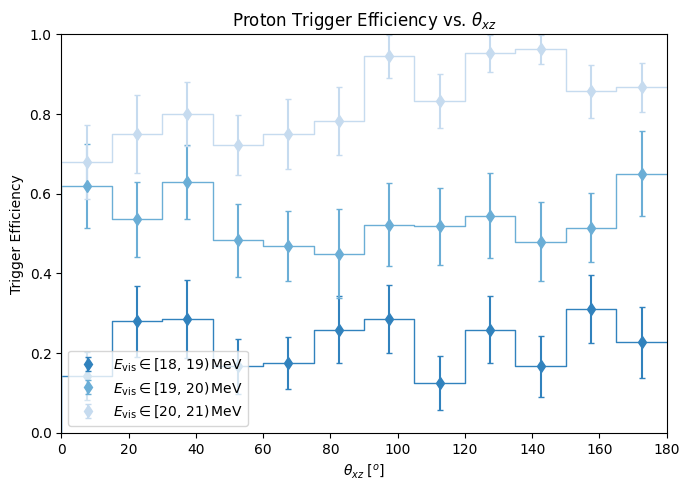

In [60]:
bins = np.linspace(-180, 180,25)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_width = bins[1] - bins[0]

fig, ax = plt.subplots(figsize=(7, 5))
colors = plt.cm.tab20c(np.linspace(0, 1, 14))

for (e0, e1), c in zip([(i, i+1) for i in np.arange(18, 21, 1)], colors):

    m = test_df2.visible_energy.between(e0, e1)
    tr = test_df2[m & (test_df2.flag == 2)].groupby("event_uid").theta_xz.first().abs()
    nt = test_df2[m & (test_df2.flag != 2)].groupby("event_uid").theta_xz.first().abs()

    tr_counts, _ = np.histogram(tr, bins=bins)
    nt_counts, _ = np.histogram(nt, bins=bins)

    n = tr_counts + nt_counts
    ratio = np.divide(tr_counts, n, out=np.zeros_like(tr_counts, dtype=float), where=n > 0)
    err = np.sqrt(np.divide(ratio * (1 - ratio), n, out=np.zeros_like(ratio), where=n > 0))

    ax.step(bin_centers+bin_width/2, ratio,color=c, linewidth=1)

    ax.errorbar( bin_centers, ratio, yerr=err,fmt='d', color=c, capsize=2, label=rf"$E_{{\mathrm{{vis}}}} \in [{e0},\,{e1})\,\mathrm{{MeV}}$")

ax.set_xlim(0, 180)
ax.set_ylim(0, 1)
ax.set_xlabel(r"$\theta_{xz}\;[^{o}]$")
ax.set_ylabel(r"Trigger Efficiency")
ax.legend(loc='lower left')
plt.title(r"Proton Trigger Efficiency vs. $\theta_{xz}$")
plt.tight_layout()
plt.show()
